In [2]:
import torch
print(torch.__version__)

from loss_functions import *
from model_testing import *
from adversarial_attacks import *

from modules import *
from data_loader import *

import os

#GPU/CUDA setup
if torch.cuda.is_available():
    print("CUDA enabled!")
    device = torch.device('cuda:0')  # You can specify the index of the CUDA device you want to use
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Specify the index of the GPU(s) you want to use
else:
    print("CUDA not available. Using CPU.")
    device = torch.device('cpu')

data_folder = 'data'
batch_size = 250
n_workers = 0
random_seed = 0

# download MNIST data
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)

# download MNIST data
train_loader, val_loader = get_train_val_loader(data_folder, batch_size, random_seed, augment=False, val_size=0.2,
                           shuffle=True, show_sample=False, num_workers=0, pin_memory=True)

2.6.0
CUDA not available. Using CPU.


In [2]:
def sinifgsm(model, images, labels, eps=8/255, alpha=2/255, steps=10, decay=1.0, m=5, targeted=False, device=None, random_start=False):
    """
    SI-NI-FGSM attack as described in 'NESTEROV ACCELERATED GRADIENT AND SCALE-INVARIANCE FOR ADVERSARIAL ATTACKS'.
    
    Args:
        model (torch.nn.Module): The target model.
        images (torch.Tensor): Input images of shape (N, C, H, W), values in range [0,1].
        labels (torch.Tensor): True labels for untargeted attack, target labels for targeted attack.
        eps (float): Maximum perturbation. Default: 8/255.
        alpha (float): Step size. Default: 2/255.
        steps (int): Number of iterations. Default: 10.
        decay (float): Momentum factor. Default: 1.0.
        m (int): Number of scale copies. Default: 5.
        targeted (bool): Whether to perform a targeted attack. Default: False.
        device (str or torch.device, optional): Device to run computations on.

    Returns:
        torch.Tensor: Adversarial examples of the same shape as `images`.
    """
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    
    momentum = torch.zeros_like(images).to(device)
    loss_fn = nn.CrossEntropyLoss()
    
    adv_images = images.clone().detach()

    for _ in range(steps):
        adv_images.requires_grad = True
        nes_image = adv_images + decay * alpha * momentum
        
        adv_grad = torch.zeros_like(images).to(device)

        for i in range(m):
            scaled_images = nes_image / (2 ** i)
            outputs = model(scaled_images)
            
            loss = -loss_fn(outputs, labels) if targeted else loss_fn(outputs, labels)
            
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            adv_grad += grad
        
        adv_grad = adv_grad / m
        
        # Update adversarial images
        grad = decay * momentum + adv_grad / torch.mean(torch.abs(adv_grad), dim=(1,2,3), keepdim=True)
        momentum = grad
        adv_images = adv_images.detach() + alpha * grad.sign()
        delta = torch.clamp(adv_images - images, min=-eps, max=eps)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()

    return adv_images


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


paths = {"B30": "./saved_model/mnist_model/mnist_cae_balanced_clstsep_1500_0.002_250_True_0.0_20_1_1_1_1.0_0.0_30_4_32_1/mnist_cae00750.pth",
         "S30": "./saved_model/mnist_model/mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_30_4_32_1/mnist_cae00750.pth",
         "S15": "./saved_model/mnist_model/mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_15_4_32_1/mnist_cae00750.pth",
         "RS30": "./saved_model/mnist_model/mnist_cae_adversarial_standard_default_pdglinf_ce_20_0.3_0.02_True_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_1.0_30_4_32_1/mnist_cae_adv00750.pth",
         "RS15": "./saved_model/mnist_model/mnist_cae_adversarial_standard_default_pdglinf_ce_20_0.3_0.02_True_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_1.0_15_4_32_1/mnist_cae_adv00050.pth",
         "RB30": "./saved_model/mnist_model/mnist_cae_adversarial_balanced_clstsep_pdglinf_ce_20_0.3_0.02_True_800_0.002_250_True_0.0_20_1_1_1_1.0_0.0_1.0_30_4_32_1/mnist_cae_adv00750.pth",
         "FTB30n": "./saved_model/mnist_model/mnist_cae_FT_30_nothing_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1/mnist_cae_adv00020.pth",
         "FTB30a": "./saved_model/mnist_model/mnist_cae_FT_30_autoencoder_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1/mnist_cae_adv00020.pth",
         "FTB30p": "./saved_model/mnist_model/mnist_cae_FT_30_prototypes_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1/mnist_cae_adv00020.pth",
         "FTBx2": "./saved_model/mnist_model/mnist_cae_FT2_30_pdglinf_ce_40_0.3_0.01_True_20_0.002_250_20_1_1_1_0.8_0.2_1/mnist_cae_adv200020.pth",
         "FTBx3_2": "./saved_model/mnist_model/mnist_cae_FT2_3_30_pdglinf_ce_40_0.3_0.01_True_20_0.002_250_20_1_1_1_0.8_0.2_1/mnist_cae_adv2_300020.pth",
         "FTBx3": "./saved_model/mnist_model/mnist_cae_FT3_30_pdglinf_ce_40_0.3_0.01_True_20_0.002_250_20_1_1_1_0.8_0.2_1/mnist_cae_adv300020.pth",
         "FTBx4": "./saved_model/mnist_model/mnist_cae_FT4_30_pdglinf_ce_40_0.3_0.01_True_20_0.002_250_20_1_1_1_0.8_0.2_1/mnist_cae_adv400020.pth",
         "FTBx5": "./saved_model/mnist_model/mnist_cae_FT5_30_pdglinf_ce_40_0.3_0.01_True_20_0.002_250_20_1_1_1_0.8_0.2_1/mnist_cae_adv500020.pth"}


s15 = torch.load(paths["S15"], weights_only=False)
s30 = torch.load(paths["S30"], weights_only=False)
b30 = torch.load(paths["B30"], weights_only=False)
rs30 = torch.load(paths["RS30"], map_location=torch.device('cpu'), weights_only=False)
rs15 = torch.load(paths["RS15"], map_location=torch.device('cpu'), weights_only=False)
rb30 = torch.load(paths["RB30"], map_location=torch.device('cpu'), weights_only=False)
ftb30n = torch.load(paths["FTB30n"], map_location=torch.device('cpu'), weights_only=False)
ftb30a = torch.load(paths["FTB30a"], map_location=torch.device('cpu'), weights_only=False)
ftb30p = torch.load(paths["FTB30p"], map_location=torch.device('cpu'), weights_only=False)
FTBx2 = torch.load(paths["FTBx2"], map_location=torch.device('cpu'), weights_only=False)
FTBx3_2 = torch.load(paths["FTBx3_2"], map_location=torch.device('cpu'), weights_only=False)
FTBx3 = torch.load(paths["FTBx3"], map_location=torch.device('cpu'), weights_only=False)
FTBx4 = torch.load(paths["FTBx4"], map_location=torch.device('cpu'), weights_only=False)
FTBx5 = torch.load(paths["FTBx5"], map_location=torch.device('cpu'), weights_only=False)

s15.to(device)
s30.to(device)
b30.to(device)
rs30.to(device)
rs15.to(device)
rb30.to(device)
ftb30a.to(device)
ftb30n.to(device)
ftb30p.to(device)
FTBx2.to(device)
FTBx3_2.to(device)
FTBx3.to(device)
FTBx4.to(device)
FTBx5.to(device)

print("MODELS LOADED")

MODELS LOADED


/Users/silviaarenalesmunoz/Desktop/MASTER/TFM/Iras TFG/PrototypeDNN-Robustness-main/model_testing.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


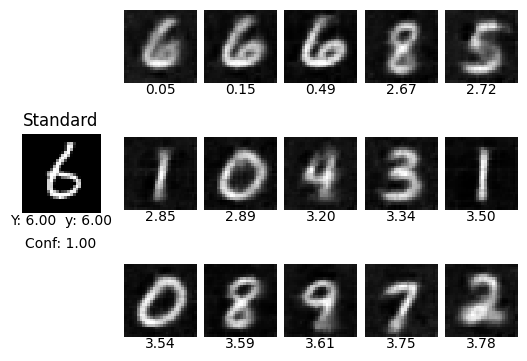

/Users/silviaarenalesmunoz/Desktop/MASTER/TFM/Iras TFG/PrototypeDNN-Robustness-main/model_testing.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


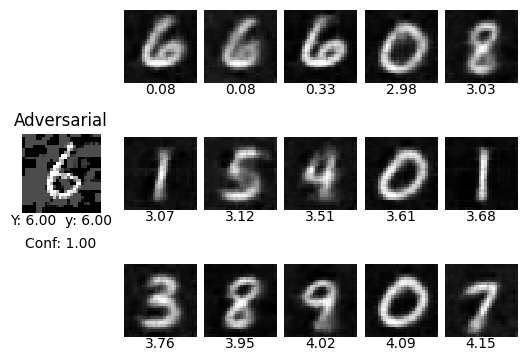

KeyboardInterrupt: 

In [4]:
model1 = FTBx3

alpha = 0.01
iters = 40
eps = 0.3
random_start = True

examples_type = "cdp" # Incorrectly classified and the closest prototype is different.
n_examples = 1

attack = partial(PGDLInf_attack, alpha=alpha, iters=iters, eps=eps, random_start=random_start)
loss = partial(Loss_1, model = model1, alpha1=0, alpha2 = 1, objective = "cenc", force_class = None, change_expl = None)

test_adversarial(model1, test_loader, attack=attack, loss=loss, n_examples=n_examples, examples_type=examples_type)

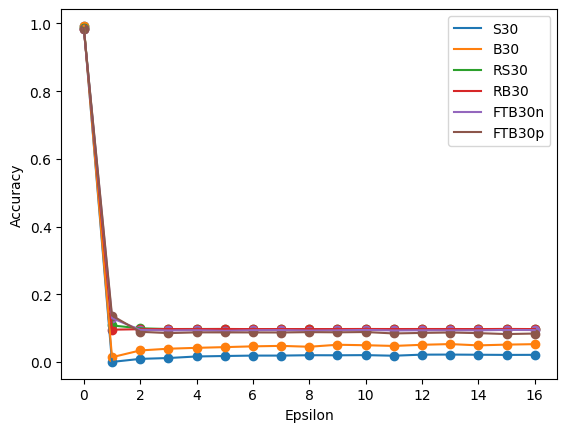

In [10]:
iters = 4
max_eps = 16
step = 0.5
random_start = True

models = [s30, b30, rs30, rb30, ftb30n, ftb30p]
model_names = ["S30", "B30", "RS30", "RB30", "FTB30n", "FTB30p"]
#attack = partial(PGDLInf_attack, iters=iters, random_start=True)
attack = partial(PGDLInf_attack, alpha=alpha, iters=iters, eps=eps, random_start=random_start)
loss = CELoss
#loss = partial(Loss_1, alpha1=0, alpha2 = 1, objective = "cecc", force_class = None, change_expl = None)

adversarial_attacks_eps_plot(models, model_names, test_loader, attack, loss, max_eps, step=step)

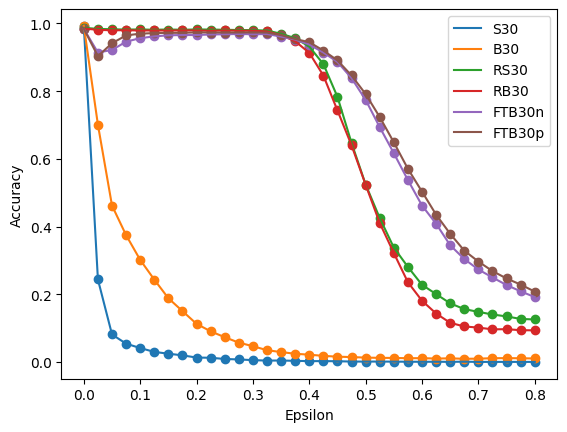

In [12]:
iters = 4
max_eps = 0.8
step = 0.025
random_start = True

models = [s30, b30, rs30, rb30, ftb30n, ftb30p]
model_names = ["S30", "B30", "RS30", "RB30", "FTB30n", "FTB30p"]
#attack = partial(PGDLInf_attack, iters=iters, random_start=random_start)
attack = partial(PGDLInf_attack, alpha=alpha, iters=iters, eps=eps, random_start=random_start)
loss = CELoss

adversarial_attacks_eps_plot(models, model_names, test_loader, attack, loss, max_eps, step=step)

# Más pruebas de ataques

## clase attack

In [6]:
import time
from collections import OrderedDict

import torch
from torch.utils.data import DataLoader, TensorDataset


def wrapper_method(func):
    def wrapper_func(self, *args, **kwargs):
        result = func(self, *args, **kwargs)
        for atk in self.__dict__.get("_attacks").values():
            eval("atk." + func.__name__ + "(*args, **kwargs)")
        return result

    return wrapper_func


class Attack(object):
    r"""
    Base class for all attacks.

    .. note::
        It automatically set device to the device where given model is.
        It basically changes training mode to eval during attack process.
        To change this, please see `set_model_training_mode`.
    """

    def __init__(self, name, model):
        r"""
        Initializes internal attack state.

        Arguments:
            name (str): name of attack.
            model (torch.nn.Module): model to attack.
        """

        self.attack = name
        self._attacks = OrderedDict()

        self.set_model(model)
        try:
            self.device = next(model.parameters()).device
        except Exception:
            self.device = None
            print("Failed to set device automatically, please try set_device() manual.")

        # Controls attack mode.
        self.attack_mode = "default"
        self.supported_mode = ["default"]
        self.targeted = False
        self._target_map_function = None

        # Controls when normalization is used.
        self.normalization_used = None
        self._normalization_applied = None
        if self.model.__class__.__name__ == "RobModel":
            self._set_rmodel_normalization_used(model)

        # Controls model mode during attack.
        self._model_training = False
        self._batchnorm_training = False
        self._dropout_training = False

    def forward(self, inputs, labels=None, *args, **kwargs):
        r"""
        It defines the computation performed at every call.
        Should be overridden by all subclasses.
        """
        raise NotImplementedError

    @wrapper_method
    def set_model(self, model):
        self.model = model
        self.model_name = model.__class__.__name__

    def get_logits(self, inputs, labels=None, *args, **kwargs):
        if self._normalization_applied is False:
            inputs = self.normalize(inputs)
        logits = self.model(inputs)
        return logits

    @wrapper_method
    def _set_normalization_applied(self, flag):
        self._normalization_applied = flag

    @wrapper_method
    def set_device(self, device):
        self.device = device

    @wrapper_method
    def _set_rmodel_normalization_used(self, model):
        r"""
        Set attack normalization for MAIR [https://github.com/Harry24k/MAIR].

        """
        mean = getattr(model, "mean", None)
        std = getattr(model, "std", None)
        if (mean is not None) and (std is not None):
            if isinstance(mean, torch.Tensor):
                mean = mean.cpu().numpy()
            if isinstance(std, torch.Tensor):
                std = std.cpu().numpy()
            if (mean != 0).all() or (std != 1).all():
                self.set_normalization_used(mean, std)

    @wrapper_method
    def set_normalization_used(self, mean, std):
        self.normalization_used = {}
        n_channels = len(mean)
        mean = torch.tensor(mean).reshape(1, n_channels, 1, 1)
        std = torch.tensor(std).reshape(1, n_channels, 1, 1)
        self.normalization_used["mean"] = mean
        self.normalization_used["std"] = std
        self._set_normalization_applied(True)

    def normalize(self, inputs):
        mean = self.normalization_used["mean"].to(inputs.device)
        std = self.normalization_used["std"].to(inputs.device)
        return (inputs - mean) / std

    def inverse_normalize(self, inputs):
        mean = self.normalization_used["mean"].to(inputs.device)
        std = self.normalization_used["std"].to(inputs.device)
        return inputs * std + mean

    def get_mode(self):
        r"""
        Get attack mode.

        """
        return self.attack_mode

    @wrapper_method
    def set_mode_default(self):
        r"""
        Set attack mode as default mode.

        """
        self.attack_mode = "default"
        self.targeted = False
        print("Attack mode is changed to 'default.'")

    @wrapper_method
    def _set_mode_targeted(self, mode, quiet):
        if "targeted" not in self.supported_mode:
            raise ValueError("Targeted mode is not supported.")
        self.targeted = True
        self.attack_mode = mode
        if not quiet:
            print("Attack mode is changed to '%s'." % mode)

    @wrapper_method
    def set_mode_targeted_by_function(self, target_map_function, quiet=False):
        r"""
        Set attack mode as targeted.

        Arguments:
            target_map_function (function): Label mapping function.
                e.g. lambda inputs, labels:(labels+1)%10.
                None for using input labels as targeted labels. (Default)
            quiet (bool): Display information message or not. (Default: False)

        """
        self._set_mode_targeted("targeted(custom)", quiet)
        self._target_map_function = target_map_function

    @wrapper_method
    def set_mode_targeted_random(self, quiet=False):
        r"""
        Set attack mode as targeted with random labels.

        Arguments:
            quiet (bool): Display information message or not. (Default: False)

        """
        self._set_mode_targeted("targeted(random)", quiet)
        self._target_map_function = self.get_random_target_label

    @wrapper_method
    def set_mode_targeted_least_likely(self, kth_min=1, quiet=False):
        r"""
        Set attack mode as targeted with least likely labels.

        Arguments:
            kth_min (str): label with the k-th smallest probability used as target labels. (Default: 1)
            num_classses (str): number of classes. (Default: False)

        """
        self._set_mode_targeted("targeted(least-likely)", quiet)
        assert kth_min > 0
        self._kth_min = kth_min
        self._target_map_function = self.get_least_likely_label

    @wrapper_method
    def set_mode_targeted_by_label(self, quiet=False):
        r"""
        Set attack mode as targeted.

        Arguments:
            quiet (bool): Display information message or not. (Default: False)

        .. note::
            Use user-supplied labels as target labels.
        """
        self._set_mode_targeted("targeted(label)", quiet)
        self._target_map_function = "function is a string"

    @wrapper_method
    def set_model_training_mode(
        self, model_training=False, batchnorm_training=False, dropout_training=False
    ):
        r"""
        Set training mode during attack process.

        Arguments:
            model_training (bool): True for using training mode for the entire model during attack process.
            batchnorm_training (bool): True for using training mode for batchnorms during attack process.
            dropout_training (bool): True for using training mode for dropouts during attack process.

        .. note::
            For RNN-based models, we cannot calculate gradients with eval mode.
            Thus, it should be changed to the training mode during the attack.
        """
        self._model_training = model_training
        self._batchnorm_training = batchnorm_training
        self._dropout_training = dropout_training

    @wrapper_method
    def _change_model_mode(self, given_training):
        if self._model_training:
            self.model.train()
            for _, m in self.model.named_modules():
                if not self._batchnorm_training:
                    if "BatchNorm" in m.__class__.__name__:
                        m = m.eval()
                if not self._dropout_training:
                    if "Dropout" in m.__class__.__name__:
                        m = m.eval()
        else:
            self.model.eval()

    @wrapper_method
    def _recover_model_mode(self, given_training):
        if given_training:
            self.model.train()

    def save(
        self,
        data_loader,
        save_path=None,
        verbose=True,
        return_verbose=False,
        save_predictions=False,
        save_clean_inputs=False,
        save_type="float",
    ):
        r"""
        Save adversarial inputs as torch.tensor from given torch.utils.data.DataLoader.

        Arguments:
            save_path (str): save_path.
            data_loader (torch.utils.data.DataLoader): data loader.
            verbose (bool): True for displaying detailed information. (Default: True)
            return_verbose (bool): True for returning detailed information. (Default: False)
            save_predictions (bool): True for saving predicted labels (Default: False)
            save_clean_inputs (bool): True for saving clean inputs (Default: False)

        """
        if save_path is not None:
            adv_input_list = []
            label_list = []
            if save_predictions:
                pred_list = []
            if save_clean_inputs:
                input_list = []

        correct = 0
        total = 0
        l2_distance = []

        total_batch = len(data_loader)
        given_training = self.model.training

        for step, (inputs, labels) in enumerate(data_loader):
            start = time.time()
            adv_inputs = self.__call__(inputs, labels)
            batch_size = len(inputs)

            if verbose or return_verbose:
                with torch.no_grad():
                    outputs = self.get_output_with_eval_nograd(adv_inputs)

                    # Calculate robust accuracy
                    _, pred = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    right_idx = pred == labels.to(self.device)
                    correct += right_idx.sum()
                    rob_acc = 100 * float(correct) / total

                    # Calculate l2 distance
                    delta = (adv_inputs - inputs.to(self.device)).view(
                        batch_size, -1
                    )  # nopep8
                    l2_distance.append(
                        torch.norm(delta[~right_idx], p=2, dim=1)
                    )  # nopep8
                    l2 = torch.cat(l2_distance).mean().item()

                    # Calculate time computation
                    progress = (step + 1) / total_batch * 100
                    end = time.time()
                    elapsed_time = end - start

                    if verbose:
                        self._save_print(
                            progress, rob_acc, l2, elapsed_time, end="\r"
                        )  # nopep8

            if save_path is not None:
                adv_input_list.append(adv_inputs.detach().cpu())
                label_list.append(labels.detach().cpu())

                adv_input_list_cat = torch.cat(adv_input_list, 0)
                label_list_cat = torch.cat(label_list, 0)

                save_dict = {
                    "adv_inputs": adv_input_list_cat,
                    "labels": label_list_cat,
                }  # nopep8

                if save_predictions:
                    pred_list.append(pred.detach().cpu())
                    pred_list_cat = torch.cat(pred_list, 0)
                    save_dict["preds"] = pred_list_cat

                if save_clean_inputs:
                    input_list.append(inputs.detach().cpu())
                    input_list_cat = torch.cat(input_list, 0)
                    save_dict["clean_inputs"] = input_list_cat

                if self.normalization_used is not None:
                    save_dict["adv_inputs"] = self.inverse_normalize(
                        save_dict["adv_inputs"]
                    )  # nopep8
                    if save_clean_inputs:
                        save_dict["clean_inputs"] = self.inverse_normalize(
                            save_dict["clean_inputs"]
                        )  # nopep8

                if save_type == "int":
                    save_dict["adv_inputs"] = self.to_type(
                        save_dict["adv_inputs"], "int"
                    )  # nopep8
                    if save_clean_inputs:
                        save_dict["clean_inputs"] = self.to_type(
                            save_dict["clean_inputs"], "int"
                        )  # nopep8

                save_dict["save_type"] = save_type
                torch.save(save_dict, save_path)

        # To avoid erasing the printed information.
        if verbose:
            self._save_print(progress, rob_acc, l2, elapsed_time, end="\n")

        if given_training:
            self.model.train()

        if return_verbose:
            return rob_acc, l2, elapsed_time

    @staticmethod
    def to_type(inputs, type):
        r"""
        Return inputs as int if float is given.
        """
        if type == "int":
            if isinstance(inputs, torch.FloatTensor) or isinstance(
                inputs, torch.cuda.FloatTensor
            ):
                return (inputs * 255).type(torch.uint8)
        elif type == "float":
            if isinstance(inputs, torch.ByteTensor) or isinstance(
                inputs, torch.cuda.ByteTensor
            ):
                return inputs.float() / 255
        else:
            raise ValueError(type + " is not a valid type. [Options: float, int]")
        return inputs

    @staticmethod
    def _save_print(progress, rob_acc, l2, elapsed_time, end):
        print(
            "- Save progress: %2.2f %% / Robust accuracy: %2.2f %% / L2: %1.5f (%2.3f it/s) \t"
            % (progress, rob_acc, l2, elapsed_time),
            end=end,
        )

    @staticmethod
    def load(
        load_path,
        batch_size=128,
        shuffle=False,
        normalize=None,
        load_predictions=False,
        load_clean_inputs=False,
    ):
        save_dict = torch.load(load_path)
        keys = ["adv_inputs", "labels"]

        if load_predictions:
            keys.append("preds")
        if load_clean_inputs:
            keys.append("clean_inputs")

        if save_dict["save_type"] == "int":
            save_dict["adv_inputs"] = save_dict["adv_inputs"].float() / 255
            if load_clean_inputs:
                save_dict["clean_inputs"] = (
                    save_dict["clean_inputs"].float() / 255
                )  # nopep8

        if normalize is not None:
            n_channels = len(normalize["mean"])
            mean = torch.tensor(normalize["mean"]).reshape(1, n_channels, 1, 1)
            std = torch.tensor(normalize["std"]).reshape(1, n_channels, 1, 1)
            save_dict["adv_inputs"] = (save_dict["adv_inputs"] - mean) / std
            if load_clean_inputs:
                save_dict["clean_inputs"] = (
                    save_dict["clean_inputs"] - mean
                ) / std  # nopep8

        adv_data = TensorDataset(*[save_dict[key] for key in keys])
        adv_loader = DataLoader(adv_data, batch_size=batch_size, shuffle=shuffle)
        print(
            "Data is loaded in the following order: [%s]" % (", ".join(keys))
        )  # nopep8
        return adv_loader

    @torch.no_grad()
    def get_output_with_eval_nograd(self, inputs):
        given_training = self.model.training
        if given_training:
            self.model.eval()
        outputs = self.get_logits(inputs)
        if given_training:
            self.model.train()
        return outputs

    def get_target_label(self, inputs, labels=None):
        r"""
        Function for changing the attack mode.
        Return input labels.
        """
        if self._target_map_function is None:
            raise ValueError(
                "target_map_function is not initialized by set_mode_targeted."
            )
        if self.attack_mode == "targeted(label)":
            target_labels = labels
        else:
            target_labels = self._target_map_function(inputs, labels)
        return target_labels

    @torch.no_grad()
    def get_least_likely_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            _, t = torch.kthvalue(outputs[counter][l], self._kth_min)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    @torch.no_grad()
    def get_random_target_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            t = (len(l) * torch.rand([1])).long().to(self.device)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    def __call__(self, inputs, labels=None, *args, **kwargs):
        given_training = self.model.training
        self._change_model_mode(given_training)

        if self._normalization_applied is True:
            inputs = self.inverse_normalize(inputs)
            self._set_normalization_applied(False)

            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            # adv_inputs = self.to_type(adv_inputs, self.return_type)

            adv_inputs = self.normalize(adv_inputs)
            self._set_normalization_applied(True)
        else:
            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            # adv_inputs = self.to_type(adv_inputs, self.return_type)

        self._recover_model_mode(given_training)

        return adv_inputs

    def __repr__(self):
        info = self.__dict__.copy()

        del_keys = ["model", "attack", "supported_mode"]

        for key in info.keys():
            if key[0] == "_":
                del_keys.append(key)

        for key in del_keys:
            del info[key]

        info["attack_mode"] = self.attack_mode
        info["normalization_used"] = (
            True if self.normalization_used is not None else False
        )

        return (
            self.attack
            + "("
            + ", ".join("{}={}".format(key, val) for key, val in info.items())
            + ")"
        )

    def __setattr__(self, name, value):
        object.__setattr__(self, name, value)

        attacks = self.__dict__.get("_attacks")

        # Get all items in iterable items.
        def get_all_values(items, stack=[]):
            if items not in stack:
                stack.append(items)
                if isinstance(items, list) or isinstance(items, dict):
                    if isinstance(items, dict):
                        items = list(items.keys()) + list(items.values())
                    for item in items:
                        yield from get_all_values(item, stack)
                else:
                    if isinstance(items, Attack):
                        yield items
            else:
                if isinstance(items, Attack):
                    yield items

        for num, value in enumerate(get_all_values(value)):
            attacks[name + "." + str(num)] = value
            for subname, subvalue in value.__dict__.get("_attacks").items():
                attacks[name + "." + subname] = subvalue

## funciones para ataques

In [7]:
pip install torchattacks

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import matplotlib.pyplot as plt
def Imagenes_attack(attack, model):
    # Obtener un lote de imágenes y etiquetas del conjunto de test
    for batch in test_loader:
        batch_x = batch[0].to(device)  # Imágenes originales
        batch_y = batch[1].to(device)  # Etiquetas verdaderas
        break  # Solo usamos el primer batch para visualizar

    # Generar imágenes adversarias
    adv_images = attack(batch_x, batch_y)

    # Obtener las predicciones antes y después del ataque
    pred_orig = model(batch_x).argmax(dim=1)  # Predicción sin ataque
    pred_adv = model(adv_images).argmax(dim=1)  # Predicción con ataque

    examples_to_show = 10  # Número de imágenes a visualizar

    fig, axes = plt.subplots(3, examples_to_show, figsize=(10, 6))
    for i in range(examples_to_show):
        # Imagen original
        axes[0, i].imshow(batch_x[i].detach().cpu().numpy().squeeze(), cmap="gray")
        axes[0, i].set_title(f"Real: {batch_y[i].item()}")
        axes[0, i].axis("off")

        # Imagen perturbada
        axes[1, i].imshow(adv_images[i].detach().cpu().numpy().squeeze(), cmap="gray")
        axes[1, i].set_title(f"Pert: {pred_adv[i].item()}")
        axes[1, i].axis("off")

        # Predicción antes y después del ataque
        axes[2, i].text(0.5, 0.5, f"Orig: {pred_orig[i].item()}\nAdv: {pred_adv[i].item()}", 
                        ha="center", va="center", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        axes[2, i].axis("off")

    fig.suptitle("Ejemplos de test - Attack", fontsize=14)
    plt.show()
    return adv_images, batch_x, batch_y


In [9]:
import torch.nn.functional as F
import pandas as pd

def probabilities_attack2(adv_images, model, batch_x, batch_y):
    # Obtener las probabilidades de la red para las imágenes originales y adversariales
    probs_orig = F.softmax(model(batch_x), dim=1).detach().cpu().numpy()
    probs_adv = F.softmax(model(adv_images), dim=1).detach().cpu().numpy()
    
    # Predicciones originales y con ataque
    preds_orig = probs_orig.argmax(axis=1)
    preds_adv = probs_adv.argmax(axis=1)
    
    # Convertir etiquetas reales a numpy
    true_labels = batch_y.detach().cpu().numpy()
    
    # Calcular aciertos y fallos
    correct_orig = (preds_orig == true_labels).sum()
    correct_adv = (preds_adv == true_labels).sum()
    total = len(true_labels)
    
    # Accuracy antes y después del ataque
    accuracy_orig = correct_orig / total
    accuracy_adv = correct_adv / total
    
    # Número de cambios en la predicción debido al ataque
    changed_preds = (preds_orig != preds_adv).sum()
    change_rate = changed_preds / total
    
    # Crear DataFrames para mostrar probabilidades
    df_orig = pd.DataFrame(probs_orig[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])
    df_adv = pd.DataFrame(probs_adv[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])
    
    # Mostrar probabilidades
    print("Probabilidades originales:")
    display(df_orig.style.format(precision=2).highlight_max(axis=1, props="background-color:blue;"))

    print("Probabilidades con ataque:")
    display(df_adv.style.format(precision=2).highlight_max(axis=1, props="background-color:red;color:white;"))

    # Mostrar estadísticas
    print(f"\n Estadísticas del ataque adversarial:")
    print(f"Aciertos antes del ataque: {correct_orig}/{total} ({accuracy_orig:.2%})")
    print(f"Aciertos después del ataque: {correct_adv}/{total} ({accuracy_adv:.2%})")
    print(f"Cambio de predicción en {changed_preds}/{total} imágenes ({change_rate:.2%})")

    return accuracy_orig, accuracy_adv, change_rate


In [10]:
import torch.nn.functional as F
import pandas as pd

def probabilities_attack2(adv_images, model, batch_x, batch_y):
    # Obtener las probabilidades de la red para las imágenes originales y adversariales
    probs_orig = F.softmax(model(batch_x), dim=1).detach().cpu().numpy()
    probs_adv = F.softmax(model(adv_images), dim=1).detach().cpu().numpy()
    
    # Predicciones originales y con ataque
    preds_orig = probs_orig.argmax(axis=1)
    preds_adv = probs_adv.argmax(axis=1)
    
    # Convertir etiquetas reales a numpy
    true_labels = batch_y.detach().cpu().numpy()
    
    # Calcular aciertos y fallos
    correct_orig = (preds_orig == true_labels).sum()
    correct_adv = (preds_adv == true_labels).sum()
    total = len(true_labels)
    
    # Accuracy antes y después del ataque
    accuracy_orig = correct_orig / total
    accuracy_adv = correct_adv / total
    
    # Número de cambios en la predicción debido al ataque
    changed_preds = (preds_orig != preds_adv).sum()
    change_rate = changed_preds / total
    
    # Crear DataFrames para mostrar probabilidades
    df_orig = pd.DataFrame(probs_orig[:10], columns=[f"Clase {i}" for i in range(10)])
    df_adv = pd.DataFrame(probs_adv[:10], columns=[f"Clase {i}" for i in range(10)])
    
    # Mostrar probabilidades
    print("Probabilidades originales:")
    display(df_orig.style.format(precision=2).highlight_max(axis=1, props="background-color:blue;"))

    print("Probabilidades con ataque:")
    display(df_adv.style.format(precision=2).highlight_max(axis=1, props="background-color:red;color:white;"))

    # Mostrar estadísticas
    print(f"\n Estadísticas del ataque adversarial:")
    print(f"Aciertos antes del ataque: {correct_orig}/{total} ({accuracy_orig:.2%})")
    print(f"Aciertos después del ataque: {correct_adv}/{total} ({accuracy_adv:.2%})")
    print(f"Cambio de predicción en {changed_preds}/{total} imágenes ({change_rate:.2%})")

    return accuracy_orig, accuracy_adv, change_rate


## 1. FGSM

In [10]:
import torch
import torch.nn as nn

#from ..attack import Attack


class FGSM(Attack):
    r"""
    FGSM in the paper 'Explaining and harnessing adversarial examples'
    [https://arxiv.org/abs/1412.6572]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.FGSM(model, eps=8/255)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, eps=8 / 255):
        super().__init__("FGSM", model)
        self.eps = eps
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        images.requires_grad = True
        outputs = self.get_logits(images)

        # Calculate loss
        if self.targeted:
            cost = -loss(outputs, target_labels)
        else:
            cost = loss(outputs, labels)

        # Update adversarial images
        grad = torch.autograd.grad(
            cost, images, retain_graph=False, create_graph=False
        )[0]

        adv_images = images + self.eps * grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images

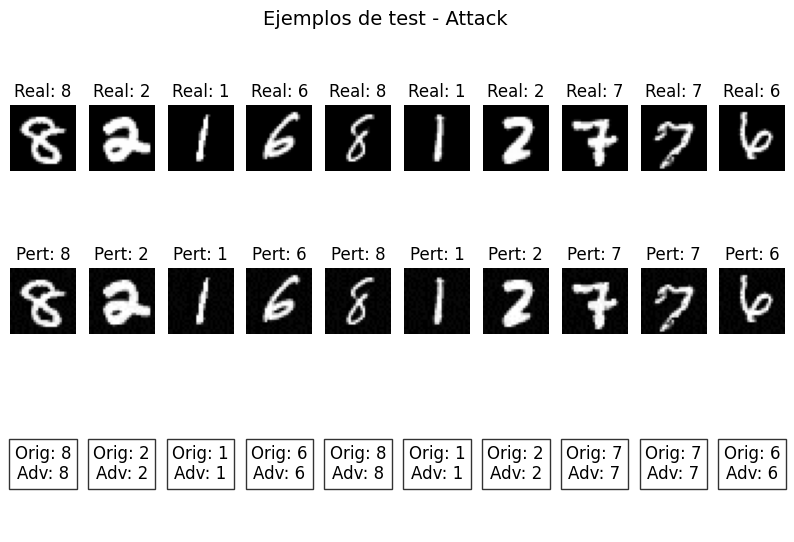

In [11]:
from torchattacks import FGSM  # Asegúrate de tener instalada la librería torchattacks

# Definir el ataque FGSM con el modelo y el valor de epsilon
attack = FGSM(FTBx5, eps=8/255)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)


In [12]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 245/250 (98.00%)
Cambio de predicción en 2/250 imágenes (0.80%)


(np.float64(0.988), np.float64(0.98), np.float64(0.008))

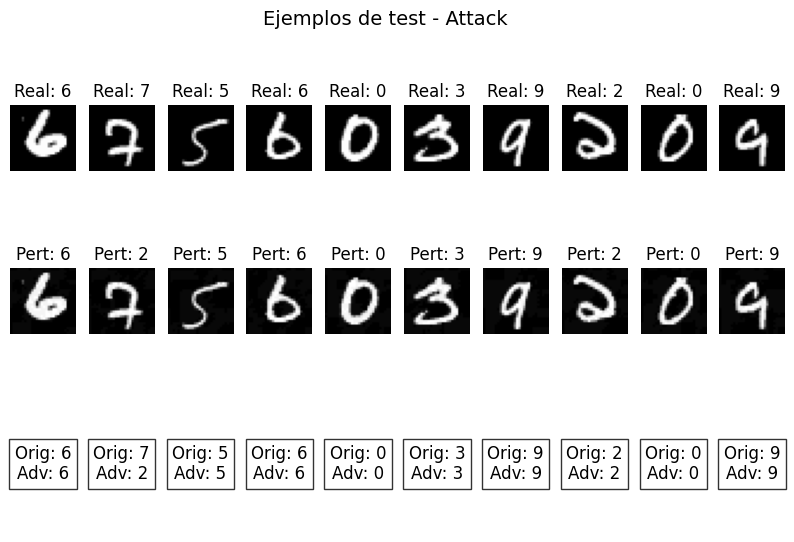

In [58]:
attack = FGSM(ftb30p, eps=8/255)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [59]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 234/250 (93.60%)
Cambio de predicción en 13/250 imágenes (5.20%)


(np.float64(0.988), np.float64(0.936), np.float64(0.052))

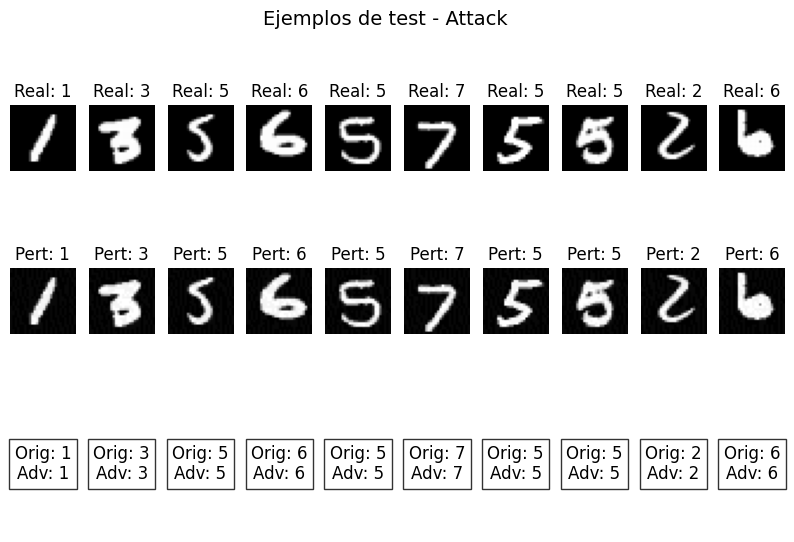

In [14]:
# Definir el ataque FGSM con el modelo y el valor de epsilon
attack = FGSM(FTBx3_2, eps=8/255)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx3_2)


In [15]:
probabilities_attack2(adv_images, FTBx3_2, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 247/250 (98.80%)
Cambio de predicción en 0/250 imágenes (0.00%)


(np.float64(0.988), np.float64(0.988), np.float64(0.0))

## 2. DeepFool attack 

In [11]:
import torch
import torch.nn as nn



class DeepFool(Attack):
    r"""
    'DeepFool: A Simple and Accurate Method to Fool Deep Neural Networks'
    [https://arxiv.org/abs/1511.04599]
    Distance Measure : L2
    Arguments:
        model (nn.Module): model to attack.
        steps (int): number of steps. (Default: 50)
        overshoot (float): parameter for enhancing the noise. (Default: 0.02)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.DeepFool(model, steps=50, overshoot=0.02)
        >>> adv_images = attack(images, labels)
    """

    def __init__(self, model, steps=50, overshoot=0.02):
        super().__init__("DeepFool", model)
        self.steps = steps
        self.overshoot = overshoot
        self.supported_mode = ["default"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        adv_images, target_labels = self.forward_return_target_labels(images, labels)
        return adv_images

    def forward_return_target_labels(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        batch_size = len(images)
        correct = torch.tensor([True] * batch_size)
        target_labels = labels.clone().detach().to(self.device)
        curr_steps = 0

        adv_images = []
        for idx in range(batch_size):
            image = images[idx : idx + 1].clone().detach()
            adv_images.append(image)

        while (True in correct) and (curr_steps < self.steps):
            for idx in range(batch_size):
                if not correct[idx]:
                    continue
                early_stop, pre, adv_image = self._forward_indiv(
                    adv_images[idx], labels[idx]
                )
                adv_images[idx] = adv_image
                target_labels[idx] = pre
                if early_stop:
                    correct[idx] = False
            curr_steps += 1

        adv_images = torch.cat(adv_images).detach()
        return adv_images, target_labels

    def _forward_indiv(self, image, label):
        image.requires_grad = True
        fs = self.get_logits(image)[0]
        _, pre = torch.max(fs, dim=0)
        if pre != label:
            return (True, pre, image)

        ws = self._construct_jacobian(fs, image)
        image = image.detach()

        f_0 = fs[label]
        w_0 = ws[label]

        wrong_classes = [i for i in range(len(fs)) if i != label]
        f_k = fs[wrong_classes]
        w_k = ws[wrong_classes]

        f_prime = f_k - f_0
        w_prime = w_k - w_0
        value = torch.abs(f_prime) / torch.norm(nn.Flatten()(w_prime), p=2, dim=1)
        _, hat_L = torch.min(value, 0)

        delta = (
            torch.abs(f_prime[hat_L])
            * w_prime[hat_L]
            / (torch.norm(w_prime[hat_L], p=2) ** 2)
        )

        target_label = hat_L if hat_L < label else hat_L + 1

        adv_image = image + (1 + self.overshoot) * delta
        adv_image = torch.clamp(adv_image, min=0, max=1).detach()
        return (False, target_label, adv_image)

    # https://stackoverflow.com/questions/63096122/pytorch-is-it-possible-to-differentiate-a-matrix
    # torch.autograd.functional.jacobian is only for torch >= 1.5.1
    def _construct_jacobian(self, y, x):
        x_grads = []
        for idx, y_element in enumerate(y):
            if x.grad is not None:
                x.grad.zero_()
            y_element.backward(retain_graph=(False or idx + 1 < len(y)))
            x_grads.append(x.grad.clone().detach())
        return torch.stack(x_grads).reshape(*y.shape, *x.shape)

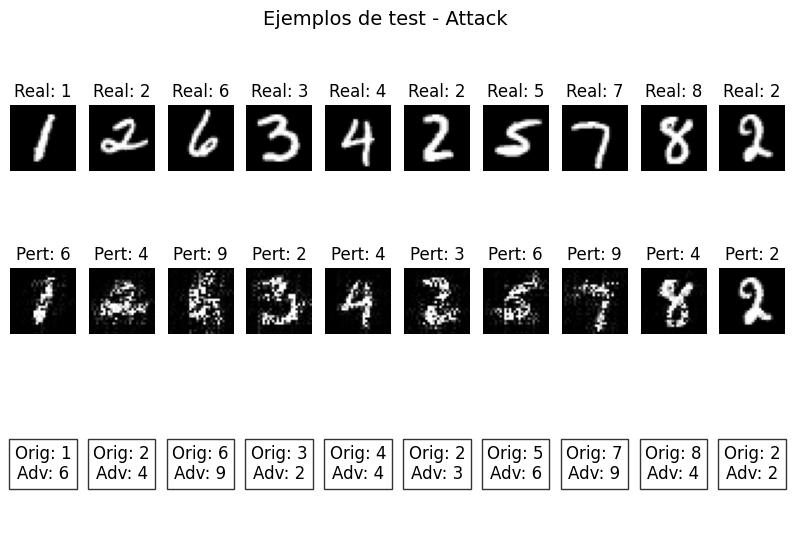

In [17]:
attack = DeepFool(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [18]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 19/250 (7.60%)
Cambio de predicción en 228/250 imágenes (91.20%)


(np.float64(0.988), np.float64(0.076), np.float64(0.912))

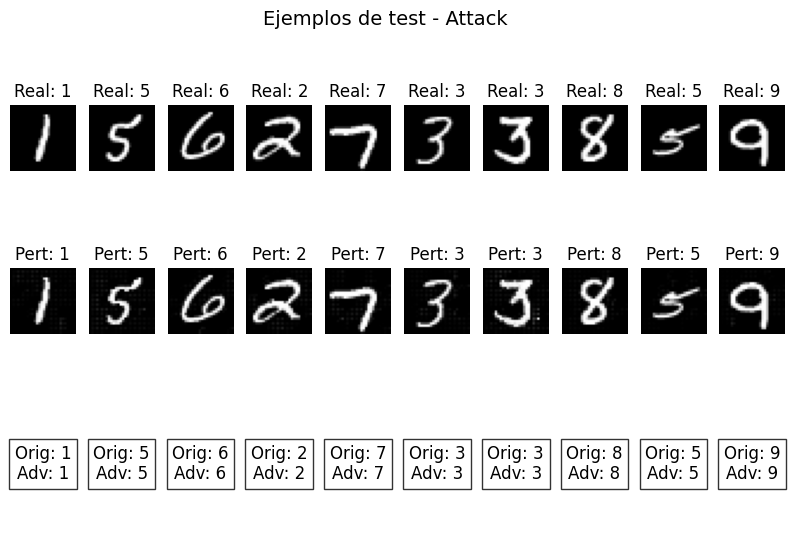

In [19]:
attack = DeepFool(FTBx2)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx2)

In [52]:
probabilities_attack2(adv_images, FTBx2, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 246/250 (98.40%)
Aciertos después del ataque: 237/250 (94.80%)
Cambio de predicción en 9/250 imágenes (3.60%)


(np.float64(0.984), np.float64(0.948), np.float64(0.036))

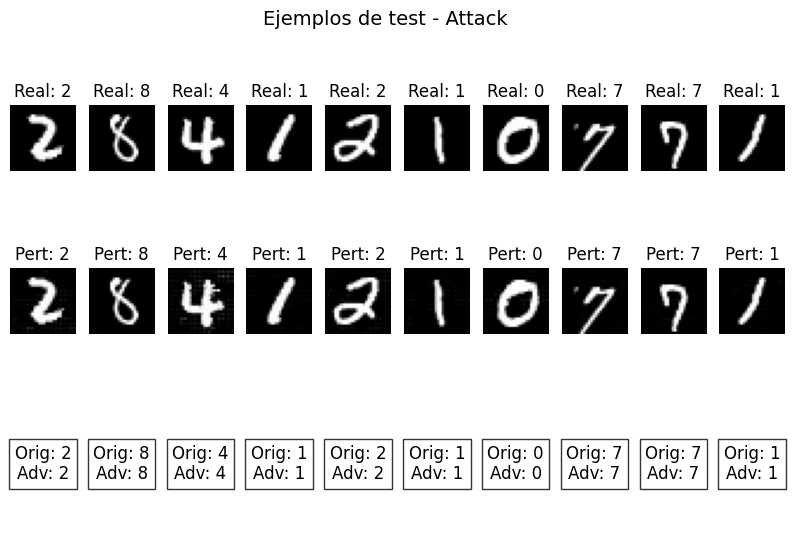

In [19]:
attack = DeepFool(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [20]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 246/250 (98.40%)
Aciertos después del ataque: 244/250 (97.60%)
Cambio de predicción en 2/250 imágenes (0.80%)


(np.float64(0.984), np.float64(0.976), np.float64(0.008))

## 3. CW

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim



class CW(Attack):
    r"""
    CW in the paper 'Towards Evaluating the Robustness of Neural Networks'
    [https://arxiv.org/abs/1608.04644]

    Distance Measure : L2

    Arguments:
        model (nn.Module): model to attack.
        c (float): c in the paper. parameter for box-constraint. (Default: 1)    
            :math:`minimize \Vert\frac{1}{2}(tanh(w)+1)-x\Vert^2_2+c\cdot f(\frac{1}{2}(tanh(w)+1))`
        kappa (float): kappa (also written as 'confidence') in the paper. (Default: 0)
            :math:`f(x')=max(max\{Z(x')_i:i\neq t\} -Z(x')_t, - \kappa)`
        steps (int): number of steps. (Default: 50)
        lr (float): learning rate of the Adam optimizer. (Default: 0.01)

    .. warning:: With default c, you can't easily get adversarial images. Set higher c like 1.

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.CW(model, c=1, kappa=0, steps=50, lr=0.01)
        >>> adv_images = attack(images, labels)

    .. note:: Binary search for c is NOT IMPLEMENTED methods in the paper due to time consuming.

    """

    def __init__(self, model, c=1, kappa=0, steps=50, lr=0.01):
        super().__init__("CW", model)
        self.c = c
        self.kappa = kappa
        self.steps = steps
        self.lr = lr
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        # w = torch.zeros_like(images).detach() # Requires 2x times
        w = self.inverse_tanh_space(images).detach()
        w.requires_grad = True

        best_adv_images = images.clone().detach()
        best_L2 = 1e10 * torch.ones((len(images))).to(self.device)
        prev_cost = 1e10
        dim = len(images.shape)

        MSELoss = nn.MSELoss(reduction="none")
        Flatten = nn.Flatten()

        optimizer = optim.Adam([w], lr=self.lr)

        for step in range(self.steps):
            # Get adversarial images
            adv_images = self.tanh_space(w)

            # Calculate loss
            current_L2 = MSELoss(Flatten(adv_images), Flatten(images)).sum(dim=1)
            L2_loss = current_L2.sum()

            outputs = self.get_logits(adv_images)
            if self.targeted:
                f_loss = self.f(outputs, target_labels).sum()
            else:
                f_loss = self.f(outputs, labels).sum()

            cost = L2_loss + self.c * f_loss

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            # Update adversarial images
            pre = torch.argmax(outputs.detach(), 1)
            if self.targeted:
                # We want to let pre == target_labels in a targeted attack
                condition = (pre == target_labels).float()
            else:
                # If the attack is not targeted we simply make these two values unequal
                condition = (pre != labels).float()

            # Filter out images that get either correct predictions or non-decreasing loss,
            # i.e., only images that are both misclassified and loss-decreasing are left
            mask = condition * (best_L2 > current_L2.detach())
            best_L2 = mask * current_L2.detach() + (1 - mask) * best_L2

            mask = mask.view([-1] + [1] * (dim - 1))
            best_adv_images = mask * adv_images.detach() + (1 - mask) * best_adv_images

            # Early stop when loss does not converge.
            # max(.,1) To prevent MODULO BY ZERO error in the next step.
            if step % max(self.steps // 10, 1) == 0:
                if cost.item() > prev_cost:
                    return best_adv_images
                prev_cost = cost.item()

        return best_adv_images

    def tanh_space(self, x):
        return 1 / 2 * (torch.tanh(x) + 1)

    def inverse_tanh_space(self, x):
        # torch.atanh is only for torch >= 1.7.0
        # atanh is defined in the range -1 to 1
        return self.atanh(torch.clamp(x * 2 - 1, min=-1, max=1))

    def atanh(self, x):
        return 0.5 * torch.log((1 + x) / (1 - x))

    # f-function in the paper
    def f(self, outputs, labels):
        one_hot_labels = torch.eye(outputs.shape[1]).to(self.device)[labels]

        # find the max logit other than the target class
        other = torch.max((1 - one_hot_labels) * outputs, dim=1)[0]
        # get the target class's logit
        real = torch.max(one_hot_labels * outputs, dim=1)[0]

        if self.targeted:
            return torch.clamp((other - real), min=-self.kappa)
        else:
            return torch.clamp((real - other), min=-self.kappa)

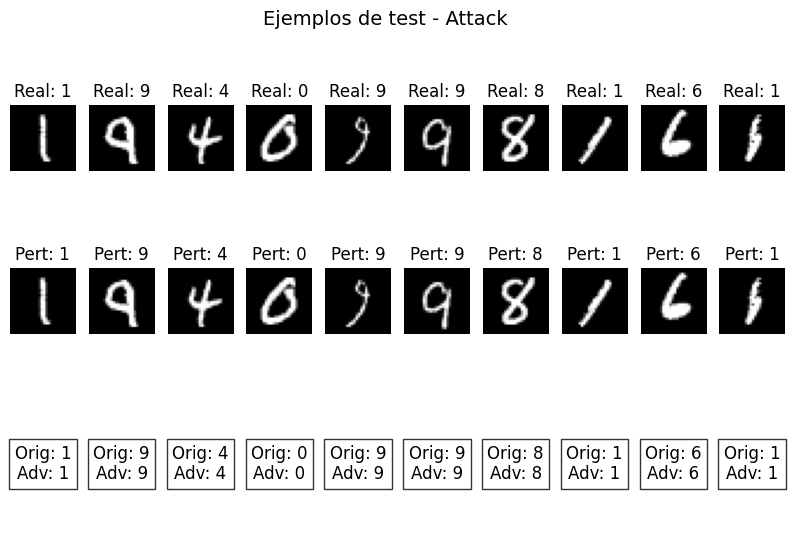

In [23]:

attack = CW(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [24]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 248/250 (99.20%)
Aciertos después del ataque: 248/250 (99.20%)
Cambio de predicción en 0/250 imágenes (0.00%)


(np.float64(0.992), np.float64(0.992), np.float64(0.0))

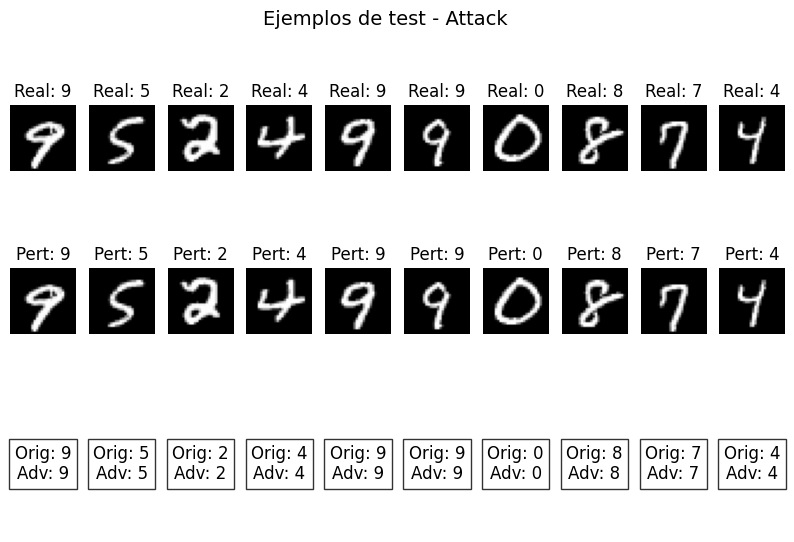

In [25]:
attack = CW(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [26]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 249/250 (99.60%)
Aciertos después del ataque: 249/250 (99.60%)
Cambio de predicción en 0/250 imágenes (0.00%)


(np.float64(0.996), np.float64(0.996), np.float64(0.0))

## 4. PGDL2

In [30]:
import torch
import torch.nn as nn


class PGDL2(Attack):
    r"""
    PGD in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
    [https://arxiv.org/abs/1706.06083]

    Distance Measure : L2

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 1.0)
        alpha (float): step size. (Default: 0.2)
        steps (int): number of steps. (Default: 10)
        random_start (bool): using random initialization of delta. (Default: True)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.PGDL2(model, eps=1.0, alpha=0.2, steps=10, random_start=True)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        eps=1.0,
        alpha=0.2,
        steps=10,
        random_start=True,
        eps_for_division=1e-10,
    ):
        super().__init__("PGDL2", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.eps_for_division = eps_for_division
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        adv_images = images.clone().detach()
        batch_size = len(images)

        if self.random_start:
            # Starting at a uniformly random point
            delta = torch.empty_like(adv_images).normal_()
            d_flat = delta.view(adv_images.size(0), -1)
            n = d_flat.norm(p=2, dim=1).view(adv_images.size(0), 1, 1, 1)
            r = torch.zeros_like(n).uniform_(0, 1)
            delta *= r / n * self.eps
            adv_images = torch.clamp(adv_images + delta, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]
            grad_norms = (
                torch.norm(grad.view(batch_size, -1), p=2, dim=1)
                + self.eps_for_division
            )  # nopep8
            grad = grad / grad_norms.view(batch_size, 1, 1, 1)
            adv_images = adv_images.detach() + self.alpha * grad

            delta = adv_images - images
            delta_norms = torch.norm(delta.view(batch_size, -1), p=2, dim=1)
            factor = self.eps / delta_norms
            factor = torch.min(factor, torch.ones_like(delta_norms))
            delta = delta * factor.view(-1, 1, 1, 1)

            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

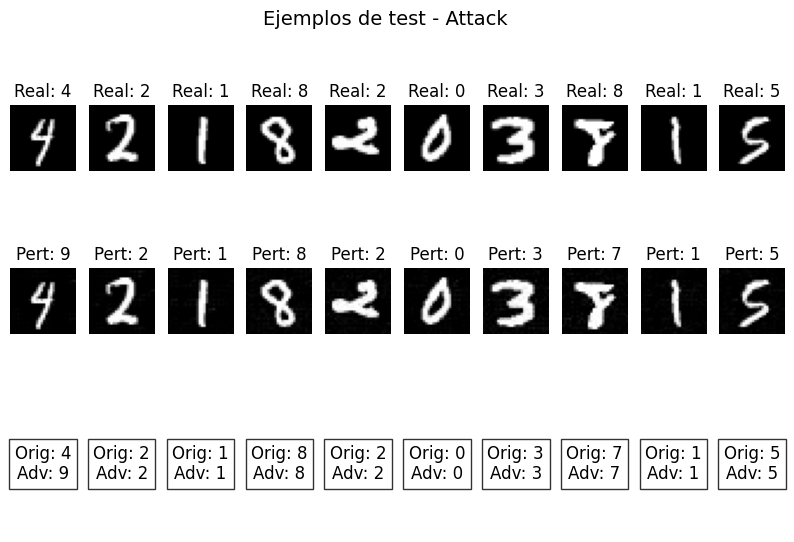

In [31]:
attack = PGDL2(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [32]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 245/250 (98.00%)
Aciertos después del ataque: 214/250 (85.60%)
Cambio de predicción en 32/250 imágenes (12.80%)


(np.float64(0.98), np.float64(0.856), np.float64(0.128))

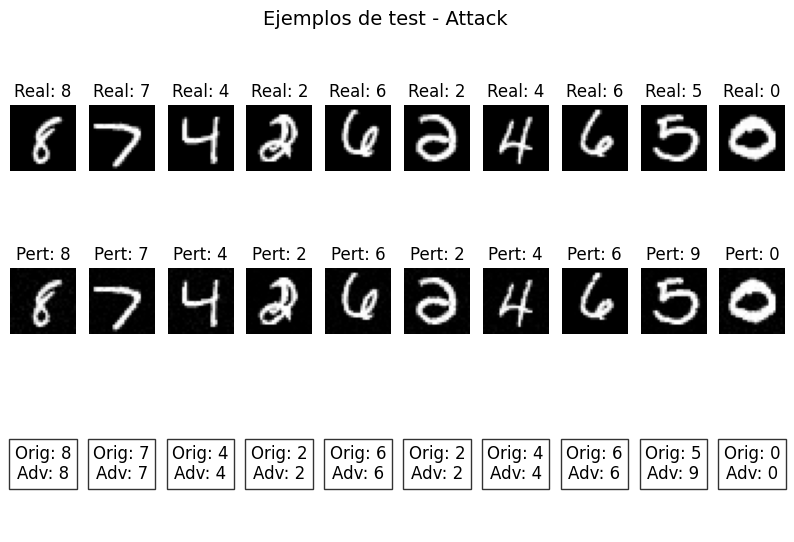

In [33]:
attack = PGDL2(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [34]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 248/250 (99.20%)
Aciertos después del ataque: 238/250 (95.20%)
Cambio de predicción en 10/250 imágenes (4.00%)


(np.float64(0.992), np.float64(0.952), np.float64(0.04))

## 5. EOTPGD

In [35]:
import torch
import torch.nn as nn

class EOTPGD(Attack):
    r"""
    Comment on "Adv-BNN: Improved Adversarial Defense through Robust Bayesian Neural Network"
    [https://arxiv.org/abs/1907.00895]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 10)
        eot_iter (int) : number of models to estimate the mean gradient. (Default: 2)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`, `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.EOTPGD(model, eps=8/255, alpha=2/255, steps=10, eot_iter=2)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self, model, eps=8 / 255, alpha=2 / 255, steps=10, eot_iter=2, random_start=True
    ):
        super().__init__("EOTPGD", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.eot_iter = eot_iter
        self.random_start = random_start
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(
                -self.eps, self.eps
            )  # nopep8
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            grad = torch.zeros_like(adv_images)
            adv_images.requires_grad = True

            for j in range(self.eot_iter):
                outputs = self.get_logits(adv_images)

                # Calculate loss
                if self.targeted:
                    cost = -loss(outputs, target_labels)
                else:
                    cost = loss(outputs, labels)

                # Update adversarial images
                grad += torch.autograd.grad(
                    cost, adv_images, retain_graph=False, create_graph=False
                )[0]

            # (grad/self.eot_iter).sign() == grad.sign()
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

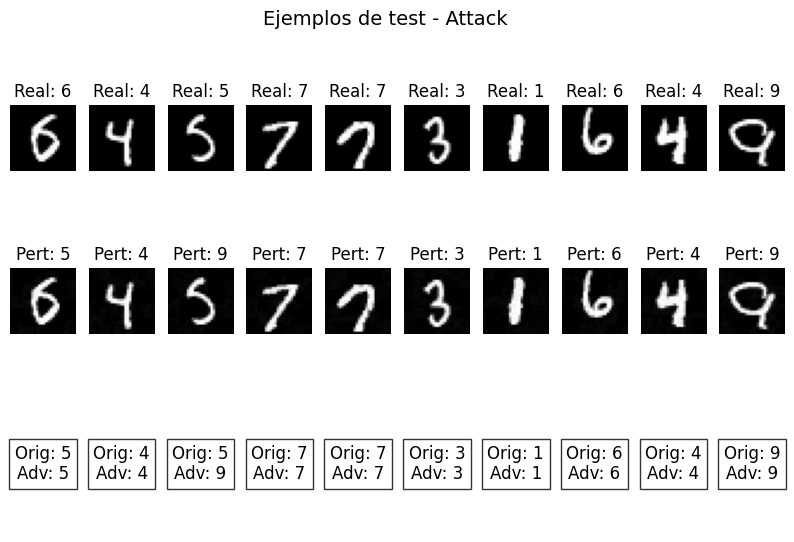

In [36]:
attack = EOTPGD(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [37]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 210/250 (84.00%)
Cambio de predicción en 38/250 imágenes (15.20%)


(np.float64(0.988), np.float64(0.84), np.float64(0.152))

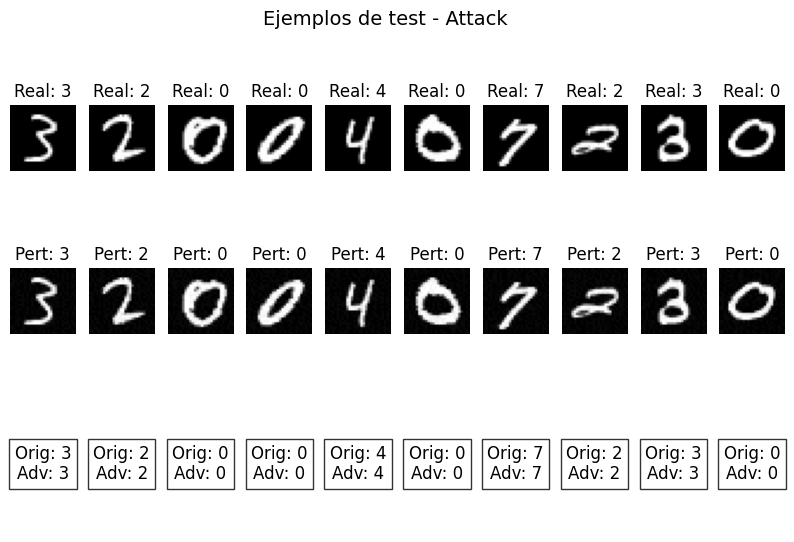

In [38]:
attack = EOTPGD(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [39]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 248/250 (99.20%)
Aciertos después del ataque: 246/250 (98.40%)
Cambio de predicción en 2/250 imágenes (0.80%)


(np.float64(0.992), np.float64(0.984), np.float64(0.008))

## 6. Pixle

In [41]:
from itertools import chain

import numpy as np
import torch
from torch.nn.functional import softmax

class Pixle(Attack):
    r"""
    Pixle: a fast and effective black-box attack based on rearranging pixels'
    [https://arxiv.org/abs/2202.02236]

    Distance Measure : L0

    Arguments:
        model (nn.Module): model to attack.
        x_dimensions (int or float, or a tuple containing a combination of those): size of the sampled patch along ther x side for each iteration. The integers are considered as fixed number of size,
        while the float as parcentage of the size. A tuple is used to specify both under and upper bound of the size. (Default: (2, 10))
        y_dimensions (int or float, or a tuple containing a combination of those): size of the sampled patch along ther y side for each iteration. The integers are considered as fixed number of size,
        while the float as parcentage of the size. A tuple is used to specify both under and upper bound of the size. (Default: (2, 10))
        pixel_mapping (str): the type of mapping used to move the pixels. Can be: 'random', 'similarity', 'similarity_random', 'distance', 'distance_random' (Default: random)
        restarts (int): the number of restarts that the algortihm performs. (Default: 20)
        max_iterations (int): number of iterations to perform for each restart. (Default: 10)
        update_each_iteration (bool): if the attacked images must be modified after each iteration (True) or after each restart (False).  (Default: False)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.Pixle(model, x_dimensions=(0.1, 0.2), restarts=10, max_iterations=50)
        >>> adv_images = attack(images, labels)
    """

    def __init__(
        self,
        model,
        x_dimensions=(2, 10),
        y_dimensions=(2, 10),
        pixel_mapping="random",
        restarts=20,
        max_iterations=10,
        update_each_iteration=False,
    ):
        super().__init__("Pixle", model)

        if restarts < 0 or not isinstance(restarts, int):
            raise ValueError(
                "restarts must be and integer >= 0 " "({})".format(restarts)
            )

        self.update_each_iteration = update_each_iteration
        self.max_patches = max_iterations

        self.restarts = restarts
        self.pixel_mapping = pixel_mapping.lower()

        if self.pixel_mapping not in [
            "random",
            "similarity",
            "similarity_random",
            "distance",
            "distance_random",
        ]:
            raise ValueError(
                "pixel_mapping must be one of [random, similarity,"
                "similarity_random, distance, distance_random]"
                " ({})".format(self.pixel_mapping)
            )

        if isinstance(y_dimensions, (int, float)):
            y_dimensions = [y_dimensions, y_dimensions]

        if isinstance(x_dimensions, (int, float)):
            x_dimensions = [x_dimensions, x_dimensions]

        if not all(
            [
                (isinstance(d, (int)) and d > 0)
                or (isinstance(d, float) and 0 <= d <= 1)
                for d in chain(y_dimensions, x_dimensions)
            ]
        ):
            raise ValueError(
                "dimensions of first patch must contains integers"
                " or floats in [0, 1]"
                " ({})".format(y_dimensions)
            )

        self.p1_x_dimensions = x_dimensions
        self.p1_y_dimensions = y_dimensions

        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):

        if not self.update_each_iteration:
            adv_images = self.restart_forward(images, labels)
            return adv_images
        else:
            adv_images = self.iterative_forward(images, labels)
            return adv_images

    def restart_forward(self, images, labels):
        if len(images.shape) == 3:
            images = images.unsqueeze(0)

        if self.targeted:
            labels = self.get_target_label(images, labels)

        x_bounds = tuple(
            [
                max(1, d if isinstance(d, int) else round(images.size(3) * d))
                for d in self.p1_x_dimensions
            ]
        )

        y_bounds = tuple(
            [
                max(1, d if isinstance(d, int) else round(images.size(2) * d))
                for d in self.p1_y_dimensions
            ]
        )

        adv_images = []

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        bs, _, _, _ = images.shape

        for idx in range(bs):
            image, label = images[idx : idx + 1], labels[idx : idx + 1]

            best_image = image.clone()
            pert_image = image.clone()

            loss, callback = self._get_fun(image, label, target_attack=self.targeted)
            best_solution = None

            best_p = loss(solution=image, solution_as_perturbed=True)
            image_probs = [best_p]

            it = 0

            for r in range(self.restarts):
                stop = False

                for it in range(self.max_patches):

                    (x, y), (x_offset, y_offset) = self.get_patch_coordinates(
                        image=image, x_bounds=x_bounds, y_bounds=y_bounds
                    )

                    destinations = self.get_pixel_mapping(
                        image, x, x_offset, y, y_offset, destination_image=best_image
                    )

                    solution = [x, y, x_offset, y_offset] + destinations

                    pert_image = self._perturb(
                        source=image, destination=best_image, solution=solution
                    )

                    p = loss(solution=pert_image, solution_as_perturbed=True)

                    if p < best_p:
                        best_p = p
                        best_solution = pert_image

                    image_probs.append(best_p)

                    if callback(pert_image, None, True):
                        best_solution = pert_image
                        stop = True
                        break

                if best_solution is None:
                    best_image = pert_image
                else:
                    best_image = best_solution

                if stop:
                    break

            adv_images.append(best_image)

        adv_images = torch.cat(adv_images)

        return adv_images

    def iterative_forward(self, images, labels):
        assert len(images.shape) == 3 or (
            len(images.shape) == 4 and images.size(0) == 1
        )

        if len(images.shape) == 3:
            images = images.unsqueeze(0)

        if self.targeted:
            labels = self.get_target_label(images, labels)

        x_bounds = tuple(
            [
                max(1, d if isinstance(d, int) else round(images.size(3) * d))
                for d in self.p1_x_dimensions
            ]
        )

        y_bounds = tuple(
            [
                max(1, d if isinstance(d, int) else round(images.size(2) * d))
                for d in self.p1_y_dimensions
            ]
        )

        adv_images = []

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        bs, _, _, _ = images.shape

        for idx in range(bs):
            image, label = images[idx : idx + 1], labels[idx : idx + 1]

            best_image = image.clone()

            loss, callback = self._get_fun(image, label, target_attack=self.targeted)

            best_p = loss(solution=image, solution_as_perturbed=True)
            image_probs = [best_p]

            for it in range(self.max_patches):

                (x, y), (x_offset, y_offset) = self.get_patch_coordinates(
                    image=image, x_bounds=x_bounds, y_bounds=y_bounds
                )

                destinations = self.get_pixel_mapping(
                    image, x, x_offset, y, y_offset, destination_image=best_image
                )

                solution = [x, y, x_offset, y_offset] + destinations

                pert_image = self._perturb(
                    source=image, destination=best_image, solution=solution
                )

                p = loss(solution=pert_image, solution_as_perturbed=True)

                if p < best_p:
                    best_p = p
                    best_image = pert_image

                image_probs.append(best_p)

                if callback(pert_image, None, True):
                    best_image = pert_image
                    break

            adv_images.append(best_image)

        adv_images = torch.cat(adv_images)

        return adv_images

    def _get_prob(self, image):
        out = self.get_logits(image.to(self.device))
        prob = softmax(out, dim=1)
        return prob.detach().cpu().numpy()

    def loss(self, img, label, target_attack=False):

        p = self._get_prob(img)
        p = p[np.arange(len(p)), label]

        if target_attack:
            p = 1 - p

        return p.sum()

    def get_patch_coordinates(self, image, x_bounds, y_bounds):
        c, h, w = image.shape[1:]

        x, y = np.random.uniform(0, 1, 2)

        x_offset = np.random.randint(x_bounds[0], x_bounds[1] + 1)

        y_offset = np.random.randint(y_bounds[0], y_bounds[1] + 1)

        x, y = int(x * (w - 1)), int(y * (h - 1))

        if x + x_offset > w:
            x_offset = w - x

        if y + y_offset > h:
            y_offset = h - y

        return (x, y), (x_offset, y_offset)

    def get_pixel_mapping(
        self, source_image, x, x_offset, y, y_offset, destination_image=None
    ):
        if destination_image is None:
            destination_image = source_image

        destinations = []
        c, h, w = source_image.shape[1:]
        source_image = source_image[0]

        if self.pixel_mapping == "random":
            for i in range(x_offset):
                for j in range(y_offset):
                    dx, dy = np.random.uniform(0, 1, 2)
                    dx, dy = int(dx * (w - 1)), int(dy * (h - 1))
                    destinations.append([dx, dy])
        else:
            for i in np.arange(y, y + y_offset):
                for j in np.arange(x, x + x_offset):
                    pixel = source_image[:, i : i + 1, j : j + 1]
                    diff = destination_image - pixel
                    diff = diff[0].abs().mean(0).view(-1)

                    if "similarity" in self.pixel_mapping:
                        diff = 1 / (1 + diff)
                        diff[diff == 1] = 0

                    probs = torch.softmax(diff, 0).cpu().numpy()

                    indexes = np.arange(len(diff))

                    pair = None

                    linear_iter = iter(
                        sorted(
                            zip(indexes, probs), key=lambda pit: pit[1], reverse=True
                        )
                    )

                    while True:
                        if "random" in self.pixel_mapping:
                            index = np.random.choice(indexes, p=probs)
                        else:
                            index = next(linear_iter)[0]

                        _y, _x = np.unravel_index(index, (h, w))

                        if _y == i and _x == j:
                            continue

                        pair = (_x, _y)
                        break

                    destinations.append(pair)

        return destinations

    def _get_fun(self, img, label, target_attack=False):
        img = img.to(self.device)

        if isinstance(label, torch.Tensor):
            label = label.cpu().numpy()

        @torch.no_grad()
        def func(solution, destination=None, solution_as_perturbed=False, **kwargs):

            if not solution_as_perturbed:
                pert_image = self._perturb(
                    source=img, destination=destination, solution=solution
                )
            else:
                pert_image = solution

            p = self._get_prob(pert_image)
            p = p[np.arange(len(p)), label]

            if target_attack:
                p = 1 - p

            return p.sum()

        @torch.no_grad()
        def callback(solution, destination=None, solution_as_perturbed=False, **kwargs):

            if not solution_as_perturbed:
                pert_image = self._perturb(
                    source=img, destination=destination, solution=solution
                )
            else:
                pert_image = solution

            p = self._get_prob(pert_image)[0]
            mx = np.argmax(p)

            if target_attack:
                return mx == label
            else:
                return mx != label

        return func, callback

    def _perturb(self, source, solution, destination=None):
        if destination is None:
            destination = source

        c, h, w = source.shape[1:]

        x, y, xl, yl = solution[:4]
        destinations = solution[4:]

        source_pixels = np.ix_(range(c), np.arange(y, y + yl), np.arange(x, x + xl))

        indexes = torch.tensor(destinations)
        destination = destination.clone().detach().to(self.device)

        s = source[0][source_pixels].view(c, -1)

        destination[0, :, indexes[:, 0], indexes[:, 1]] = s

        return destination

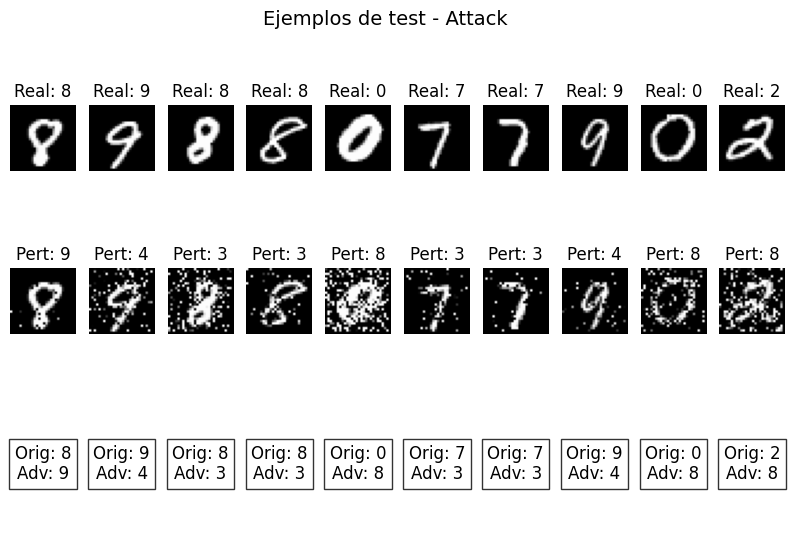

In [42]:
attack = Pixle(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [43]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 0/250 (0.00%)
Cambio de predicción en 247/250 imágenes (98.80%)


(np.float64(0.988), np.float64(0.0), np.float64(0.988))

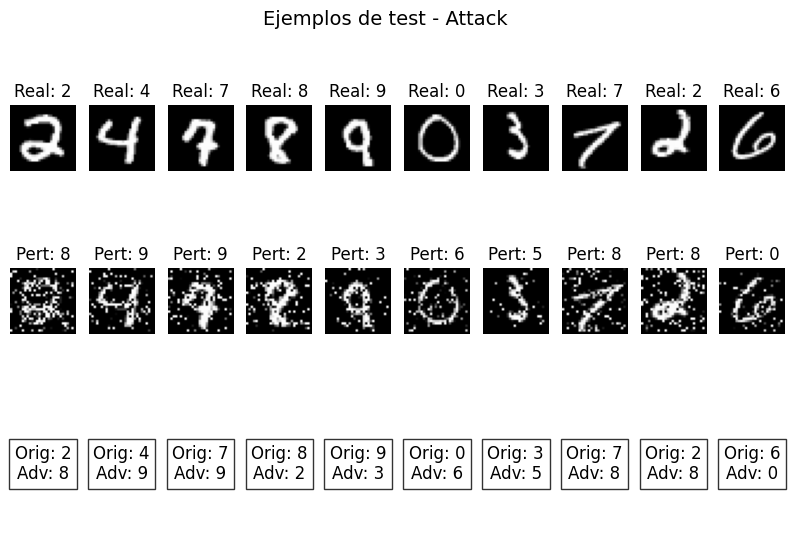

In [44]:
attack = Pixle(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [45]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 246/250 (98.40%)
Aciertos después del ataque: 0/250 (0.00%)
Cambio de predicción en 247/250 imágenes (98.80%)


(np.float64(0.984), np.float64(0.0), np.float64(0.988))

## 7. SPSA

In [47]:
"""
Code is from https://github.com/BorealisAI/advertorch/blob/master/advertorch/attacks/spsa.py
"""

import torch
from torch.nn.modules.loss import _Loss


class MarginalLoss(_Loss):
    def forward(self, logits, targets):
        assert logits.shape[-1] >= 2
        top_logits, top_classes = torch.topk(logits, 2, dim=-1)
        target_logits = logits[torch.arange(logits.shape[0]), targets]
        max_nontarget_logits = torch.where(
            top_classes[..., 0] == targets, top_logits[..., 1], top_logits[..., 0],
        )

        loss = max_nontarget_logits - target_logits
        if self.reduction == "none":
            pass
        elif self.reduction == "sum":
            loss = loss.sum()
        elif self.reduction == "mean":
            loss = loss.mean()
        else:
            raise ValueError("unknown reduction: '%s'" % (self.recution,))

        return loss


class SPSA(Attack):
    r"""
    SPSA in the paper 'Adversarial Risk and the Dangers of Evaluating Against Weak Attacks'
    [https://arxiv.org/abs/1802.05666]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        delta (float): scaling parameter of SPSA. (Default: 0.01)
        lr (float): the learning rate of the `Adam` optimizer. (Default: 0.01)
        nb_iter (int): number of iterations of the attack. (Default: 1)
        nb_sample (int): number of samples for SPSA gradient approximation. (Default: 128)
        max_batch_size (int): maximum batch size to be evaluated at once. (Default: 64)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.SPSA(model, eps=0.3)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        eps=0.3,
        delta=0.01,
        lr=0.01,
        nb_iter=1,
        nb_sample=128,
        max_batch_size=64,
    ):
        super().__init__("SPSA", model)
        self.eps = eps
        self.delta = delta
        self.lr = lr
        self.nb_iter = nb_iter
        self.nb_sample = nb_sample
        self.max_batch_size = max_batch_size
        self.loss_fn = MarginalLoss(reduction="none")
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        adv_images = self.spsa_perturb(images, labels)
        return adv_images

    def loss(self, *args):
        if self.targeted:
            return self.loss_fn(*args)
        else:
            return -self.loss_fn(*args)

    def linf_clamp_(self, dx, x, eps):
        """Clamps perturbation `dx` to fit L_inf norm and image bounds.

        Limit the L_inf norm of `dx` to be <= `eps`, and the bounds of `x + dx`
        to be in `[clip_min, clip_max]`.

        Return: the clamped perturbation `dx`.
        """

        # dx_clamped = self.batch_clamp(eps, dx)
        dx_clamped = torch.clamp(dx, min=-eps, max=eps)
        # x_adv = self.clamp(x + dx_clamped, clip_min, clip_max)
        x_adv = torch.clamp(x + dx_clamped, min=0, max=1)
        # `dx` is changed *inplace* so the optimizer will keep
        # tracking it. the simplest mechanism for inplace was
        # adding the difference between the new value `x_adv - x`
        # and the old value `dx`.
        dx += x_adv - x - dx
        return dx

    def _get_batch_sizes(self, n, max_batch_size):
        batches = [max_batch_size for _ in range(n // max_batch_size)]
        if n % max_batch_size > 0:
            batches.append(n % max_batch_size)
        return batches

    @torch.no_grad()
    def spsa_grad(self, images, labels, delta, nb_sample, max_batch_size):
        """Uses SPSA method to apprixmate gradient w.r.t `x`.

        Use the SPSA method to approximate the gradient of `loss(predict(x), y)`
        with respect to `x`, based on the nonce `v`.

        Return the approximated gradient of `loss_fn(predict(x), y)` with respect to `x`.
        """

        grad = torch.zeros_like(images)
        images = torch.unsqueeze(images, 0)
        labels = torch.unsqueeze(labels, 0)

        def f(xvar, yvar):
            return self.loss(self.get_logits(xvar), yvar)

        images = images.expand(max_batch_size, *images.shape[1:]).contiguous()
        labels = labels.expand(max_batch_size, *labels.shape[1:]).contiguous()

        v = torch.empty_like(images[:, :1, ...])
        for batch_size in self._get_batch_sizes(nb_sample, max_batch_size):
            x_ = images[:batch_size]
            y_ = labels[:batch_size]
            vb = v[:batch_size]
            vb = vb.bernoulli_().mul_(2.0).sub_(1.0)
            v_ = vb.expand_as(x_).contiguous()
            x_shape = x_.shape
            x_ = x_.view(-1, *images.shape[2:])
            y_ = y_.view(-1, *labels.shape[2:])
            v_ = v_.view(-1, *v.shape[2:])
            df = f(x_ + delta * v_, y_) - f(x_ - delta * v_, y_)
            df = df.view(-1, *[1 for _ in v_.shape[1:]])
            grad_ = df / (2.0 * delta * v_)
            grad_ = grad_.view(x_shape)
            grad_ = grad_.sum(dim=0, keepdim=False)
            grad += grad_

        grad /= nb_sample
        return grad

    def spsa_perturb(self, x, y):
        dx = torch.zeros_like(x)
        dx.grad = torch.zeros_like(dx)
        optimizer = torch.optim.Adam([dx], lr=self.lr)
        for _ in range(self.nb_iter):
            optimizer.zero_grad()
            dx.grad = self.spsa_grad(
                x + dx, y, self.delta, self.nb_sample, self.max_batch_size
            )
            optimizer.step()
            dx = self.linf_clamp_(dx, x, self.eps)

        x_adv = x + dx
        return x_adv

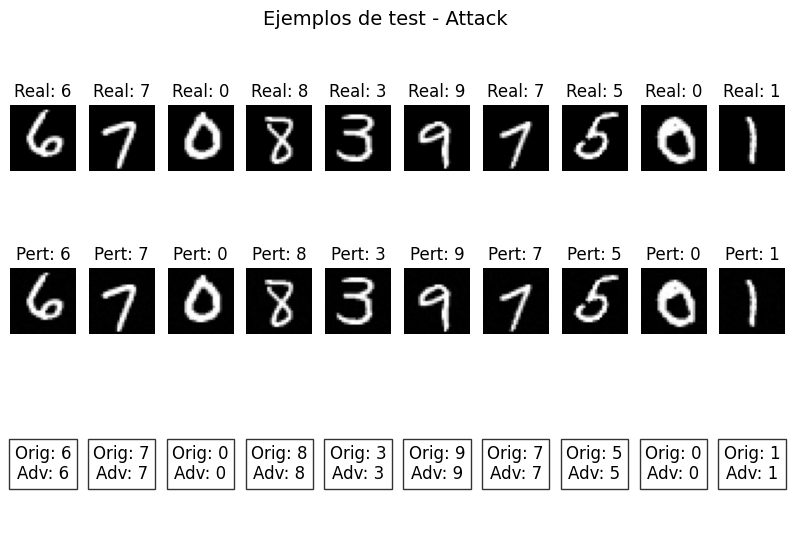

In [48]:
attack = SPSA(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [49]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 245/250 (98.00%)
Cambio de predicción en 2/250 imágenes (0.80%)


(np.float64(0.988), np.float64(0.98), np.float64(0.008))

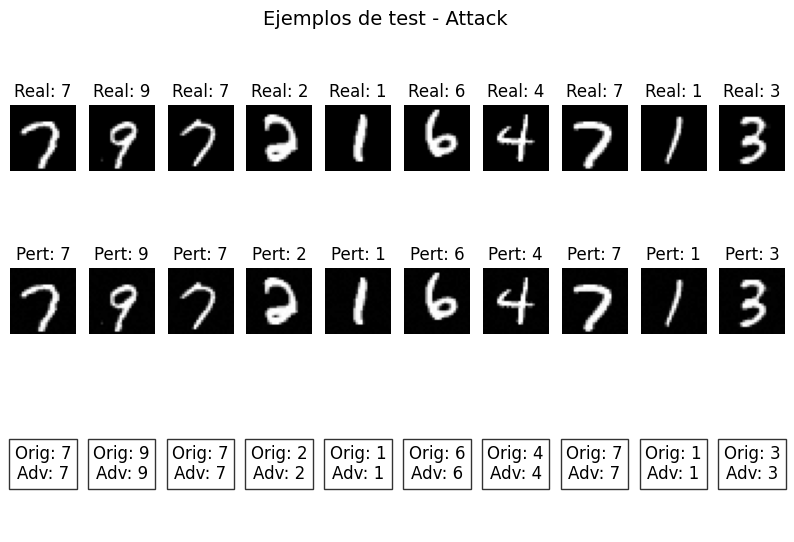

In [50]:
attack = SPSA(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [51]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 247/250 (98.80%)
Cambio de predicción en 0/250 imágenes (0.00%)


(np.float64(0.988), np.float64(0.988), np.float64(0.0))

## 8. EADEN

In [52]:
import torch
import torch.nn as nn

class EADEN(Attack):
    r"""
    EAD attack in the paper 'EAD: Elastic-Net Attacks to Deep Neural Networks'
    [https://arxiv.org/abs/1709.04114]

    Distance Measure : L1 and L2

    Arguments:
        model (nn.Module): model to attack.
        kappa (float): how strong the adversarial example should be (also written as 'confidence'). (Default: 0)
        lr (float): larger values converge faster to less accurate results. (Default: 0.01)
        binary_search_steps (int): number of times to adjust the constant with binary search. (Default: 9)
        max_iterations (int): number of iterations to perform gradient descent. (Default: 100)
        abort_early (bool): if we stop improving, abort gradient descent early. (Default: True)
        initial_const (float): the initial constant c to pick as a first guess. (Default: 0.001)
        beta (float): hyperparameter trading off L2 minimization for L1 minimization. (Default: 0.001)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.EADEN(model, kappa=0, lr=0.01, max_iterations=100)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        kappa=0,
        lr=0.01,
        binary_search_steps=9,
        max_iterations=100,
        abort_early=True,
        initial_const=0.001,
        beta=0.001,
    ):
        super().__init__("EADEN", model)
        self.kappa = kappa
        self.lr = lr
        self.binary_search_steps = binary_search_steps
        self.max_iterations = max_iterations
        self.abort_early = abort_early
        self.initial_const = initial_const
        self.beta = beta
        # The last iteration (if we run many steps) repeat the search once.
        self.repeat = binary_search_steps >= 10
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            labels = self.get_target_label(images, labels)

        outputs = self.get_logits(images)

        batch_size = images.shape[0]
        lower_bound = torch.zeros(batch_size, device=self.device)
        const = torch.ones(batch_size, device=self.device) * self.initial_const
        upper_bound = torch.ones(batch_size, device=self.device) * 1e10

        final_adv_images = images.clone()
        y_one_hot = torch.eye(outputs.shape[1]).to(self.device)[labels]

        o_bestl1 = [1e10] * batch_size
        o_bestscore = [-1] * batch_size
        o_bestl1 = torch.Tensor(o_bestl1).to(self.device)
        o_bestscore = torch.Tensor(o_bestscore).to(self.device)

        # Initialization: x^{(0)} = y^{(0)} = x_0 in paper Algorithm 1 part
        x_k = images.clone().detach()
        y_k = nn.Parameter(images)

        # Start binary search
        for outer_step in range(self.binary_search_steps):

            self.global_step = 0

            bestl1 = [1e10] * batch_size
            bestscore = [-1] * batch_size

            bestl1 = torch.Tensor(bestl1).to(self.device)
            bestscore = torch.Tensor(bestscore).to(self.device)
            prevloss = 1e6

            if self.repeat and outer_step == (self.binary_search_steps - 1):
                const = upper_bound

            lr = self.lr
            for iteration in range(self.max_iterations):
                # reset gradient
                if y_k.grad is not None:
                    y_k.grad.detach_()
                    y_k.grad.zero_()

                # Loss over images_parameters with only L2 same as CW
                # we don't update L1 loss with SGD because we use ISTA
                output = self.get_logits(y_k)
                L2_loss = self.L2_loss(y_k, images)

                cost = self.EAD_loss(output, y_one_hot, None, L2_loss, const)
                # cost.backward(retain_graph=True)
                cost.backward()

                # Gradient step
                # y_k.data.add_(-lr, y_k.grad.data)
                self.global_step += 1
                with torch.no_grad():
                    y_k -= y_k.grad * lr

                # Ploynomial decay of learning rate
                lr = (
                    self.lr * (1 - self.global_step / self.max_iterations) ** 0.5
                )  # nopep8
                x_k, y_k = self.FISTA(images, x_k, y_k)
                # Loss ElasticNet or L1 over x_k
                with torch.no_grad():
                    output = self.get_logits(x_k)
                    L2_loss = self.L2_loss(x_k, images)
                    L1_loss = self.L1_loss(x_k, images)
                    loss = self.EAD_loss(
                        output, y_one_hot, L1_loss, L2_loss, const
                    )  # nopep8

                    # print('loss: {}, prevloss: {}'.format(loss, prevloss))
                    if (
                        self.abort_early
                        and iteration % (self.max_iterations // 10) == 0
                    ):
                        if loss > prevloss * 0.999999:
                            break
                        prevloss = loss

                    # EN attack key step!
                    cost = L2_loss + (L1_loss * self.beta)
                    self.adjust_best_result(
                        x_k,
                        labels,
                        output,
                        cost,
                        bestl1,
                        bestscore,
                        o_bestl1,
                        o_bestscore,
                        final_adv_images,
                    )

            self.adjust_constant(labels, bestscore, const, upper_bound, lower_bound)

        return final_adv_images

    def L1_loss(self, x1, x2):
        Flatten = nn.Flatten()
        L1_loss = torch.abs(Flatten(x1) - Flatten(x2)).sum(dim=1)
        # L1_loss = L1.sum()
        return L1_loss

    def L2_loss(self, x1, x2):
        MSELoss = nn.MSELoss(reduction="none")
        Flatten = nn.Flatten()
        L2_loss = MSELoss(Flatten(x1), Flatten(x2)).sum(dim=1)
        # L2_loss = L2.sum()
        return L2_loss

    def EAD_loss(self, output, one_hot_labels, L1_loss, L2_loss, const):

        # Not same as CW's f function
        other = torch.max(
            (1 - one_hot_labels) * output - (one_hot_labels * 1e4), dim=1
        )[0]
        real = torch.max(one_hot_labels * output, dim=1)[0]

        if self.targeted:
            F_loss = torch.clamp((other - real), min=-self.kappa)
        else:
            F_loss = torch.clamp((real - other), min=-self.kappa)

        if isinstance(L1_loss, type(None)):
            loss = torch.sum(const * F_loss) + torch.sum(L2_loss)
        else:
            loss = (
                torch.sum(const * F_loss)
                + torch.sum(L2_loss)
                + torch.sum(self.beta * L1_loss)
            )

        return loss

    def FISTA(self, images, x_k, y_k):

        zt = self.global_step / (self.global_step + 3)

        upper = torch.clamp(y_k - self.beta, max=1)
        lower = torch.clamp(y_k + self.beta, min=0)

        diff = y_k - images
        cond1 = (diff > self.beta).float()
        cond2 = (torch.abs(diff) <= self.beta).float()
        cond3 = (diff < -self.beta).float()

        new_x_k = (cond1 * upper) + (cond2 * images) + (cond3 * lower)
        y_k.data = new_x_k + (zt * (new_x_k - x_k))
        return new_x_k, y_k

    def compare(self, output, labels):
        if len(output.shape) >= 2:
            # output is tensor
            output = output.clone().detach()
            if self.targeted:
                output[:, labels] -= self.kappa
            else:
                output[:, labels] += self.kappa
            output = torch.argmax(output, 1)
        else:
            # output is int or float
            pass

        if self.targeted:
            return output == labels
        else:
            return output != labels

    def adjust_best_result(
        self,
        adv_img,
        labels,
        output,
        cost,
        bestl1,
        bestscore,
        o_bestl1,
        o_bestscore,
        final_adv_images,
    ):
        output_label = torch.argmax(output, 1).float()
        mask = (cost < bestl1) & self.compare(output, labels)
        bestl1[mask] = cost[mask]
        bestscore[mask] = output_label[mask]

        mask = (cost < o_bestl1) & self.compare(output, labels)
        o_bestl1[mask] = cost[mask]
        o_bestscore[mask] = output_label[mask]
        final_adv_images[mask] = adv_img[mask]

    def adjust_constant(self, labels, bestscore, const, upper_bound, lower_bound):
        mask = (self.compare(bestscore, labels)) & (bestscore != -1)
        upper_bound[mask] = torch.min(upper_bound[mask], const[mask])
        lower_bound[~mask] = torch.max(lower_bound[~mask], const[~mask])  # nopep8

        mask = upper_bound < 1e9
        const[mask] = (lower_bound[mask] + upper_bound[mask]) / 2
        const[~mask] = const[~mask] * 10

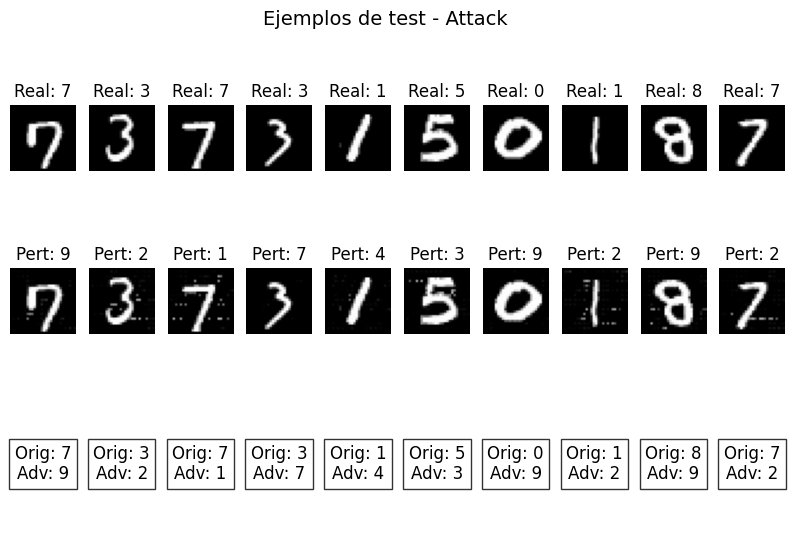

In [53]:
attack = EADEN(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [54]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 245/250 (98.00%)
Aciertos después del ataque: 0/250 (0.00%)
Cambio de predicción en 245/250 imágenes (98.00%)


(np.float64(0.98), np.float64(0.0), np.float64(0.98))

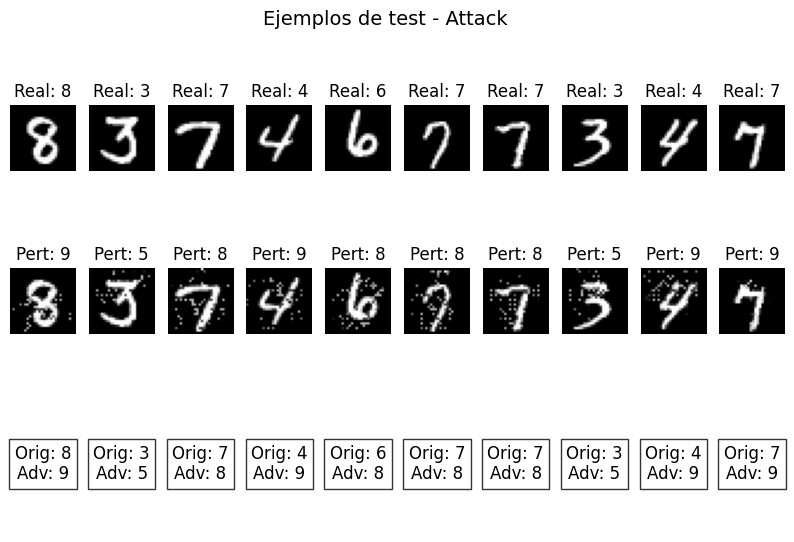

In [55]:
attack = EADEN(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [56]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 246/250 (98.40%)
Aciertos después del ataque: 0/250 (0.00%)
Cambio de predicción en 246/250 imágenes (98.40%)


(np.float64(0.984), np.float64(0.0), np.float64(0.984))

## 9. Autoattack

Multiattack

In [74]:
import torch


class MultiAttack(Attack):
    r"""
    MultiAttack is a class to attack a model with various attacks agains same images and labels.

    Arguments:
        model (nn.Module): model to attack.
        attacks (list): list of attacks.

    Examples::
        >>> atk1 = torchattacks.PGD(model, eps=8/255, alpha=2/255, iters=40, random_start=True)
        >>> atk2 = torchattacks.PGD(model, eps=8/255, alpha=2/255, iters=40, random_start=True)
        >>> atk = torchattacks.MultiAttack([atk1, atk2])
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, attacks, verbose=False):
        super().__init__("MultiAttack", attacks[0].model)
        self.attacks = attacks
        self.verbose = verbose
        self.supported_mode = ["default"]

        self.check_validity()

        self._accumulate_multi_atk_records = False
        self._multi_atk_records = [0.0]

    def check_validity(self):
        if len(self.attacks) < 2:
            raise ValueError("More than two attacks should be given.")

        ids = [id(attack.model) for attack in self.attacks]
        if len(set(ids)) != 1:
            raise ValueError(
                "At least one of attacks is referencing a different model."
            )

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        batch_size = images.shape[0]
        fails = torch.arange(batch_size).to(self.device)
        final_images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        multi_atk_records = [batch_size]

        for _, attack in enumerate(self.attacks):
            adv_images = attack(images[fails], labels[fails])

            outputs = self.get_logits(adv_images)
            _, pre = torch.max(outputs.data, 1)

            corrects = pre == labels[fails]
            wrongs = ~corrects

            succeeds = torch.masked_select(fails, wrongs)
            succeeds_of_fails = torch.masked_select(
                torch.arange(fails.shape[0]).to(self.device), wrongs
            )

            final_images[succeeds] = adv_images[succeeds_of_fails]

            fails = torch.masked_select(fails, corrects)
            multi_atk_records.append(len(fails))

            if len(fails) == 0:
                break

        if self.verbose:
            print(self._return_sr_record(multi_atk_records))

        if self._accumulate_multi_atk_records:
            self._update_multi_atk_records(multi_atk_records)

        return final_images

    def _clear_multi_atk_records(self):
        self._multi_atk_records = [0.0]

    def _covert_to_success_rates(self, multi_atk_records):
        sr = [
            ((1 - multi_atk_records[i] / multi_atk_records[0]) * 100)
            for i in range(1, len(multi_atk_records))
        ]
        return sr

    def _return_sr_record(self, multi_atk_records):
        sr = self._covert_to_success_rates(multi_atk_records)
        return "Attack success rate: " + " | ".join(["%2.2f %%" % item for item in sr])

    def _update_multi_atk_records(self, multi_atk_records):
        for i, item in enumerate(multi_atk_records):
            self._multi_atk_records[i] += item

    def save(
        self,
        data_loader,
        save_path=None,
        verbose=True,
        return_verbose=False,
        save_predictions=False,
        save_clean_images=False,
    ):
        r"""
        Overridden.
        """
        self._clear_multi_atk_records()
        prev_verbose = self.verbose
        self.verbose = False
        self._accumulate_multi_atk_records = True

        for i, attack in enumerate(self.attacks):
            self._multi_atk_records.append(0.0)

        if return_verbose:
            rob_acc, l2, elapsed_time = super().save(
                data_loader,
                save_path,
                verbose,
                return_verbose,
                save_predictions,
                save_clean_images,
            )
            sr = self._covert_to_success_rates(self._multi_atk_records)
        elif verbose:
            super().save(
                data_loader,
                save_path,
                verbose,
                return_verbose,
                save_predictions,
                save_clean_images,
            )
            sr = self._covert_to_success_rates(self._multi_atk_records)
        else:
            super().save(
                data_loader,
                save_path,
                False,
                False,
                save_predictions,
                save_clean_images,
            )

        self._clear_multi_atk_records()
        self._accumulate_multi_atk_records = False
        self.verbose = prev_verbose

        if return_verbose:
            return rob_acc, sr, l2, elapsed_time

    def _save_print(self, progress, rob_acc, l2, elapsed_time, end):
        r"""
        Overridden.
        """
        print(
            "- Save progress: %2.2f %% / Robust accuracy: %2.2f %%"
            % (progress, rob_acc)
            + " / "
            + self._return_sr_record(self._multi_atk_records)
            + " / L2: %1.5f (%2.3f it/s) \t" % (l2, elapsed_time),
            end=end,
        )

APGS

In [75]:
import time

import numpy as np

import torch
import torch.nn as nn


class APGD(Attack):
    r"""
    APGD in the paper 'Reliable evaluation of adversarial robustness with an ensemble of diverse parameter-free attacks'
    [https://arxiv.org/abs/2003.01690]
    [https://github.com/fra31/auto-attack]

    Distance Measure : Linf, L2

    Arguments:
        model (nn.Module): model to attack.
        norm (str): Lp-norm of the attack. ['Linf', 'L2'] (Default: 'Linf')
        eps (float): maximum perturbation. (Default: 8/255)
        steps (int): number of steps. (Default: 10)
        n_restarts (int): number of random restarts. (Default: 1)
        seed (int): random seed for the starting point. (Default: 0)
        loss (str): loss function optimized. ['ce', 'dlr'] (Default: 'ce')
        eot_iter (int): number of iteration for EOT. (Default: 1)
        rho (float): parameter for step-size update (Default: 0.75)
        verbose (bool): print progress. (Default: False)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.APGD(model, norm='Linf', eps=8/255, steps=10, n_restarts=1, seed=0, loss='ce', eot_iter=1, rho=.75, verbose=False)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        norm="Linf",
        eps=8 / 255,
        steps=10,
        n_restarts=1,
        seed=0,
        loss="ce",
        eot_iter=1,
        rho=0.75,
        verbose=False,
    ):
        super().__init__("APGD", model)
        self.eps = eps
        self.steps = steps
        self.norm = norm
        self.n_restarts = n_restarts
        self.seed = seed
        self.loss = loss
        self.eot_iter = eot_iter
        self.thr_decr = rho
        self.verbose = verbose
        self.supported_mode = ["default"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        _, adv_images = self.perturb(images, labels, cheap=True)

        return adv_images

    def check_oscillation(self, x, j, k, y5, k3=0.75):
        t = np.zeros(x.shape[1])
        for counter5 in range(k):
            t += x[j - counter5] > x[j - counter5 - 1]

        return t <= k * k3 * np.ones(t.shape)

    def check_shape(self, x):
        return x if len(x.shape) > 0 else np.expand_dims(x, 0)

    def dlr_loss(self, x, y):
        x_sorted, ind_sorted = x.sort(dim=1)
        ind = (ind_sorted[:, -1] == y).float()

        return -(
            x[np.arange(x.shape[0]), y]
            - x_sorted[:, -2] * ind
            - x_sorted[:, -1] * (1.0 - ind)
        ) / (x_sorted[:, -1] - x_sorted[:, -3] + 1e-12)

    def attack_single_run(self, x_in, y_in):
        x = x_in.clone() if len(x_in.shape) == 4 else x_in.clone().unsqueeze(0)
        y = y_in.clone() if len(y_in.shape) == 1 else y_in.clone().unsqueeze(0)

        self.steps_2, self.steps_min, self.size_decr = (
            max(int(0.22 * self.steps), 1),
            max(int(0.06 * self.steps), 1),
            max(int(0.03 * self.steps), 1),
        )
        if self.verbose:
            print(
                "parameters: ", self.steps, self.steps_2, self.steps_min, self.size_decr
            )

        if self.norm == "Linf":
            t = 2 * torch.rand(x.shape).to(self.device).detach() - 1
            x_adv = x.detach() + self.eps * torch.ones([x.shape[0], 1, 1, 1]).to(
                self.device
            ).detach() * t / (
                t.reshape([t.shape[0], -1])
                .abs()
                .max(dim=1, keepdim=True)[0]
                .reshape([-1, 1, 1, 1])
            )  # nopep8
        elif self.norm == "L2":
            t = torch.randn(x.shape).to(self.device).detach()
            x_adv = x.detach() + self.eps * torch.ones([x.shape[0], 1, 1, 1]).to(
                self.device
            ).detach() * t / (
                (t ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt() + 1e-12
            )  # nopep8
        x_adv = x_adv.clamp(0.0, 1.0)
        x_best = x_adv.clone()
        x_best_adv = x_adv.clone()
        loss_steps = torch.zeros([self.steps, x.shape[0]])
        loss_best_steps = torch.zeros([self.steps + 1, x.shape[0]])
        acc_steps = torch.zeros_like(loss_best_steps)

        if self.loss == "ce":
            criterion_indiv = nn.CrossEntropyLoss(reduction="none")
        elif self.loss == "dlr":
            criterion_indiv = self.dlr_loss
        else:
            raise ValueError("unknown loss")

        x_adv.requires_grad_()
        grad = torch.zeros_like(x)
        for _ in range(self.eot_iter):
            with torch.enable_grad():
                # 1 forward pass (eot_iter = 1)
                logits = self.get_logits(x_adv)
                loss_indiv = criterion_indiv(logits, y)
                loss = loss_indiv.sum()

            # 1 backward pass (eot_iter = 1)
            grad += torch.autograd.grad(loss, [x_adv])[0].detach()

        grad /= float(self.eot_iter)
        grad_best = grad.clone()

        acc = logits.detach().max(1)[1] == y
        acc_steps[0] = acc + 0
        loss_best = loss_indiv.detach().clone()

        step_size = (
            self.eps
            * torch.ones([x.shape[0], 1, 1, 1]).to(self.device).detach()
            * torch.Tensor([2.0]).to(self.device).detach().reshape([1, 1, 1, 1])
        )  # nopep8
        x_adv_old = x_adv.clone()
        counter = 0
        k = self.steps_2 + 0
        u = np.arange(x.shape[0])
        counter3 = 0

        loss_best_last_check = loss_best.clone()
        reduced_last_check = np.zeros(loss_best.shape) == np.zeros(loss_best.shape)

        # n_reduced = 0
        for i in range(self.steps):
            # gradient step
            with torch.no_grad():
                x_adv = x_adv.detach()
                grad2 = x_adv - x_adv_old
                x_adv_old = x_adv.clone()

                a = 0.75 if i > 0 else 1.0

                if self.norm == "Linf":
                    x_adv_1 = x_adv + step_size * torch.sign(grad)
                    x_adv_1 = torch.clamp(
                        torch.min(torch.max(x_adv_1, x - self.eps), x + self.eps),
                        0.0,
                        1.0,
                    )
                    x_adv_1 = torch.clamp(
                        torch.min(
                            torch.max(
                                x_adv + (x_adv_1 - x_adv) * a + grad2 * (1 - a),
                                x - self.eps,
                            ),
                            x + self.eps,
                        ),
                        0.0,
                        1.0,
                    )

                elif self.norm == "L2":
                    x_adv_1 = x_adv + step_size * grad / (
                        (grad ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt() + 1e-12
                    )  # nopep8
                    x_adv_1 = torch.clamp(
                        x
                        + (x_adv_1 - x)
                        / (
                            ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt()
                            + 1e-12
                        )
                        * torch.min(
                            self.eps * torch.ones(x.shape).to(self.device).detach(),
                            ((x_adv_1 - x) ** 2)
                            .sum(dim=(1, 2, 3), keepdim=True)
                            .sqrt(),
                        ),
                        0.0,
                        1.0,
                    )  # nopep8
                    x_adv_1 = x_adv + (x_adv_1 - x_adv) * a + grad2 * (1 - a)
                    x_adv_1 = torch.clamp(
                        x
                        + (x_adv_1 - x)
                        / (
                            ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt()
                            + 1e-12
                        )
                        * torch.min(
                            self.eps * torch.ones(x.shape).to(self.device).detach(),
                            ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt()
                            + 1e-12,
                        ),
                        0.0,
                        1.0,
                    )  # nopep8

                x_adv = x_adv_1 + 0.0

            # get gradient
            x_adv.requires_grad_()
            grad = torch.zeros_like(x)
            for _ in range(self.eot_iter):
                with torch.enable_grad():
                    # 1 forward pass (eot_iter = 1)
                    logits = self.get_logits(x_adv)
                    loss_indiv = criterion_indiv(logits, y)
                    loss = loss_indiv.sum()

                # 1 backward pass (eot_iter = 1)
                grad += torch.autograd.grad(loss, [x_adv])[0].detach()

            grad /= float(self.eot_iter)

            pred = logits.detach().max(1)[1] == y
            acc = torch.min(acc, pred)
            acc_steps[i + 1] = acc + 0
            x_best_adv[(pred == 0).nonzero().squeeze()] = (
                x_adv[(pred == 0).nonzero().squeeze()] + 0.0
            )  # nopep8
            if self.verbose:
                print("iteration: {} - Best loss: {:.6f}".format(i, loss_best.sum()))

            # check step size
            with torch.no_grad():
                y1 = loss_indiv.detach().clone()
                loss_steps[i] = y1.cpu() + 0
                ind = (y1 > loss_best).nonzero().squeeze()
                x_best[ind] = x_adv[ind].clone()
                grad_best[ind] = grad[ind].clone()
                loss_best[ind] = y1[ind] + 0
                loss_best_steps[i + 1] = loss_best + 0

                counter3 += 1

                if counter3 == k:
                    fl_oscillation = self.check_oscillation(
                        loss_steps.detach().cpu().numpy(),
                        i,
                        k,
                        loss_best.detach().cpu().numpy(),
                        k3=self.thr_decr,
                    )
                    fl_reduce_no_impr = (~reduced_last_check) * (
                        loss_best_last_check.cpu().numpy() >= loss_best.cpu().numpy()
                    )  # nopep8
                    fl_oscillation = ~(~fl_oscillation * ~fl_reduce_no_impr)
                    reduced_last_check = np.copy(fl_oscillation)
                    loss_best_last_check = loss_best.clone()

                    if np.sum(fl_oscillation) > 0:
                        step_size[u[fl_oscillation]] /= 2.0
                        n_reduced = fl_oscillation.astype(float).sum()

                        fl_oscillation = np.where(fl_oscillation)

                        x_adv[fl_oscillation] = x_best[fl_oscillation].clone()
                        grad[fl_oscillation] = grad_best[fl_oscillation].clone()

                    counter3 = 0
                    k = np.maximum(k - self.size_decr, self.steps_min)

        return x_best, acc, loss_best, x_best_adv

    def perturb(self, x_in, y_in, best_loss=False, cheap=True):
        assert self.norm in ["Linf", "L2"]
        x = x_in.clone() if len(x_in.shape) == 4 else x_in.clone().unsqueeze(0)
        y = y_in.clone() if len(y_in.shape) == 1 else y_in.clone().unsqueeze(0)

        adv = x.clone()
        acc = self.get_logits(x).max(1)[1] == y
        # loss = -1e10 * torch.ones_like(acc).float()
        if self.verbose:
            print(
                "-------------------------- running {}-attack with epsilon {:.4f} --------------------------".format(
                    self.norm, self.eps
                )
            )
            print("initial accuracy: {:.2%}".format(acc.float().mean()))
        startt = time.time()

        if not best_loss:
            torch.random.manual_seed(self.seed)
            torch.cuda.random.manual_seed(self.seed)

            if not cheap:
                raise ValueError("not implemented yet")

            else:
                for counter in range(self.n_restarts):
                    ind_to_fool = acc.nonzero().squeeze()
                    if len(ind_to_fool.shape) == 0:
                        ind_to_fool = ind_to_fool.unsqueeze(0)
                    if ind_to_fool.numel() != 0:
                        x_to_fool, y_to_fool = (
                            x[ind_to_fool].clone(),
                            y[ind_to_fool].clone(),
                        )  # nopep8
                        (
                            best_curr,
                            acc_curr,
                            loss_curr,
                            adv_curr,
                        ) = self.attack_single_run(
                            x_to_fool, y_to_fool
                        )  # nopep8
                        ind_curr = (acc_curr == 0).nonzero().squeeze()
                        #
                        acc[ind_to_fool[ind_curr]] = 0
                        adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()
                        if self.verbose:
                            print(
                                "restart {} - robust accuracy: {:.2%} - cum. time: {:.1f} s".format(
                                    counter, acc.float().mean(), time.time() - startt
                                )
                            )

            return acc, adv

        else:
            adv_best = x.detach().clone()
            loss_best = torch.ones([x.shape[0]]).to(self.device) * (
                -float("inf")
            )  # nopep8
            for counter in range(self.n_restarts):
                best_curr, _, loss_curr, _ = self.attack_single_run(x, y)
                ind_curr = (loss_curr > loss_best).nonzero().squeeze()
                adv_best[ind_curr] = best_curr[ind_curr] + 0.0
                loss_best[ind_curr] = loss_curr[ind_curr] + 0.0

                if self.verbose:
                    print("restart {} - loss: {:.5f}".format(counter, loss_best.sum()))

            return loss_best, adv_best

APGDT

In [77]:
import time

import numpy as np

import torch


class APGDT(Attack):
    r"""
    APGD-Targeted in the paper 'Reliable evaluation of adversarial robustness with an ensemble of diverse parameter-free attacks.'
    Targeted attack for every wrong classes.
    [https://arxiv.org/abs/2003.01690]
    [https://github.com/fra31/auto-attack]

    Distance Measure : Linf, L2

    Arguments:
        model (nn.Module): model to attack.
        norm (str): Lp-norm of the attack. ['Linf', 'L2'] (Default: 'Linf')
        eps (float): maximum perturbation. (Default: 8/255)
        steps (int): number of steps. (Default: 10)
        n_restarts (int): number of random restarts. (Default: 1)
        seed (int): random seed for the starting point. (Default: 0)
        eot_iter (int): number of iteration for EOT. (Default: 1)
        rho (float): parameter for step-size update (Default: 0.75)
        verbose (bool): print progress. (Default: False)
        n_classes (int): number of classes. (Default: 10)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.APGDT(model, norm='Linf', eps=8/255, steps=10, n_restarts=1, seed=0, eot_iter=1, rho=.75, verbose=False, n_classes=10)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        norm="Linf",
        eps=8 / 255,
        steps=10,
        n_restarts=1,
        seed=0,
        eot_iter=1,
        rho=0.75,
        verbose=False,
        n_classes=10,
    ):
        super().__init__("APGDT", model)
        self.eps = eps
        self.steps = steps
        self.norm = norm
        self.n_restarts = n_restarts
        self.seed = seed
        self.eot_iter = eot_iter
        self.thr_decr = rho
        self.verbose = verbose
        self.target_class = None
        self.n_target_classes = n_classes - 1
        self.supported_mode = ["default"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        _, adv_images = self.perturb(images, labels, cheap=True)

        return adv_images

    def check_oscillation(self, x, j, k, y5, k3=0.5):
        t = np.zeros(x.shape[1])
        for counter5 in range(k):
            t += x[j - counter5] > x[j - counter5 - 1]

        return t <= k * k3 * np.ones(t.shape)

    def check_shape(self, x):
        return x if len(x.shape) > 0 else np.expand_dims(x, 0)

    def dlr_loss_targeted(self, x, y, y_target):
        x_sorted, ind_sorted = x.sort(dim=1)

        return -(x[np.arange(x.shape[0]), y] - x[np.arange(x.shape[0]), y_target]) / (
            x_sorted[:, -1] - 0.5 * x_sorted[:, -3] - 0.5 * x_sorted[:, -4] + 1e-12
        )

    def attack_single_run(self, x_in, y_in):
        x = x_in.clone() if len(x_in.shape) == 4 else x_in.clone().unsqueeze(0)
        y = y_in.clone() if len(y_in.shape) == 1 else y_in.clone().unsqueeze(0)

        self.steps_2, self.steps_min, self.size_decr = (
            max(int(0.22 * self.steps), 1),
            max(int(0.06 * self.steps), 1),
            max(int(0.03 * self.steps), 1),
        )  # nopep8
        if self.verbose:
            print(
                "parameters: ", self.steps, self.steps_2, self.steps_min, self.size_decr
            )  # nopep8

        if self.norm == "Linf":
            t = 2 * torch.rand(x.shape).to(self.device).detach() - 1
            x_adv = x.detach() + self.eps * torch.ones([x.shape[0], 1, 1, 1]).to(
                self.device
            ).detach() * t / (
                t.reshape([t.shape[0], -1])
                .abs()
                .max(dim=1, keepdim=True)[0]
                .reshape([-1, 1, 1, 1])
            )  # nopep8
        elif self.norm == "L2":
            t = torch.randn(x.shape).to(self.device).detach()
            x_adv = x.detach() + self.eps * torch.ones([x.shape[0], 1, 1, 1]).to(
                self.device
            ).detach() * t / (
                (t ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt() + 1e-12
            )  # nopep8
        x_adv = x_adv.clamp(0.0, 1.0)
        x_best = x_adv.clone()
        x_best_adv = x_adv.clone()
        loss_steps = torch.zeros([self.steps, x.shape[0]])
        loss_best_steps = torch.zeros([self.steps + 1, x.shape[0]])
        acc_steps = torch.zeros_like(loss_best_steps)

        output = self.get_logits(x)
        y_target = output.sort(dim=1)[1][:, -self.target_class]

        x_adv.requires_grad_()
        grad = torch.zeros_like(x)
        for _ in range(self.eot_iter):
            with torch.enable_grad():
                # 1 forward pass (eot_iter = 1)
                logits = self.get_logits(x_adv)
                loss_indiv = self.dlr_loss_targeted(logits, y, y_target)
                loss = loss_indiv.sum()

            # 1 backward pass (eot_iter = 1)
            grad += torch.autograd.grad(loss, [x_adv])[0].detach()

        grad /= float(self.eot_iter)
        grad_best = grad.clone()

        acc = logits.detach().max(1)[1] == y
        acc_steps[0] = acc + 0
        loss_best = loss_indiv.detach().clone()

        step_size = (
            self.eps
            * torch.ones([x.shape[0], 1, 1, 1]).to(self.device).detach()
            * torch.Tensor([2.0]).to(self.device).detach().reshape([1, 1, 1, 1])
        )  # nopep8
        x_adv_old = x_adv.clone()
        # counter = 0
        k = self.steps_2 + 0
        u = np.arange(x.shape[0])
        counter3 = 0

        loss_best_last_check = loss_best.clone()
        reduced_last_check = np.zeros(loss_best.shape) == np.zeros(loss_best.shape)

        # n_reduced = 0
        for i in range(self.steps):
            # gradient step
            with torch.no_grad():
                x_adv = x_adv.detach()
                grad2 = x_adv - x_adv_old
                x_adv_old = x_adv.clone()

                a = 0.75 if i > 0 else 1.0

                if self.norm == "Linf":
                    x_adv_1 = x_adv + step_size * torch.sign(grad)
                    x_adv_1 = torch.clamp(
                        torch.min(torch.max(x_adv_1, x - self.eps), x + self.eps),
                        0.0,
                        1.0,
                    )  # nopep8
                    x_adv_1 = torch.clamp(
                        torch.min(
                            torch.max(
                                x_adv + (x_adv_1 - x_adv) * a + grad2 * (1 - a),
                                x - self.eps,
                            ),
                            x + self.eps,
                        ),
                        0.0,
                        1.0,
                    )  # nopep8

                elif self.norm == "L2":
                    x_adv_1 = x_adv + step_size[0] * grad / (
                        (grad ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt() + 1e-12
                    )  # nopep8
                    x_adv_1 = torch.clamp(
                        x
                        + (x_adv_1 - x)
                        / (
                            ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt()
                            + 1e-12
                        )
                        * torch.min(
                            self.eps * torch.ones(x.shape).to(self.device).detach(),
                            ((x_adv_1 - x) ** 2)
                            .sum(dim=(1, 2, 3), keepdim=True)
                            .sqrt(),
                        ),
                        0.0,
                        1.0,
                    )  # nopep8
                    x_adv_1 = x_adv + (x_adv_1 - x_adv) * a + grad2 * (1 - a)
                    x_adv_1 = torch.clamp(
                        x
                        + (x_adv_1 - x)
                        / (
                            ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt()
                            + 1e-12
                        )
                        * torch.min(
                            self.eps * torch.ones(x.shape).to(self.device).detach(),
                            ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt()
                            + 1e-12,
                        ),
                        0.0,
                        1.0,
                    )  # nopep8

                x_adv = x_adv_1 + 0.0

            # get gradient
            x_adv.requires_grad_()
            grad = torch.zeros_like(x)
            for _ in range(self.eot_iter):
                with torch.enable_grad():
                    # 1 forward pass (eot_iter = 1)
                    logits = self.get_logits(x_adv)
                    loss_indiv = self.dlr_loss_targeted(logits, y, y_target)
                    loss = loss_indiv.sum()

                # 1 backward pass (eot_iter = 1)
                grad += torch.autograd.grad(loss, [x_adv])[0].detach()

            grad /= float(self.eot_iter)

            pred = logits.detach().max(1)[1] == y
            acc = torch.min(acc, pred)
            acc_steps[i + 1] = acc + 0
            x_best_adv[(pred == 0).nonzero().squeeze()] = (
                x_adv[(pred == 0).nonzero().squeeze()] + 0.0
            )
            if self.verbose:
                print("iteration: {} - Best loss: {:.6f}".format(i, loss_best.sum()))

            # check step size
            with torch.no_grad():
                y1 = loss_indiv.detach().clone()
                loss_steps[i] = y1.cpu() + 0
                ind = (y1 > loss_best).nonzero().squeeze()
                x_best[ind] = x_adv[ind].clone()
                grad_best[ind] = grad[ind].clone()
                loss_best[ind] = y1[ind] + 0
                loss_best_steps[i + 1] = loss_best + 0

                counter3 += 1

                if counter3 == k:
                    fl_oscillation = self.check_oscillation(
                        loss_steps.detach().cpu().numpy(),
                        i,
                        k,
                        loss_best.detach().cpu().numpy(),
                        k3=self.thr_decr,
                    )  # nopep8
                    fl_reduce_no_impr = (~reduced_last_check) * (
                        loss_best_last_check.cpu().numpy() >= loss_best.cpu().numpy()
                    )  # nopep8
                    fl_oscillation = ~(~fl_oscillation * ~fl_reduce_no_impr)
                    reduced_last_check = np.copy(fl_oscillation)
                    loss_best_last_check = loss_best.clone()

                    if np.sum(fl_oscillation) > 0:
                        step_size[u[fl_oscillation]] /= 2.0
                        # n_reduced = fl_oscillation.astype(float).sum()

                        fl_oscillation = np.where(fl_oscillation)

                        x_adv[fl_oscillation] = x_best[fl_oscillation].clone()
                        grad[fl_oscillation] = grad_best[fl_oscillation].clone()

                    counter3 = 0
                    k = np.maximum(k - self.size_decr, self.steps_min)

        return x_best, acc, loss_best, x_best_adv

    def perturb(self, x_in, y_in, best_loss=False, cheap=True):
        assert self.norm in ["Linf", "L2"]
        x = x_in.clone() if len(x_in.shape) == 4 else x_in.clone().unsqueeze(0)
        y = y_in.clone() if len(y_in.shape) == 1 else y_in.clone().unsqueeze(0)

        adv = x.clone()
        acc = self.get_logits(x).max(1)[1] == y
        # loss = -1e10 * torch.ones_like(acc).float()
        if self.verbose:
            print(
                "-------------------------- running {}-attack with epsilon {:.4f} --------------------------".format(
                    self.norm, self.eps
                )
            )
            print("initial accuracy: {:.2%}".format(acc.float().mean()))
        startt = time.time()

        torch.random.manual_seed(self.seed)
        torch.cuda.random.manual_seed(self.seed)

        if not cheap:
            raise ValueError("not implemented yet")

        else:
            for target_class in range(2, self.n_target_classes + 2):
                self.target_class = target_class
                for counter in range(self.n_restarts):
                    ind_to_fool = acc.nonzero().squeeze()
                    if len(ind_to_fool.shape) == 0:
                        ind_to_fool = ind_to_fool.unsqueeze(0)
                    if ind_to_fool.numel() != 0:
                        x_to_fool, y_to_fool = (
                            x[ind_to_fool].clone(),
                            y[ind_to_fool].clone(),
                        )  # nopep8
                        (
                            best_curr,
                            acc_curr,
                            loss_curr,
                            adv_curr,
                        ) = self.attack_single_run(
                            x_to_fool, y_to_fool
                        )  # nopep8
                        ind_curr = (acc_curr == 0).nonzero().squeeze()

                        acc[ind_to_fool[ind_curr]] = 0
                        adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()
                        if self.verbose:
                            print(
                                "restart {} - target_class {} - robust accuracy: {:.2%} at eps = {:.5f} - cum. time: {:.1f} s".format(
                                    counter,
                                    self.target_class,
                                    acc.float().mean(),
                                    self.eps,
                                    time.time() - startt,
                                )
                            )

        return acc, adv

Square

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import time
import math

import torch
import torch.nn.functional as F

class Square(Attack):
    r"""
    Square Attack in the paper 'Square Attack: a query-efficient black-box adversarial attack via random search'
    [https://arxiv.org/abs/1912.00049]
    [https://github.com/fra31/auto-attack]

    Distance Measure : Linf, L2

    Arguments:
        model (nn.Module): model to attack.
        norm (str): Lp-norm of the attack. ['Linf', 'L2'] (Default: 'Linf')
        eps (float): maximum perturbation. (Default: 8/255)
        n_queries (int): max number of queries (each restart). (Default: 5000)
        n_restarts (int): number of random restarts. (Default: 1)
        p_init (float): parameter to control size of squares. (Default: 0.8)
        loss (str): loss function optimized ['margin', 'ce'] (Default: 'margin')
        resc_schedule (bool): adapt schedule of p to n_queries (Default: True)
        seed (int): random seed for the starting point. (Default: 0)
        verbose (bool): print progress. (Default: False)
        targeted (bool): targeted. (Default: False)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.Square(model, model, norm='Linf', eps=8/255, n_queries=5000, n_restarts=1, eps=None, p_init=.8, seed=0, verbose=False, targeted=False, loss='margin', resc_schedule=True)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        norm="Linf",
        eps=8 / 255,
        n_queries=5000,
        n_restarts=1,
        p_init=0.8,
        loss="margin",
        resc_schedule=True,
        seed=0,
        verbose=False,
    ):
        super().__init__("Square", model)
        self.norm = norm
        self.n_queries = n_queries
        self.eps = eps
        self.p_init = p_init
        self.n_restarts = n_restarts
        self.seed = seed
        self.verbose = verbose
        self.loss = loss
        self.rescale_schedule = resc_schedule
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        adv_images = self.perturb(images, labels)

        return adv_images

    def margin_and_loss(self, x, y):
        """
        :param y:        correct labels if untargeted else target labels
        """

        logits = self.get_logits(x)
        xent = F.cross_entropy(logits, y, reduction="none")
        u = torch.arange(x.shape[0])
        y_corr = logits[u, y].clone()
        logits[u, y] = -float("inf")
        y_others = logits.max(dim=-1)[0]

        if not self.targeted:
            if self.loss == "ce":
                return y_corr - y_others, -1.0 * xent
            elif self.loss == "margin":
                return y_corr - y_others, y_corr - y_others
        else:
            if self.loss == "ce":
                return y_others - y_corr, xent
            elif self.loss == "margin":
                return y_others - y_corr, y_others - y_corr

    def init_hyperparam(self, x):
        assert self.norm in ["Linf", "L2"]
        assert not self.eps is None
        assert self.loss in ["ce", "margin"]

        if self.device is None:
            self.device = x.device
        self.orig_dim = list(x.shape[1:])
        self.ndims = len(self.orig_dim)
        if self.seed is None:
            self.seed = time.time()

    def check_shape(self, x):
        return x if len(x.shape) == (self.ndims + 1) else x.unsqueeze(0)

    def random_choice(self, shape):
        t = 2 * torch.rand(shape).to(self.device) - 1
        return torch.sign(t)

    def random_int(self, low=0, high=1, shape=[1]):
        t = low + (high - low) * torch.rand(shape).to(self.device)
        return t.long()

    def normalize_delta(self, x):
        if self.norm == "Linf":
            t = x.abs().view(x.shape[0], -1).max(1)[0]
            return x / (t.view(-1, *([1] * self.ndims)) + 1e-12)

        elif self.norm == "L2":
            t = (x ** 2).view(x.shape[0], -1).sum(-1).sqrt()
            return x / (t.view(-1, *([1] * self.ndims)) + 1e-12)

    def lp_norm(self, x):
        if self.norm == "L2":
            t = (x ** 2).view(x.shape[0], -1).sum(-1).sqrt()
            return t.view(-1, *([1] * self.ndims))

    def eta_rectangles(self, x, y):
        delta = torch.zeros([x, y]).to(self.device)
        x_c, y_c = x // 2 + 1, y // 2 + 1

        counter2 = [x_c - 1, y_c - 1]
        for counter in range(0, max(x_c, y_c)):
            delta[
                max(counter2[0], 0) : min(counter2[0] + (2 * counter + 1), x),
                max(0, counter2[1]) : min(counter2[1] + (2 * counter + 1), y),
            ] += (
                1.0 / (torch.Tensor([counter + 1]).view(1, 1).to(self.device) ** 2)
            )  # nopep8
            counter2[0] -= 1
            counter2[1] -= 1

        delta /= (delta ** 2).sum(dim=(0, 1), keepdim=True).sqrt()

        return delta

    def eta(self, s):
        delta = torch.zeros([s, s]).to(self.device)
        delta[: s // 2] = self.eta_rectangles(s // 2, s)
        delta[s // 2 :] = -1.0 * self.eta_rectangles(s - s // 2, s)
        delta /= (delta ** 2).sum(dim=(0, 1), keepdim=True).sqrt()
        if torch.rand([1]) > 0.5:
            delta = delta.permute([1, 0])

        return delta

    def p_selection(self, it):
        """ schedule to decrease the parameter p """

        if self.rescale_schedule:
            it = int(it / self.n_queries * 10000)

        if 10 < it <= 50:
            p = self.p_init / 2
        elif 50 < it <= 200:
            p = self.p_init / 4
        elif 200 < it <= 500:
            p = self.p_init / 8
        elif 500 < it <= 1000:
            p = self.p_init / 16
        elif 1000 < it <= 2000:
            p = self.p_init / 32
        elif 2000 < it <= 4000:
            p = self.p_init / 64
        elif 4000 < it <= 6000:
            p = self.p_init / 128
        elif 6000 < it <= 8000:
            p = self.p_init / 256
        elif 8000 < it:
            p = self.p_init / 512
        else:
            p = self.p_init

        return p

    def attack_single_run(self, x, y):
        with torch.no_grad():
            adv = x.clone()
            c, h, w = x.shape[1:]
            n_features = c * h * w
            n_ex_total = x.shape[0]

            if self.norm == "Linf":
                x_best = torch.clamp(
                    x + self.eps * self.random_choice([x.shape[0], c, 1, w]), 0.0, 1.0
                )
                margin_min, loss_min = self.margin_and_loss(x_best, y)
                n_queries = torch.ones(x.shape[0]).to(self.device)
                s_init = int(math.sqrt(self.p_init * n_features / c))

                for i_iter in range(self.n_queries):
                    idx_to_fool = (margin_min > 0.0).nonzero().flatten()

                    if len(idx_to_fool) == 0:
                        break

                    x_curr = self.check_shape(x[idx_to_fool])
                    x_best_curr = self.check_shape(x_best[idx_to_fool])
                    y_curr = y[idx_to_fool]
                    if len(y_curr.shape) == 0:
                        y_curr = y_curr.unsqueeze(0)
                    margin_min_curr = margin_min[idx_to_fool]
                    loss_min_curr = loss_min[idx_to_fool]

                    p = self.p_selection(i_iter)
                    s = max(int(round(math.sqrt(p * n_features / c))), 1)
                    vh = self.random_int(0, h - s)
                    vw = self.random_int(0, w - s)
                    new_deltas = torch.zeros([c, h, w]).to(self.device)
                    new_deltas[:, vh : vh + s, vw : vw + s] = (
                        2.0 * self.eps * self.random_choice([c, 1, 1])
                    )

                    x_new = x_best_curr + new_deltas
                    x_new = torch.min(
                        torch.max(x_new, x_curr - self.eps), x_curr + self.eps
                    )
                    x_new = torch.clamp(x_new, 0.0, 1.0)
                    x_new = self.check_shape(x_new)

                    margin, loss = self.margin_and_loss(x_new, y_curr)

                    # update loss if new loss is better
                    idx_improved = (loss < loss_min_curr).float()

                    loss_min[idx_to_fool] = (
                        idx_improved * loss + (1.0 - idx_improved) * loss_min_curr
                    )

                    # update margin and x_best if new loss is better
                    # or misclassification
                    idx_miscl = (margin <= 0.0).float()
                    idx_improved = torch.max(idx_improved, idx_miscl)

                    margin_min[idx_to_fool] = (
                        idx_improved * margin + (1.0 - idx_improved) * margin_min_curr
                    )
                    idx_improved = idx_improved.reshape([-1, *[1] * len(x.shape[:-1])])
                    x_best[idx_to_fool] = (
                        idx_improved * x_new + (1.0 - idx_improved) * x_best_curr
                    )
                    n_queries[idx_to_fool] += 1.0

                    ind_succ = (margin_min <= 0.0).nonzero().squeeze()
                    if self.verbose and ind_succ.numel() != 0:
                        print(
                            "{}".format(i_iter + 1),
                            "- success rate={}/{} ({:.2%})".format(
                                ind_succ.numel(),
                                n_ex_total,
                                float(ind_succ.numel()) / n_ex_total,
                            ),
                            "- avg # queries={:.1f}".format(
                                n_queries[ind_succ].mean().item()
                            ),
                            "- med # queries={:.1f}".format(
                                n_queries[ind_succ].median().item()
                            ),
                            "- loss={:.3f}".format(loss_min.mean()),
                        )

                    if ind_succ.numel() == n_ex_total:
                        break

            elif self.norm == "L2":
                delta_init = torch.zeros_like(x)
                s = h // 5
                sp_init = (h - s * 5) // 2
                vh = sp_init + 0
                for _ in range(h // s):
                    vw = sp_init + 0
                    for _ in range(w // s):
                        delta_init[:, :, vh : vh + s, vw : vw + s] += self.eta(s).view(
                            1, 1, s, s
                        ) * self.random_choice([x.shape[0], c, 1, 1])
                        vw += s
                    vh += s

                x_best = torch.clamp(
                    x + self.normalize_delta(delta_init) * self.eps, 0.0, 1.0
                )
                margin_min, loss_min = self.margin_and_loss(x_best, y)
                n_queries = torch.ones(x.shape[0]).to(self.device)
                s_init = int(math.sqrt(self.p_init * n_features / c))

                for i_iter in range(self.n_queries):
                    idx_to_fool = (margin_min > 0.0).nonzero().flatten()

                    if len(idx_to_fool) == 0:
                        break

                    x_curr = self.check_shape(x[idx_to_fool])
                    x_best_curr = self.check_shape(x_best[idx_to_fool])
                    y_curr = y[idx_to_fool]
                    if len(y_curr.shape) == 0:
                        y_curr = y_curr.unsqueeze(0)
                    margin_min_curr = margin_min[idx_to_fool]
                    loss_min_curr = loss_min[idx_to_fool]

                    delta_curr = x_best_curr - x_curr
                    p = self.p_selection(i_iter)
                    s = max(int(round(math.sqrt(p * n_features / c))), 3)
                    if s % 2 == 0:
                        s += 1

                    vh = self.random_int(0, h - s)
                    vw = self.random_int(0, w - s)
                    new_deltas_mask = torch.zeros_like(x_curr)
                    new_deltas_mask[:, :, vh : vh + s, vw : vw + s] = 1.0
                    norms_window_1 = (
                        (delta_curr[:, :, vh : vh + s, vw : vw + s] ** 2)
                        .sum(dim=(-2, -1), keepdim=True)
                        .sqrt()
                    )

                    vh2 = self.random_int(0, h - s)
                    vw2 = self.random_int(0, w - s)
                    new_deltas_mask_2 = torch.zeros_like(x_curr)
                    new_deltas_mask_2[:, :, vh2 : vh2 + s, vw2 : vw2 + s] = 1.0

                    norms_image = self.lp_norm(x_best_curr - x_curr)
                    mask_image = torch.max(new_deltas_mask, new_deltas_mask_2)
                    norms_windows = self.lp_norm(delta_curr * mask_image)

                    new_deltas = torch.ones([x_curr.shape[0], c, s, s]).to(self.device)
                    new_deltas *= self.eta(s).view(1, 1, s, s) * self.random_choice(
                        [x_curr.shape[0], c, 1, 1]
                    )
                    old_deltas = delta_curr[:, :, vh : vh + s, vw : vw + s] / (
                        1e-12 + norms_window_1
                    )
                    new_deltas += old_deltas
                    new_deltas = (
                        new_deltas
                        / (
                            1e-12
                            + (new_deltas ** 2).sum(dim=(-2, -1), keepdim=True).sqrt()
                        )
                        * (
                            torch.max(
                                (self.eps * torch.ones_like(new_deltas)) ** 2
                                - norms_image ** 2,
                                torch.zeros_like(new_deltas),
                            )
                            / c
                            + norms_windows ** 2
                        ).sqrt()
                    )
                    delta_curr[:, :, vh2 : vh2 + s, vw2 : vw2 + s] = 0.0
                    delta_curr[:, :, vh : vh + s, vw : vw + s] = new_deltas + 0

                    x_new = torch.clamp(
                        x_curr + self.normalize_delta(delta_curr) * self.eps, 0.0, 1.0
                    )
                    x_new = self.check_shape(x_new)
                    norms_image = self.lp_norm(x_new - x_curr)

                    margin, loss = self.margin_and_loss(x_new, y_curr)

                    # update loss if new loss is better
                    idx_improved = (loss < loss_min_curr).float()

                    loss_min[idx_to_fool] = (
                        idx_improved * loss + (1.0 - idx_improved) * loss_min_curr
                    )

                    # update margin and x_best if new loss is better
                    # or misclassification
                    idx_miscl = (margin <= 0.0).float()
                    idx_improved = torch.max(idx_improved, idx_miscl)

                    margin_min[idx_to_fool] = (
                        idx_improved * margin + (1.0 - idx_improved) * margin_min_curr
                    )
                    idx_improved = idx_improved.reshape([-1, *[1] * len(x.shape[:-1])])
                    x_best[idx_to_fool] = (
                        idx_improved * x_new + (1.0 - idx_improved) * x_best_curr
                    )
                    n_queries[idx_to_fool] += 1.0

                    ind_succ = (margin_min <= 0.0).nonzero().squeeze()
                    if self.verbose and ind_succ.numel() != 0:
                        print(
                            "{}".format(i_iter + 1),
                            "- success rate={}/{} ({:.2%})".format(
                                ind_succ.numel(),
                                n_ex_total,
                                float(ind_succ.numel()) / n_ex_total,
                            ),
                            "- avg # queries={:.1f}".format(
                                n_queries[ind_succ].mean().item()
                            ),
                            "- med # queries={:.1f}".format(
                                n_queries[ind_succ].median().item()
                            ),
                            "- loss={:.3f}".format(loss_min.mean()),
                        )

                    assert (x_new != x_new).sum() == 0
                    assert (x_best != x_best).sum() == 0

                    if ind_succ.numel() == n_ex_total:
                        break

        return n_queries, x_best

    def perturb(self, x, y=None):
        """
        :param x:           clean images
        :param y:           untargeted attack -> clean labels,
                            if None we use the predicted labels
                            targeted attack -> target labels, if None random classes,
                            different from the predicted ones, are sampled
        """

        self.init_hyperparam(x)

        adv = x.clone()
        if y is None:
            if not self.targeted:
                with torch.no_grad():
                    output = self.get_logits(x)
                    y_pred = output.max(1)[1]
                    y = y_pred.detach().clone().long().to(self.device)
            else:
                with torch.no_grad():
                    y = self.get_target_label(x, None)
        else:
            if not self.targeted:
                y = y.detach().clone().long().to(self.device)
            else:
                y = self.get_target_label(x, y)

        if not self.targeted:
            acc = self.get_logits(x).max(1)[1] == y
        else:
            acc = self.get_logits(x).max(1)[1] != y

        startt = time.time()

        torch.random.manual_seed(self.seed)
        torch.cuda.random.manual_seed(self.seed)

        for counter in range(self.n_restarts):
            ind_to_fool = acc.nonzero().squeeze()
            if len(ind_to_fool.shape) == 0:
                ind_to_fool = ind_to_fool.unsqueeze(0)
            if ind_to_fool.numel() != 0:
                x_to_fool = x[ind_to_fool].clone()
                y_to_fool = y[ind_to_fool].clone()

                _, adv_curr = self.attack_single_run(x_to_fool, y_to_fool)

                output_curr = self.get_logits(adv_curr)
                if not self.targeted:
                    acc_curr = output_curr.max(1)[1] == y_to_fool
                else:
                    acc_curr = output_curr.max(1)[1] != y_to_fool
                ind_curr = (acc_curr == 0).nonzero().squeeze()

                acc[ind_to_fool[ind_curr]] = 0
                adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()
                if self.verbose:
                    print(
                        "restart {} - robust accuracy: {:.2%}".format(
                            counter, acc.float().mean()
                        ),
                        "- cum. time: {:.1f} s".format(time.time() - startt),
                    )

        return adv

FAB

In [78]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import time
import math

import torch
import torch.nn.functional as F

# zero_gradients deprecated in torch >= 1.9.
# zero_gradients is re-defined in the bottom of the code.
# from torch.autograd.gradcheck import zero_gradients
from collections import abc as container_abcs


class FAB(Attack):
    r"""
    Fast Adaptive Boundary Attack in the paper 'Minimally distorted Adversarial Examples with a Fast Adaptive Boundary Attack'
    [https://arxiv.org/abs/1907.02044]
    [https://github.com/fra31/auto-attack]

    Distance Measure : Linf, L2, L1

    Arguments:
        model (nn.Module): model to attack.
        norm (str) : Lp-norm to minimize. ['Linf', 'L2', 'L1'] (Default: 'Linf')
        eps (float): maximum perturbation. (Default: 8/255)
        steps (int): number of steps. (Default: 10)
        n_restarts (int): number of random restarts. (Default: 1)
        alpha_max (float): alpha_max. (Default: 0.1)
        eta (float): overshooting. (Default: 1.05)
        beta (float): backward step. (Default: 0.9)
        verbose (bool): print progress. (Default: False)
        seed (int): random seed for the starting point. (Default: 0)
        targeted (bool): targeted attack for every wrong classes. (Default: False)
        n_classes (int): number of classes. (Default: 10)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.FAB(model, norm='Linf', steps=10, eps=8/255, n_restarts=1, alpha_max=0.1, eta=1.05, beta=0.9, loss_fn=None, verbose=False, seed=0, targeted=False, n_classes=10)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        norm="Linf",
        eps=8 / 255,
        steps=10,
        n_restarts=1,
        alpha_max=0.1,
        eta=1.05,
        beta=0.9,
        verbose=False,
        seed=0,
        multi_targeted=False,
        n_classes=10,
    ):
        super().__init__("FAB", model)
        self.norm = norm
        self.n_restarts = n_restarts
        Default_EPS_DICT_BY_NORM = {"Linf": 0.3, "L2": 1.0, "L1": 5.0}
        self.eps = eps if eps is not None else Default_EPS_DICT_BY_NORM[norm]
        self.alpha_max = alpha_max
        self.eta = eta
        self.beta = beta
        self.steps = steps
        self.verbose = verbose
        self.seed = seed
        self.target_class = None
        self.multi_targeted = multi_targeted
        self.n_target_classes = n_classes - 1
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        adv_images = self.perturb(images, labels)

        return adv_images

    def _get_predicted_label(self, x):
        with torch.no_grad():
            outputs = self.get_logits(x)
        _, y = torch.max(outputs, dim=1)
        return y

    def check_shape(self, x):
        return x if len(x.shape) > 0 else x.unsqueeze(0)

    def get_diff_logits_grads_batch(self, imgs, la):
        im = imgs.clone().requires_grad_()
        with torch.enable_grad():
            y = self.get_logits(im)

        g2 = torch.zeros([y.shape[-1], *imgs.size()]).to(self.device)
        grad_mask = torch.zeros_like(y)
        for counter in range(y.shape[-1]):
            zero_gradients(im)
            grad_mask[:, counter] = 1.0
            y.backward(grad_mask, retain_graph=True)
            grad_mask[:, counter] = 0.0
            g2[counter] = im.grad.data

        g2 = torch.transpose(g2, 0, 1).detach()
        # y2 = self.get_logits(imgs).detach()
        y2 = y.detach()
        df = y2 - y2[torch.arange(imgs.shape[0]), la].unsqueeze(1)
        dg = g2 - g2[torch.arange(imgs.shape[0]), la].unsqueeze(1)
        df[torch.arange(imgs.shape[0]), la] = 1e10

        return df, dg

    def get_diff_logits_grads_batch_targeted(self, imgs, la, la_target):
        u = torch.arange(imgs.shape[0])
        im = imgs.clone().requires_grad_()
        with torch.enable_grad():
            y = self.get_logits(im)
            diffy = -(y[u, la] - y[u, la_target])
            sumdiffy = diffy.sum()

        zero_gradients(im)
        sumdiffy.backward()
        graddiffy = im.grad.data
        df = diffy.detach().unsqueeze(1)
        dg = graddiffy.unsqueeze(1)

        return df, dg

    def attack_single_run(self, x, y=None, use_rand_start=False):
        """
        :param x:    clean images
        :param y:    clean labels, if None we use the predicted labels
        """

        # self.device = x.device
        self.orig_dim = list(x.shape[1:])
        self.ndims = len(self.orig_dim)

        x = x.detach().clone().float().to(self.device)
        # assert next(self.model.parameters()).device == x.device

        y_pred = self._get_predicted_label(x)
        if y is None:
            y = y_pred.detach().clone().long().to(self.device)
        else:
            y = y.detach().clone().long().to(self.device)
        pred = y_pred == y
        corr_classified = pred.float().sum()
        if self.verbose:
            print("Clean accuracy: {:.2%}".format(pred.float().mean()))
        if pred.sum() == 0:
            return x
        pred = self.check_shape(pred.nonzero().squeeze())

        startt = time.time()
        # runs the attack only on correctly classified points
        im2 = x[pred].detach().clone()
        la2 = y[pred].detach().clone()
        if len(im2.shape) == self.ndims:
            im2 = im2.unsqueeze(0)
        bs = im2.shape[0]
        u1 = torch.arange(bs)
        adv = im2.clone()
        adv_c = x.clone()
        res2 = 1e10 * torch.ones([bs]).to(self.device)
        res_c = torch.zeros([x.shape[0]]).to(self.device)
        x1 = im2.clone()
        x0 = im2.clone().reshape([bs, -1])
        counter_restarts = 0

        while counter_restarts < 1:
            if use_rand_start:
                if self.norm == "Linf":
                    t = 2 * torch.rand(x1.shape).to(self.device) - 1
                    x1 = (
                        im2
                        + (
                            torch.min(
                                res2, self.eps * torch.ones(res2.shape).to(self.device)
                            ).reshape([-1, *[1] * self.ndims])
                        )
                        * t
                        / (
                            t.reshape([t.shape[0], -1])
                            .abs()
                            .max(dim=1, keepdim=True)[0]
                            .reshape([-1, *[1] * self.ndims])
                        )
                        * 0.5
                    )
                elif self.norm == "L2":
                    t = torch.randn(x1.shape).to(self.device)
                    x1 = (
                        im2
                        + (
                            torch.min(
                                res2, self.eps * torch.ones(res2.shape).to(self.device)
                            ).reshape([-1, *[1] * self.ndims])
                        )
                        * t
                        / (
                            (t ** 2)
                            .view(t.shape[0], -1)
                            .sum(dim=-1)
                            .sqrt()
                            .view(t.shape[0], *[1] * self.ndims)
                        )
                        * 0.5
                    )
                elif self.norm == "L1":
                    t = torch.randn(x1.shape).to(self.device)
                    x1 = (
                        im2
                        + (
                            torch.min(
                                res2, self.eps * torch.ones(res2.shape).to(self.device)
                            ).reshape([-1, *[1] * self.ndims])
                        )
                        * t
                        / (
                            t.abs()
                            .view(t.shape[0], -1)
                            .sum(dim=-1)
                            .view(t.shape[0], *[1] * self.ndims)
                        )
                        / 2
                    )

                x1 = x1.clamp(0.0, 1.0)

            counter_iter = 0
            while counter_iter < self.steps:
                with torch.no_grad():
                    df, dg = self.get_diff_logits_grads_batch(x1, la2)
                    if self.norm == "Linf":
                        dist1 = df.abs() / (
                            1e-12
                            + dg.abs().view(dg.shape[0], dg.shape[1], -1).sum(dim=-1)
                        )
                    elif self.norm == "L2":
                        dist1 = df.abs() / (
                            1e-12
                            + (dg ** 2)
                            .view(dg.shape[0], dg.shape[1], -1)
                            .sum(dim=-1)
                            .sqrt()
                        )
                    elif self.norm == "L1":
                        dist1 = df.abs() / (
                            1e-12
                            + dg.abs()
                            .reshape([df.shape[0], df.shape[1], -1])
                            .max(dim=2)[0]
                        )
                    else:
                        raise ValueError("norm not supported")
                    ind = dist1.min(dim=1)[1]
                    dg2 = dg[u1, ind]
                    b = -df[u1, ind] + (dg2 * x1).view(x1.shape[0], -1).sum(dim=-1)
                    w = dg2.reshape([bs, -1])

                    if self.norm == "Linf":
                        d3 = projection_linf(
                            torch.cat((x1.reshape([bs, -1]), x0), 0),
                            torch.cat((w, w), 0),
                            torch.cat((b, b), 0),
                        )
                    elif self.norm == "L2":
                        d3 = projection_l2(
                            torch.cat((x1.reshape([bs, -1]), x0), 0),
                            torch.cat((w, w), 0),
                            torch.cat((b, b), 0),
                        )
                    elif self.norm == "L1":
                        d3 = projection_l1(
                            torch.cat((x1.reshape([bs, -1]), x0), 0),
                            torch.cat((w, w), 0),
                            torch.cat((b, b), 0),
                        )
                    d1 = torch.reshape(d3[:bs], x1.shape)
                    d2 = torch.reshape(d3[-bs:], x1.shape)
                    if self.norm == "Linf":
                        a0 = (
                            d3.abs()
                            .max(dim=1, keepdim=True)[0]
                            .view(-1, *[1] * self.ndims)
                        )
                    elif self.norm == "L2":
                        a0 = (
                            (d3 ** 2)
                            .sum(dim=1, keepdim=True)
                            .sqrt()
                            .view(-1, *[1] * self.ndims)
                        )
                    elif self.norm == "L1":
                        a0 = (
                            d3.abs()
                            .sum(dim=1, keepdim=True)
                            .view(-1, *[1] * self.ndims)
                        )
                    a0 = torch.max(a0, 1e-8 * torch.ones(a0.shape).to(self.device))
                    a1 = a0[:bs]
                    a2 = a0[-bs:]
                    alpha = torch.min(
                        torch.max(
                            a1 / (a1 + a2), torch.zeros(a1.shape).to(self.device)
                        ),
                        self.alpha_max * torch.ones(a1.shape).to(self.device),
                    )
                    x1 = (
                        (x1 + self.eta * d1) * (1 - alpha)
                        + (im2 + d2 * self.eta) * alpha
                    ).clamp(0.0, 1.0)

                    is_adv = self._get_predicted_label(x1) != la2

                    if is_adv.sum() > 0:
                        ind_adv = is_adv.nonzero().squeeze()
                        ind_adv = self.check_shape(ind_adv)
                        if self.norm == "Linf":
                            t = (
                                (x1[ind_adv] - im2[ind_adv])
                                .reshape([ind_adv.shape[0], -1])
                                .abs()
                                .max(dim=1)[0]
                            )
                        elif self.norm == "L2":
                            t = (
                                ((x1[ind_adv] - im2[ind_adv]) ** 2)
                                .view(ind_adv.shape[0], -1)
                                .sum(dim=-1)
                                .sqrt()
                            )
                        elif self.norm == "L1":
                            t = (
                                (x1[ind_adv] - im2[ind_adv])
                                .abs()
                                .view(ind_adv.shape[0], -1)
                                .sum(dim=-1)
                            )
                        adv[ind_adv] = x1[ind_adv] * (
                            t < res2[ind_adv]
                        ).float().reshape([-1, *[1] * self.ndims]) + adv[ind_adv] * (
                            t >= res2[ind_adv]
                        ).float().reshape(
                            [-1, *[1] * self.ndims]
                        )
                        res2[ind_adv] = (
                            t * (t < res2[ind_adv]).float()
                            + res2[ind_adv] * (t >= res2[ind_adv]).float()
                        )
                        x1[ind_adv] = (
                            im2[ind_adv] + (x1[ind_adv] - im2[ind_adv]) * self.beta
                        )

                    counter_iter += 1

            counter_restarts += 1

        ind_succ = res2 < 1e10
        if self.verbose:
            print(
                "success rate: {:.0f}/{:.0f}".format(
                    ind_succ.float().sum(), corr_classified
                )
                + " (on correctly classified points) in {:.1f} s".format(
                    time.time() - startt
                )
            )

        res_c[pred] = res2 * ind_succ.float() + 1e10 * (1 - ind_succ.float())
        ind_succ = self.check_shape(ind_succ.nonzero().squeeze())
        adv_c[pred[ind_succ]] = adv[ind_succ].clone()

        return adv_c

    def attack_single_run_targeted(self, x, y=None, use_rand_start=False):
        """
        :param x:    clean images
        :param y:    clean labels, if None we use the predicted labels
        """

        if self.device is None:
            self.device = x.device
        self.orig_dim = list(x.shape[1:])
        self.ndims = len(self.orig_dim)

        x = x.detach().clone().float().to(self.device)
        # assert next(self.model.parameters()).device == x.device

        y_pred = self._get_predicted_label(x)
        if y is None:
            y = y_pred.detach().clone().long().to(self.device)
        else:
            y = y.detach().clone().long().to(self.device)
        pred = y_pred == y
        corr_classified = pred.float().sum()
        if self.verbose:
            print("Clean accuracy: {:.2%}".format(pred.float().mean()))
        if pred.sum() == 0:
            return x
        pred = self.check_shape(pred.nonzero().squeeze())

        output = self.get_logits(x)
        if self.multi_targeted:
            la_target = output.sort(dim=-1)[1][:, -self.target_class]
        else:
            la_target = self.target_class

        startt = time.time()
        # runs the attack only on correctly classified points
        im2 = x[pred].detach().clone()
        la2 = y[pred].detach().clone()
        la_target2 = la_target[pred].detach().clone()
        if len(im2.shape) == self.ndims:
            im2 = im2.unsqueeze(0)
        bs = im2.shape[0]
        u1 = torch.arange(bs)
        adv = im2.clone()
        adv_c = x.clone()
        res2 = 1e10 * torch.ones([bs]).to(self.device)
        res_c = torch.zeros([x.shape[0]]).to(self.device)
        x1 = im2.clone()
        x0 = im2.clone().reshape([bs, -1])
        counter_restarts = 0

        while counter_restarts < 1:
            if use_rand_start:
                if self.norm == "Linf":
                    t = 2 * torch.rand(x1.shape).to(self.device) - 1
                    x1 = (
                        im2
                        + (
                            torch.min(
                                res2, self.eps * torch.ones(res2.shape).to(self.device)
                            ).reshape([-1, *[1] * self.ndims])
                        )
                        * t
                        / (
                            t.reshape([t.shape[0], -1])
                            .abs()
                            .max(dim=1, keepdim=True)[0]
                            .reshape([-1, *[1] * self.ndims])
                        )
                        * 0.5
                    )
                elif self.norm == "L2":
                    t = torch.randn(x1.shape).to(self.device)
                    x1 = (
                        im2
                        + (
                            torch.min(
                                res2, self.eps * torch.ones(res2.shape).to(self.device)
                            ).reshape([-1, *[1] * self.ndims])
                        )
                        * t
                        / (
                            (t ** 2)
                            .view(t.shape[0], -1)
                            .sum(dim=-1)
                            .sqrt()
                            .view(t.shape[0], *[1] * self.ndims)
                        )
                        * 0.5
                    )
                elif self.norm == "L1":
                    t = torch.randn(x1.shape).to(self.device)
                    x1 = (
                        im2
                        + (
                            torch.min(
                                res2, self.eps * torch.ones(res2.shape).to(self.device)
                            ).reshape([-1, *[1] * self.ndims])
                        )
                        * t
                        / (
                            t.abs()
                            .view(t.shape[0], -1)
                            .sum(dim=-1)
                            .view(t.shape[0], *[1] * self.ndims)
                        )
                        / 2
                    )

                x1 = x1.clamp(0.0, 1.0)

            counter_iter = 0
            while counter_iter < self.steps:
                with torch.no_grad():
                    df, dg = self.get_diff_logits_grads_batch_targeted(
                        x1, la2, la_target2
                    )
                    if self.norm == "Linf":
                        dist1 = df.abs() / (
                            1e-12
                            + dg.abs().view(dg.shape[0], dg.shape[1], -1).sum(dim=-1)
                        )
                    elif self.norm == "L2":
                        dist1 = df.abs() / (
                            1e-12
                            + (dg ** 2)
                            .view(dg.shape[0], dg.shape[1], -1)
                            .sum(dim=-1)
                            .sqrt()
                        )
                    elif self.norm == "L1":
                        dist1 = df.abs() / (
                            1e-12
                            + dg.abs()
                            .reshape([df.shape[0], df.shape[1], -1])
                            .max(dim=2)[0]
                        )
                    else:
                        raise ValueError("norm not supported")
                    ind = dist1.min(dim=1)[1]

                    dg2 = dg[u1, ind]
                    b = -df[u1, ind] + (dg2 * x1).view(x1.shape[0], -1).sum(dim=-1)
                    w = dg2.reshape([bs, -1])

                    if self.norm == "Linf":
                        d3 = projection_linf(
                            torch.cat((x1.reshape([bs, -1]), x0), 0),
                            torch.cat((w, w), 0),
                            torch.cat((b, b), 0),
                        )
                    elif self.norm == "L2":
                        d3 = projection_l2(
                            torch.cat((x1.reshape([bs, -1]), x0), 0),
                            torch.cat((w, w), 0),
                            torch.cat((b, b), 0),
                        )
                    elif self.norm == "L1":
                        d3 = projection_l1(
                            torch.cat((x1.reshape([bs, -1]), x0), 0),
                            torch.cat((w, w), 0),
                            torch.cat((b, b), 0),
                        )
                    d1 = torch.reshape(d3[:bs], x1.shape)
                    d2 = torch.reshape(d3[-bs:], x1.shape)
                    if self.norm == "Linf":
                        a0 = (
                            d3.abs()
                            .max(dim=1, keepdim=True)[0]
                            .view(-1, *[1] * self.ndims)
                        )
                    elif self.norm == "L2":
                        a0 = (
                            (d3 ** 2)
                            .sum(dim=1, keepdim=True)
                            .sqrt()
                            .view(-1, *[1] * self.ndims)
                        )
                    elif self.norm == "L1":
                        a0 = (
                            d3.abs()
                            .sum(dim=1, keepdim=True)
                            .view(-1, *[1] * self.ndims)
                        )
                    a0 = torch.max(a0, 1e-8 * torch.ones(a0.shape).to(self.device))
                    a1 = a0[:bs]
                    a2 = a0[-bs:]
                    alpha = torch.min(
                        torch.max(
                            a1 / (a1 + a2), torch.zeros(a1.shape).to(self.device)
                        ),
                        self.alpha_max * torch.ones(a1.shape).to(self.device),
                    )
                    x1 = (
                        (x1 + self.eta * d1) * (1 - alpha)
                        + (im2 + d2 * self.eta) * alpha
                    ).clamp(0.0, 1.0)

                    is_adv = self._get_predicted_label(x1) != la2

                    if is_adv.sum() > 0:
                        ind_adv = is_adv.nonzero().squeeze()
                        ind_adv = self.check_shape(ind_adv)
                        if self.norm == "Linf":
                            t = (
                                (x1[ind_adv] - im2[ind_adv])
                                .reshape([ind_adv.shape[0], -1])
                                .abs()
                                .max(dim=1)[0]
                            )
                        elif self.norm == "L2":
                            t = (
                                ((x1[ind_adv] - im2[ind_adv]) ** 2)
                                .view(ind_adv.shape[0], -1)
                                .sum(dim=-1)
                                .sqrt()
                            )
                        elif self.norm == "L1":
                            t = (
                                (x1[ind_adv] - im2[ind_adv])
                                .abs()
                                .view(ind_adv.shape[0], -1)
                                .sum(dim=-1)
                            )
                        adv[ind_adv] = x1[ind_adv] * (
                            t < res2[ind_adv]
                        ).float().reshape([-1, *[1] * self.ndims]) + adv[ind_adv] * (
                            t >= res2[ind_adv]
                        ).float().reshape(
                            [-1, *[1] * self.ndims]
                        )
                        res2[ind_adv] = (
                            t * (t < res2[ind_adv]).float()
                            + res2[ind_adv] * (t >= res2[ind_adv]).float()
                        )
                        x1[ind_adv] = (
                            im2[ind_adv] + (x1[ind_adv] - im2[ind_adv]) * self.beta
                        )

                    counter_iter += 1

            counter_restarts += 1

        ind_succ = res2 < 1e10
        if self.verbose:
            print(
                "success rate: {:.0f}/{:.0f}".format(
                    ind_succ.float().sum(), corr_classified
                )
                + " (on correctly classified points) in {:.1f} s".format(
                    time.time() - startt
                )
            )

        res_c[pred] = res2 * ind_succ.float() + 1e10 * (1 - ind_succ.float())
        ind_succ = self.check_shape(ind_succ.nonzero().squeeze())
        adv_c[pred[ind_succ]] = adv[ind_succ].clone()

        return adv_c

    def perturb(self, x, y):
        adv = x.clone()
        with torch.no_grad():
            acc = self.get_logits(x).max(1)[1] == y

            startt = time.time()

            torch.random.manual_seed(self.seed)
            torch.cuda.random.manual_seed(self.seed)

            def inner_perturb(targeted):
                for counter in range(self.n_restarts):
                    ind_to_fool = acc.nonzero().squeeze()
                    if len(ind_to_fool.shape) == 0:
                        ind_to_fool = ind_to_fool.unsqueeze(0)
                    if ind_to_fool.numel() != 0:
                        x_to_fool, y_to_fool = (
                            x[ind_to_fool].clone(),
                            y[ind_to_fool].clone(),
                        )  # nopep8

                        if targeted:
                            adv_curr = self.attack_single_run_targeted(
                                x_to_fool, y_to_fool, use_rand_start=(counter > 0)
                            )
                        else:
                            adv_curr = self.attack_single_run(
                                x_to_fool, y_to_fool, use_rand_start=(counter > 0)
                            )

                        acc_curr = self.get_logits(adv_curr).max(1)[1] == y_to_fool
                        if self.norm == "Linf":
                            res = (
                                (x_to_fool - adv_curr)
                                .abs()
                                .view(x_to_fool.shape[0], -1)
                                .max(1)[0]
                            )  # nopep8
                        elif self.norm == "L2":
                            res = (
                                ((x_to_fool - adv_curr) ** 2)
                                .view(x_to_fool.shape[0], -1)
                                .sum(dim=-1)
                                .sqrt()
                            )  # nopep8
                        acc_curr = torch.max(acc_curr, res > self.eps)

                        ind_curr = (acc_curr == 0).nonzero().squeeze()
                        acc[ind_to_fool[ind_curr]] = 0
                        adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()

                        if self.verbose:
                            if targeted:
                                print(
                                    "restart {} - target_class {} - robust accuracy: {:.2%} at eps = {:.5f} - cum. time: {:.1f} s".format(
                                        counter,
                                        self.target_class,
                                        acc.float().mean(),
                                        self.eps,
                                        time.time() - startt,
                                    )
                                )
                            else:
                                print(
                                    "restart {} - robust accuracy: {:.2%} at eps = {:.5f} - cum. time: {:.1f} s".format(
                                        counter,
                                        acc.float().mean(),
                                        self.eps,
                                        time.time() - startt,
                                    )
                                )

            if self.multi_targeted:
                for target_class in range(2, self.n_target_classes + 2):
                    self.target_class = target_class
                    inner_perturb(targeted=True)
            elif self.targeted:
                self.target_class = self.get_target_label(x, y)
                inner_perturb(targeted=True)
            else:
                inner_perturb(targeted=False)
        return adv


def projection_linf(points_to_project, w_hyperplane, b_hyperplane):
    device = points_to_project.device
    t, w, b = points_to_project, w_hyperplane.clone(), b_hyperplane.clone()

    sign = 2 * ((w * t).sum(1) - b >= 0) - 1
    w.mul_(sign.unsqueeze(1))
    b.mul_(sign)

    a = (w < 0).float()
    d = (a - t) * (w != 0).float()

    p = a - t * (2 * a - 1)
    indp = torch.argsort(p, dim=1)

    b = b - (w * t).sum(1)
    b0 = (w * d).sum(1)

    indp2 = indp.flip((1,))
    ws = w.gather(1, indp2)
    bs2 = -ws * d.gather(1, indp2)

    s = torch.cumsum(ws.abs(), dim=1)
    sb = torch.cumsum(bs2, dim=1) + b0.unsqueeze(1)

    b2 = sb[:, -1] - s[:, -1] * p.gather(1, indp[:, 0:1]).squeeze(1)
    c_l = b - b2 > 0
    c2 = (b - b0 > 0) & (~c_l)
    lb = torch.zeros(c2.sum(), device=device)
    ub = torch.full_like(lb, w.shape[1] - 1)
    nitermax = math.ceil(math.log2(w.shape[1]))

    indp_, sb_, s_, p_, b_ = indp[c2], sb[c2], s[c2], p[c2], b[c2]
    for counter in range(nitermax):
        counter4 = torch.floor((lb + ub) / 2)

        counter2 = counter4.long().unsqueeze(1)
        indcurr = indp_.gather(1, indp_.size(1) - 1 - counter2)
        b2 = (
            sb_.gather(1, counter2) - s_.gather(1, counter2) * p_.gather(1, indcurr)
        ).squeeze(
            1
        )  # nopep8
        c = b_ - b2 > 0

        lb = torch.where(c, counter4, lb)
        ub = torch.where(c, ub, counter4)

    lb = lb.long()

    if c_l.any():
        lmbd_opt = torch.clamp_min(
            (b[c_l] - sb[c_l, -1]) / (-s[c_l, -1]), min=0
        ).unsqueeze(-1)
        d[c_l] = (2 * a[c_l] - 1) * lmbd_opt

    lmbd_opt = torch.clamp_min((b[c2] - sb[c2, lb]) / (-s[c2, lb]), min=0).unsqueeze(-1)
    d[c2] = torch.min(lmbd_opt, d[c2]) * a[c2] + torch.max(-lmbd_opt, d[c2]) * (
        1 - a[c2]
    )

    return d * (w != 0).float()


def projection_l2(points_to_project, w_hyperplane, b_hyperplane):
    device = points_to_project.device
    t, w, b = points_to_project, w_hyperplane.clone(), b_hyperplane

    c = (w * t).sum(1) - b
    ind2 = 2 * (c >= 0) - 1
    w.mul_(ind2.unsqueeze(1))
    c.mul_(ind2)

    r = torch.max(t / w, (t - 1) / w).clamp(min=-1e12, max=1e12)
    r.masked_fill_(w.abs() < 1e-8, 1e12)
    r[r == -1e12] *= -1
    rs, indr = torch.sort(r, dim=1)
    rs2 = F.pad(rs[:, 1:], (0, 1))
    rs.masked_fill_(rs == 1e12, 0)
    rs2.masked_fill_(rs2 == 1e12, 0)

    w3s = (w ** 2).gather(1, indr)
    w5 = w3s.sum(dim=1, keepdim=True)
    ws = w5 - torch.cumsum(w3s, dim=1)
    d = -(r * w)
    d.mul_((w.abs() > 1e-8).float())
    s = torch.cat(
        (-w5 * rs[:, 0:1], torch.cumsum((-rs2 + rs) * ws, dim=1) - w5 * rs[:, 0:1]), 1
    )

    c4 = s[:, 0] + c < 0
    c3 = (d * w).sum(dim=1) + c > 0
    c2 = ~(c4 | c3)

    lb = torch.zeros(c2.sum(), device=device)
    ub = torch.full_like(lb, w.shape[1] - 1)
    nitermax = math.ceil(math.log2(w.shape[1]))

    s_, c_ = s[c2], c[c2]
    for counter in range(nitermax):
        counter4 = torch.floor((lb + ub) / 2)
        counter2 = counter4.long().unsqueeze(1)
        c3 = s_.gather(1, counter2).squeeze(1) + c_ > 0
        lb = torch.where(c3, counter4, lb)
        ub = torch.where(c3, ub, counter4)

    lb = lb.long()

    if c4.any():
        alpha = c[c4] / w5[c4].squeeze(-1)
        d[c4] = -alpha.unsqueeze(-1) * w[c4]

    if c2.any():
        alpha = (s[c2, lb] + c[c2]) / ws[c2, lb] + rs[c2, lb]
        alpha[ws[c2, lb] == 0] = 0
        c5 = (alpha.unsqueeze(-1) > r[c2]).float()
        d[c2] = d[c2] * c5 - alpha.unsqueeze(-1) * w[c2] * (1 - c5)

    return d * (w.abs() > 1e-8).float()


def projection_l1(points_to_project, w_hyperplane, b_hyperplane):
    device = points_to_project.device
    t, w, b = points_to_project, w_hyperplane.clone(), b_hyperplane

    c = (w * t).sum(1) - b
    ind2 = 2 * (c >= 0) - 1
    w.mul_(ind2.unsqueeze(1))
    c.mul_(ind2)

    r = (1 / w).abs().clamp_max(1e12)
    indr = torch.argsort(r, dim=1)
    indr_rev = torch.argsort(indr)

    c6 = (w < 0).float()
    d = (-t + c6) * (w != 0).float()
    ds = torch.min(-w * t, w * (1 - t)).gather(1, indr)
    ds2 = torch.cat((c.unsqueeze(-1), ds), 1)
    s = torch.cumsum(ds2, dim=1)

    c2 = s[:, -1] < 0

    lb = torch.zeros(c2.sum(), device=device)
    ub = torch.full_like(lb, s.shape[1])
    nitermax = math.ceil(math.log2(w.shape[1]))

    s_ = s[c2]
    for counter in range(nitermax):
        counter4 = torch.floor((lb + ub) / 2)
        counter2 = counter4.long().unsqueeze(1)
        c3 = s_.gather(1, counter2).squeeze(1) > 0
        lb = torch.where(c3, counter4, lb)
        ub = torch.where(c3, ub, counter4)

    lb2 = lb.long()

    if c2.any():
        indr = indr[c2].gather(1, lb2.unsqueeze(1)).squeeze(1)
        u = torch.arange(0, w.shape[0], device=device).unsqueeze(1)
        u2 = torch.arange(0, w.shape[1], device=device, dtype=torch.float).unsqueeze(0)
        alpha = -s[c2, lb2] / w[c2, indr]
        c5 = u2 < lb.unsqueeze(-1)
        u3 = c5[u[: c5.shape[0]], indr_rev[c2]]
        d[c2] = d[c2] * u3.float()
        d[c2, indr] = alpha

    return d * (w.abs() > 1e-8).float()


def zero_gradients(x):
    if isinstance(x, torch.Tensor):
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()
    elif isinstance(x, container_abcs.Iterable):
        for elem in x:
            zero_gradients(elem)

In [79]:
import time



class AutoAttack(Attack):
    r"""
    AutoAttack in the paper 'Reliable evaluation of adversarial robustness with an ensemble of diverse parameter-free attacks'
    [https://arxiv.org/abs/2003.01690]
    [https://github.com/fra31/auto-attack]

    Distance Measure : Linf, L2

    Arguments:
        model (nn.Module): model to attack.
        norm (str) : Lp-norm to minimize. ['Linf', 'L2'] (Default: 'Linf')
        eps (float): maximum perturbation. (Default: 0.3)
        version (bool): version. ['standard', 'plus', 'rand'] (Default: 'standard')
        n_classes (int): number of classes. (Default: 10)
        seed (int): random seed for the starting point. (Default: 0)
        verbose (bool): print progress. (Default: False)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.AutoAttack(model, norm='Linf', eps=8/255, version='standard', n_classes=10, seed=None, verbose=False)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        norm="Linf",
        eps=8 / 255,
        version="standard",
        n_classes=10,
        seed=None,
        verbose=False,
    ):
        super().__init__("AutoAttack", model)
        self.norm = norm
        self.eps = eps
        self.version = version
        self.n_classes = n_classes
        self.seed = seed
        self.verbose = verbose
        self.supported_mode = ["default"]

        if version == "standard":  # ['apgd-ce', 'apgd-t', 'fab-t', 'square']
            self._autoattack = MultiAttack(
                [
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="ce",
                        n_restarts=1,
                    ),
                    APGDT(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_classes=n_classes,
                        n_restarts=1,
                    ),
                    FAB(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        multi_targeted=True,
                        n_classes=n_classes,
                        n_restarts=1,
                    ),
                    Square(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_queries=5000,
                        n_restarts=1,
                    ),
                ]
            )

        # ['apgd-ce', 'apgd-dlr', 'fab', 'square', 'apgd-t', 'fab-t']
        elif version == "plus":
            self._autoattack = MultiAttack(
                [
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="ce",
                        n_restarts=5,
                    ),
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="dlr",
                        n_restarts=5,
                    ),
                    FAB(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_classes=n_classes,
                        n_restarts=5,
                    ),
                    Square(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_queries=5000,
                        n_restarts=1,
                    ),
                    APGDT(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_classes=n_classes,
                        n_restarts=1,
                    ),
                    FAB(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        multi_targeted=True,
                        n_classes=n_classes,
                        n_restarts=1,
                    ),
                ]
            )

        elif version == "rand":  # ['apgd-ce', 'apgd-dlr']
            self._autoattack = MultiAttack(
                [
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="ce",
                        eot_iter=20,
                        n_restarts=1,
                    ),
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="dlr",
                        eot_iter=20,
                        n_restarts=1,
                    ),
                ]
            )

        else:
            raise ValueError("Not valid version. ['standard', 'plus', 'rand']")

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        adv_images = self._autoattack(images, labels)

        return adv_images

    def get_seed(self):
        return time.time() if self.seed is None else self.seed

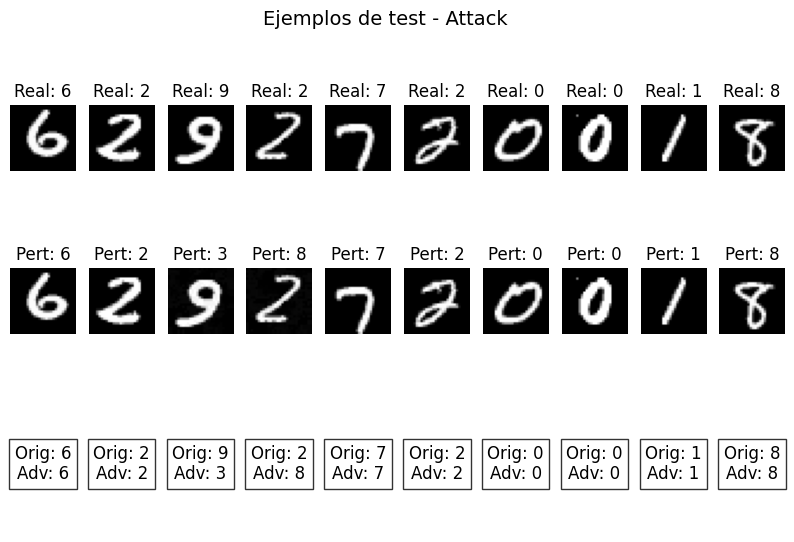

In [80]:
attack = AutoAttack(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [81]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 245/250 (98.00%)
Aciertos después del ataque: 168/250 (67.20%)
Cambio de predicción en 77/250 imágenes (30.80%)


(np.float64(0.98), np.float64(0.672), np.float64(0.308))

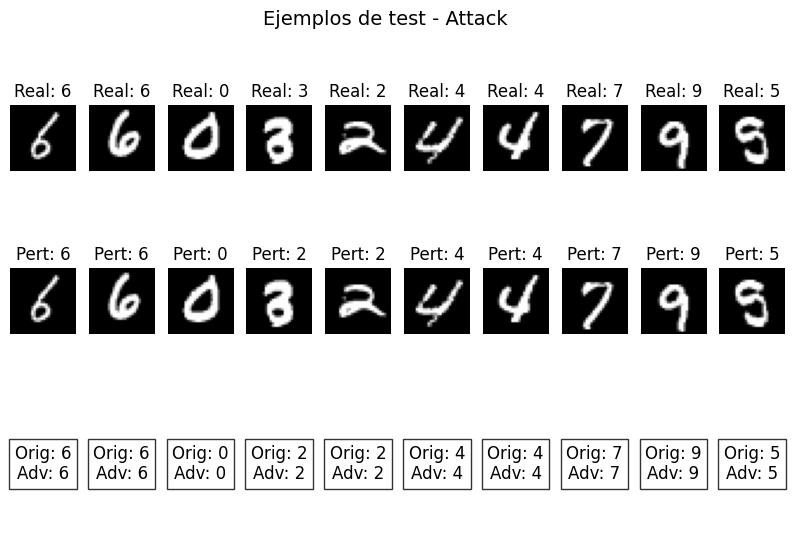

In [82]:
attack = AutoAttack(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [83]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 248/250 (99.20%)
Aciertos después del ataque: 247/250 (98.80%)
Cambio de predicción en 1/250 imágenes (0.40%)


(np.float64(0.992), np.float64(0.988), np.float64(0.004))

## 10. VMIFGSM

In [84]:
import torch
import torch.nn as nn


class VMIFGSM(Attack):
    r"""
    VMI-FGSM in the paper 'Enhancing the Transferability of Adversarial Attacks through Variance Tuning
    [https://arxiv.org/abs/2103.15571], Published as a conference paper at CVPR 2021
    Modified from "https://github.com/JHL-HUST/VT"

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        steps (int): number of iterations. (Default: 10)
        alpha (float): step size. (Default: 2/255)
        decay (float): momentum factor. (Default: 1.0)
        N (int): the number of sampled examples in the neighborhood. (Default: 5)
        beta (float): the upper bound of neighborhood. (Default: 3/2)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.VMIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=1.0, N=5, beta=3/2)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self, model, eps=8 / 255, alpha=2 / 255, steps=10, decay=1.0, N=5, beta=3 / 2
    ):
        super().__init__("VMIFGSM", model)
        self.eps = eps
        self.steps = steps
        self.decay = decay
        self.alpha = alpha
        self.N = N
        self.beta = beta
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        momentum = torch.zeros_like(images).detach().to(self.device)
        v = torch.zeros_like(images).detach().to(self.device)
        loss = nn.CrossEntropyLoss()
        adv_images = images.clone().detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            adv_grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]

            grad = (adv_grad + v) / torch.mean(
                torch.abs(adv_grad + v), dim=(1, 2, 3), keepdim=True
            )
            grad = grad + momentum * self.decay
            momentum = grad

            # Calculate Gradient Variance
            GV_grad = torch.zeros_like(images).detach().to(self.device)
            for _ in range(self.N):
                neighbor_images = adv_images.detach() + torch.randn_like(
                    images
                ).uniform_(-self.eps * self.beta, self.eps * self.beta)
                neighbor_images.requires_grad = True
                outputs = self.get_logits(neighbor_images)

                # Calculate loss
                if self.targeted:
                    cost = -loss(outputs, target_labels)
                else:
                    cost = loss(outputs, labels)
                GV_grad += torch.autograd.grad(
                    cost, neighbor_images, retain_graph=False, create_graph=False
                )[0]
            # obtaining the gradient variance
            v = GV_grad / self.N - adv_grad

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

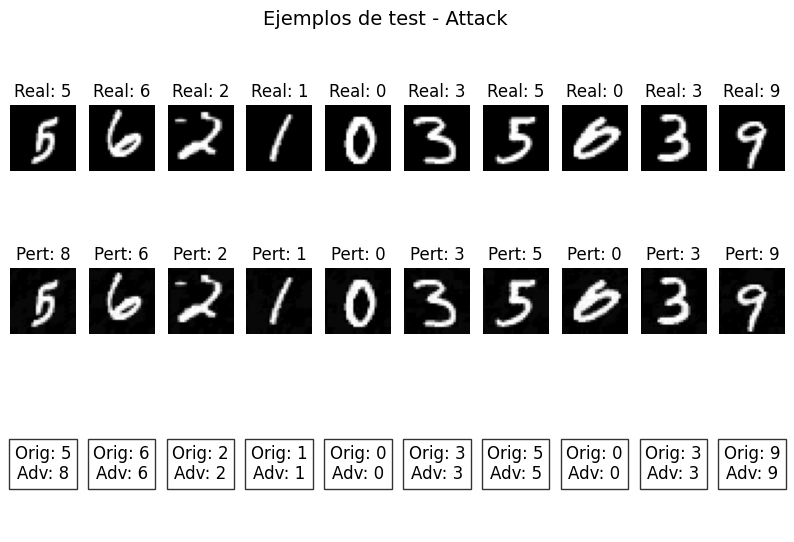

In [89]:
attack = VMIFGSM(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [90]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 242/250 (96.80%)
Aciertos después del ataque: 204/250 (81.60%)
Cambio de predicción en 39/250 imágenes (15.60%)


(np.float64(0.968), np.float64(0.816), np.float64(0.156))

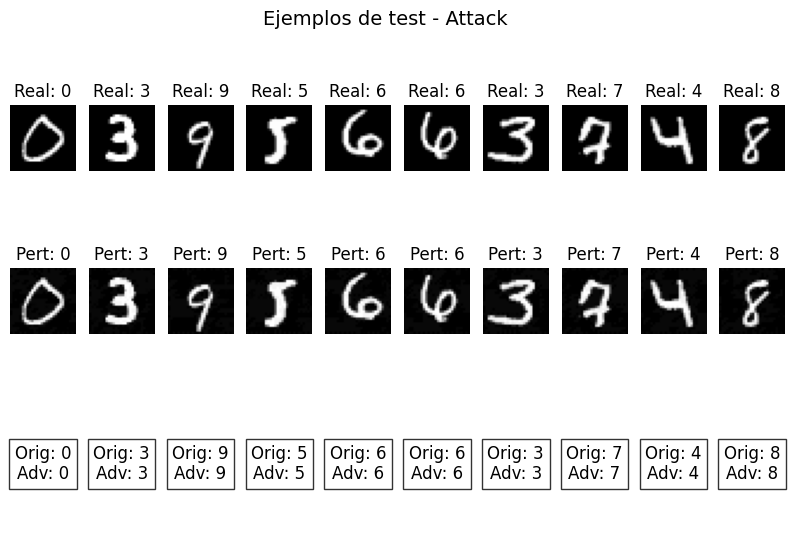

In [91]:
attack = VMIFGSM(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [92]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 246/250 (98.40%)
Aciertos después del ataque: 246/250 (98.40%)
Cambio de predicción en 0/250 imágenes (0.00%)


(np.float64(0.984), np.float64(0.984), np.float64(0.0))

## 11. Vanila

In [57]:
class VANILA(Attack):
    r"""
    Vanila version of Attack.
    It just returns the input images.

    Arguments:
        model (nn.Module): model to attack.

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.VANILA(model)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model):
        super().__init__("VANILA", model)
        self.supported_mode = ["default"]

    def forward(self, images, labels=None):
        r"""
        Overridden.
        """

        adv_images = images.clone().detach().to(self.device)

        return adv_images

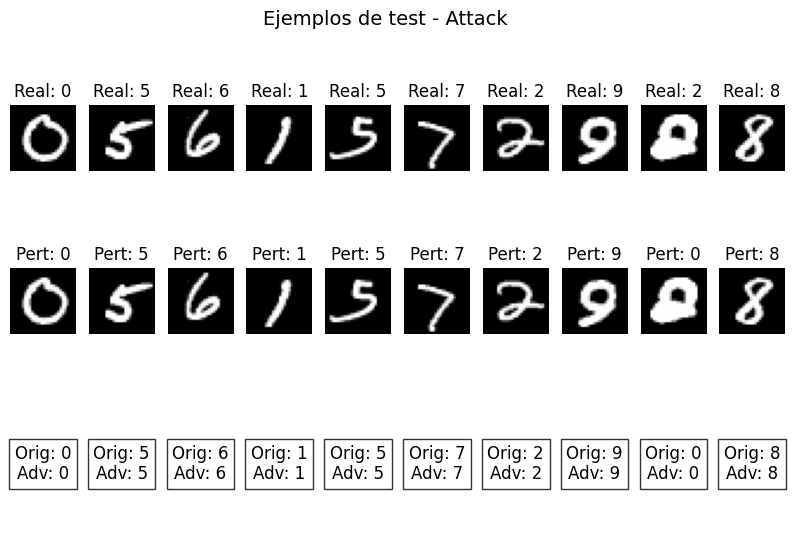

In [58]:
attack = VANILA(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [59]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 246/250 (98.40%)
Aciertos después del ataque: 246/250 (98.40%)
Cambio de predicción en 0/250 imágenes (0.00%)


(np.float64(0.984), np.float64(0.984), np.float64(0.0))

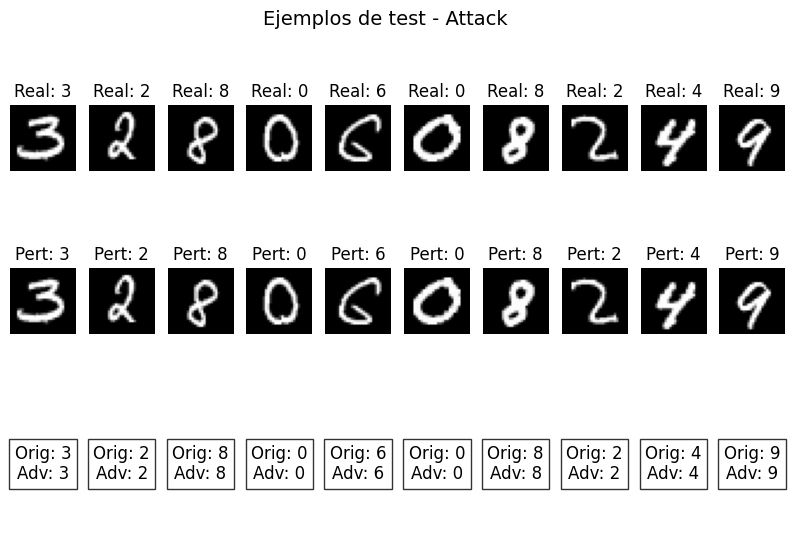

In [60]:
attack = VANILA(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [61]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 247/250 (98.80%)
Cambio de predicción en 0/250 imágenes (0.00%)


(np.float64(0.988), np.float64(0.988), np.float64(0.0))

## 12. Square

In [62]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import time
import math

import torch
import torch.nn.functional as F

class Square(Attack):
    r"""
    Square Attack in the paper 'Square Attack: a query-efficient black-box adversarial attack via random search'
    [https://arxiv.org/abs/1912.00049]
    [https://github.com/fra31/auto-attack]

    Distance Measure : Linf, L2

    Arguments:
        model (nn.Module): model to attack.
        norm (str): Lp-norm of the attack. ['Linf', 'L2'] (Default: 'Linf')
        eps (float): maximum perturbation. (Default: 8/255)
        n_queries (int): max number of queries (each restart). (Default: 5000)
        n_restarts (int): number of random restarts. (Default: 1)
        p_init (float): parameter to control size of squares. (Default: 0.8)
        loss (str): loss function optimized ['margin', 'ce'] (Default: 'margin')
        resc_schedule (bool): adapt schedule of p to n_queries (Default: True)
        seed (int): random seed for the starting point. (Default: 0)
        verbose (bool): print progress. (Default: False)
        targeted (bool): targeted. (Default: False)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.Square(model, model, norm='Linf', eps=8/255, n_queries=5000, n_restarts=1, eps=None, p_init=.8, seed=0, verbose=False, targeted=False, loss='margin', resc_schedule=True)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        norm="Linf",
        eps=8 / 255,
        n_queries=5000,
        n_restarts=1,
        p_init=0.8,
        loss="margin",
        resc_schedule=True,
        seed=0,
        verbose=False,
    ):
        super().__init__("Square", model)
        self.norm = norm
        self.n_queries = n_queries
        self.eps = eps
        self.p_init = p_init
        self.n_restarts = n_restarts
        self.seed = seed
        self.verbose = verbose
        self.loss = loss
        self.rescale_schedule = resc_schedule
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        adv_images = self.perturb(images, labels)

        return adv_images

    def margin_and_loss(self, x, y):
        """
        :param y:        correct labels if untargeted else target labels
        """

        logits = self.get_logits(x)
        xent = F.cross_entropy(logits, y, reduction="none")
        u = torch.arange(x.shape[0])
        y_corr = logits[u, y].clone()
        logits[u, y] = -float("inf")
        y_others = logits.max(dim=-1)[0]

        if not self.targeted:
            if self.loss == "ce":
                return y_corr - y_others, -1.0 * xent
            elif self.loss == "margin":
                return y_corr - y_others, y_corr - y_others
        else:
            if self.loss == "ce":
                return y_others - y_corr, xent
            elif self.loss == "margin":
                return y_others - y_corr, y_others - y_corr

    def init_hyperparam(self, x):
        assert self.norm in ["Linf", "L2"]
        assert not self.eps is None
        assert self.loss in ["ce", "margin"]

        if self.device is None:
            self.device = x.device
        self.orig_dim = list(x.shape[1:])
        self.ndims = len(self.orig_dim)
        if self.seed is None:
            self.seed = time.time()

    def check_shape(self, x):
        return x if len(x.shape) == (self.ndims + 1) else x.unsqueeze(0)

    def random_choice(self, shape):
        t = 2 * torch.rand(shape).to(self.device) - 1
        return torch.sign(t)

    def random_int(self, low=0, high=1, shape=[1]):
        t = low + (high - low) * torch.rand(shape).to(self.device)
        return t.long()

    def normalize_delta(self, x):
        if self.norm == "Linf":
            t = x.abs().view(x.shape[0], -1).max(1)[0]
            return x / (t.view(-1, *([1] * self.ndims)) + 1e-12)

        elif self.norm == "L2":
            t = (x ** 2).view(x.shape[0], -1).sum(-1).sqrt()
            return x / (t.view(-1, *([1] * self.ndims)) + 1e-12)

    def lp_norm(self, x):
        if self.norm == "L2":
            t = (x ** 2).view(x.shape[0], -1).sum(-1).sqrt()
            return t.view(-1, *([1] * self.ndims))

    def eta_rectangles(self, x, y):
        delta = torch.zeros([x, y]).to(self.device)
        x_c, y_c = x // 2 + 1, y // 2 + 1

        counter2 = [x_c - 1, y_c - 1]
        for counter in range(0, max(x_c, y_c)):
            delta[
                max(counter2[0], 0) : min(counter2[0] + (2 * counter + 1), x),
                max(0, counter2[1]) : min(counter2[1] + (2 * counter + 1), y),
            ] += (
                1.0 / (torch.Tensor([counter + 1]).view(1, 1).to(self.device) ** 2)
            )  # nopep8
            counter2[0] -= 1
            counter2[1] -= 1

        delta /= (delta ** 2).sum(dim=(0, 1), keepdim=True).sqrt()

        return delta

    def eta(self, s):
        delta = torch.zeros([s, s]).to(self.device)
        delta[: s // 2] = self.eta_rectangles(s // 2, s)
        delta[s // 2 :] = -1.0 * self.eta_rectangles(s - s // 2, s)
        delta /= (delta ** 2).sum(dim=(0, 1), keepdim=True).sqrt()
        if torch.rand([1]) > 0.5:
            delta = delta.permute([1, 0])

        return delta

    def p_selection(self, it):
        """ schedule to decrease the parameter p """

        if self.rescale_schedule:
            it = int(it / self.n_queries * 10000)

        if 10 < it <= 50:
            p = self.p_init / 2
        elif 50 < it <= 200:
            p = self.p_init / 4
        elif 200 < it <= 500:
            p = self.p_init / 8
        elif 500 < it <= 1000:
            p = self.p_init / 16
        elif 1000 < it <= 2000:
            p = self.p_init / 32
        elif 2000 < it <= 4000:
            p = self.p_init / 64
        elif 4000 < it <= 6000:
            p = self.p_init / 128
        elif 6000 < it <= 8000:
            p = self.p_init / 256
        elif 8000 < it:
            p = self.p_init / 512
        else:
            p = self.p_init

        return p

    def attack_single_run(self, x, y):
        with torch.no_grad():
            adv = x.clone()
            c, h, w = x.shape[1:]
            n_features = c * h * w
            n_ex_total = x.shape[0]

            if self.norm == "Linf":
                x_best = torch.clamp(
                    x + self.eps * self.random_choice([x.shape[0], c, 1, w]), 0.0, 1.0
                )
                margin_min, loss_min = self.margin_and_loss(x_best, y)
                n_queries = torch.ones(x.shape[0]).to(self.device)
                s_init = int(math.sqrt(self.p_init * n_features / c))

                for i_iter in range(self.n_queries):
                    idx_to_fool = (margin_min > 0.0).nonzero().flatten()

                    if len(idx_to_fool) == 0:
                        break

                    x_curr = self.check_shape(x[idx_to_fool])
                    x_best_curr = self.check_shape(x_best[idx_to_fool])
                    y_curr = y[idx_to_fool]
                    if len(y_curr.shape) == 0:
                        y_curr = y_curr.unsqueeze(0)
                    margin_min_curr = margin_min[idx_to_fool]
                    loss_min_curr = loss_min[idx_to_fool]

                    p = self.p_selection(i_iter)
                    s = max(int(round(math.sqrt(p * n_features / c))), 1)
                    vh = self.random_int(0, h - s)
                    vw = self.random_int(0, w - s)
                    new_deltas = torch.zeros([c, h, w]).to(self.device)
                    new_deltas[:, vh : vh + s, vw : vw + s] = (
                        2.0 * self.eps * self.random_choice([c, 1, 1])
                    )

                    x_new = x_best_curr + new_deltas
                    x_new = torch.min(
                        torch.max(x_new, x_curr - self.eps), x_curr + self.eps
                    )
                    x_new = torch.clamp(x_new, 0.0, 1.0)
                    x_new = self.check_shape(x_new)

                    margin, loss = self.margin_and_loss(x_new, y_curr)

                    # update loss if new loss is better
                    idx_improved = (loss < loss_min_curr).float()

                    loss_min[idx_to_fool] = (
                        idx_improved * loss + (1.0 - idx_improved) * loss_min_curr
                    )

                    # update margin and x_best if new loss is better
                    # or misclassification
                    idx_miscl = (margin <= 0.0).float()
                    idx_improved = torch.max(idx_improved, idx_miscl)

                    margin_min[idx_to_fool] = (
                        idx_improved * margin + (1.0 - idx_improved) * margin_min_curr
                    )
                    idx_improved = idx_improved.reshape([-1, *[1] * len(x.shape[:-1])])
                    x_best[idx_to_fool] = (
                        idx_improved * x_new + (1.0 - idx_improved) * x_best_curr
                    )
                    n_queries[idx_to_fool] += 1.0

                    ind_succ = (margin_min <= 0.0).nonzero().squeeze()
                    if self.verbose and ind_succ.numel() != 0:
                        print(
                            "{}".format(i_iter + 1),
                            "- success rate={}/{} ({:.2%})".format(
                                ind_succ.numel(),
                                n_ex_total,
                                float(ind_succ.numel()) / n_ex_total,
                            ),
                            "- avg # queries={:.1f}".format(
                                n_queries[ind_succ].mean().item()
                            ),
                            "- med # queries={:.1f}".format(
                                n_queries[ind_succ].median().item()
                            ),
                            "- loss={:.3f}".format(loss_min.mean()),
                        )

                    if ind_succ.numel() == n_ex_total:
                        break

            elif self.norm == "L2":
                delta_init = torch.zeros_like(x)
                s = h // 5
                sp_init = (h - s * 5) // 2
                vh = sp_init + 0
                for _ in range(h // s):
                    vw = sp_init + 0
                    for _ in range(w // s):
                        delta_init[:, :, vh : vh + s, vw : vw + s] += self.eta(s).view(
                            1, 1, s, s
                        ) * self.random_choice([x.shape[0], c, 1, 1])
                        vw += s
                    vh += s

                x_best = torch.clamp(
                    x + self.normalize_delta(delta_init) * self.eps, 0.0, 1.0
                )
                margin_min, loss_min = self.margin_and_loss(x_best, y)
                n_queries = torch.ones(x.shape[0]).to(self.device)
                s_init = int(math.sqrt(self.p_init * n_features / c))

                for i_iter in range(self.n_queries):
                    idx_to_fool = (margin_min > 0.0).nonzero().flatten()

                    if len(idx_to_fool) == 0:
                        break

                    x_curr = self.check_shape(x[idx_to_fool])
                    x_best_curr = self.check_shape(x_best[idx_to_fool])
                    y_curr = y[idx_to_fool]
                    if len(y_curr.shape) == 0:
                        y_curr = y_curr.unsqueeze(0)
                    margin_min_curr = margin_min[idx_to_fool]
                    loss_min_curr = loss_min[idx_to_fool]

                    delta_curr = x_best_curr - x_curr
                    p = self.p_selection(i_iter)
                    s = max(int(round(math.sqrt(p * n_features / c))), 3)
                    if s % 2 == 0:
                        s += 1

                    vh = self.random_int(0, h - s)
                    vw = self.random_int(0, w - s)
                    new_deltas_mask = torch.zeros_like(x_curr)
                    new_deltas_mask[:, :, vh : vh + s, vw : vw + s] = 1.0
                    norms_window_1 = (
                        (delta_curr[:, :, vh : vh + s, vw : vw + s] ** 2)
                        .sum(dim=(-2, -1), keepdim=True)
                        .sqrt()
                    )

                    vh2 = self.random_int(0, h - s)
                    vw2 = self.random_int(0, w - s)
                    new_deltas_mask_2 = torch.zeros_like(x_curr)
                    new_deltas_mask_2[:, :, vh2 : vh2 + s, vw2 : vw2 + s] = 1.0

                    norms_image = self.lp_norm(x_best_curr - x_curr)
                    mask_image = torch.max(new_deltas_mask, new_deltas_mask_2)
                    norms_windows = self.lp_norm(delta_curr * mask_image)

                    new_deltas = torch.ones([x_curr.shape[0], c, s, s]).to(self.device)
                    new_deltas *= self.eta(s).view(1, 1, s, s) * self.random_choice(
                        [x_curr.shape[0], c, 1, 1]
                    )
                    old_deltas = delta_curr[:, :, vh : vh + s, vw : vw + s] / (
                        1e-12 + norms_window_1
                    )
                    new_deltas += old_deltas
                    new_deltas = (
                        new_deltas
                        / (
                            1e-12
                            + (new_deltas ** 2).sum(dim=(-2, -1), keepdim=True).sqrt()
                        )
                        * (
                            torch.max(
                                (self.eps * torch.ones_like(new_deltas)) ** 2
                                - norms_image ** 2,
                                torch.zeros_like(new_deltas),
                            )
                            / c
                            + norms_windows ** 2
                        ).sqrt()
                    )
                    delta_curr[:, :, vh2 : vh2 + s, vw2 : vw2 + s] = 0.0
                    delta_curr[:, :, vh : vh + s, vw : vw + s] = new_deltas + 0

                    x_new = torch.clamp(
                        x_curr + self.normalize_delta(delta_curr) * self.eps, 0.0, 1.0
                    )
                    x_new = self.check_shape(x_new)
                    norms_image = self.lp_norm(x_new - x_curr)

                    margin, loss = self.margin_and_loss(x_new, y_curr)

                    # update loss if new loss is better
                    idx_improved = (loss < loss_min_curr).float()

                    loss_min[idx_to_fool] = (
                        idx_improved * loss + (1.0 - idx_improved) * loss_min_curr
                    )

                    # update margin and x_best if new loss is better
                    # or misclassification
                    idx_miscl = (margin <= 0.0).float()
                    idx_improved = torch.max(idx_improved, idx_miscl)

                    margin_min[idx_to_fool] = (
                        idx_improved * margin + (1.0 - idx_improved) * margin_min_curr
                    )
                    idx_improved = idx_improved.reshape([-1, *[1] * len(x.shape[:-1])])
                    x_best[idx_to_fool] = (
                        idx_improved * x_new + (1.0 - idx_improved) * x_best_curr
                    )
                    n_queries[idx_to_fool] += 1.0

                    ind_succ = (margin_min <= 0.0).nonzero().squeeze()
                    if self.verbose and ind_succ.numel() != 0:
                        print(
                            "{}".format(i_iter + 1),
                            "- success rate={}/{} ({:.2%})".format(
                                ind_succ.numel(),
                                n_ex_total,
                                float(ind_succ.numel()) / n_ex_total,
                            ),
                            "- avg # queries={:.1f}".format(
                                n_queries[ind_succ].mean().item()
                            ),
                            "- med # queries={:.1f}".format(
                                n_queries[ind_succ].median().item()
                            ),
                            "- loss={:.3f}".format(loss_min.mean()),
                        )

                    assert (x_new != x_new).sum() == 0
                    assert (x_best != x_best).sum() == 0

                    if ind_succ.numel() == n_ex_total:
                        break

        return n_queries, x_best

    def perturb(self, x, y=None):
        """
        :param x:           clean images
        :param y:           untargeted attack -> clean labels,
                            if None we use the predicted labels
                            targeted attack -> target labels, if None random classes,
                            different from the predicted ones, are sampled
        """

        self.init_hyperparam(x)

        adv = x.clone()
        if y is None:
            if not self.targeted:
                with torch.no_grad():
                    output = self.get_logits(x)
                    y_pred = output.max(1)[1]
                    y = y_pred.detach().clone().long().to(self.device)
            else:
                with torch.no_grad():
                    y = self.get_target_label(x, None)
        else:
            if not self.targeted:
                y = y.detach().clone().long().to(self.device)
            else:
                y = self.get_target_label(x, y)

        if not self.targeted:
            acc = self.get_logits(x).max(1)[1] == y
        else:
            acc = self.get_logits(x).max(1)[1] != y

        startt = time.time()

        torch.random.manual_seed(self.seed)
        torch.cuda.random.manual_seed(self.seed)

        for counter in range(self.n_restarts):
            ind_to_fool = acc.nonzero().squeeze()
            if len(ind_to_fool.shape) == 0:
                ind_to_fool = ind_to_fool.unsqueeze(0)
            if ind_to_fool.numel() != 0:
                x_to_fool = x[ind_to_fool].clone()
                y_to_fool = y[ind_to_fool].clone()

                _, adv_curr = self.attack_single_run(x_to_fool, y_to_fool)

                output_curr = self.get_logits(adv_curr)
                if not self.targeted:
                    acc_curr = output_curr.max(1)[1] == y_to_fool
                else:
                    acc_curr = output_curr.max(1)[1] != y_to_fool
                ind_curr = (acc_curr == 0).nonzero().squeeze()

                acc[ind_to_fool[ind_curr]] = 0
                adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()
                if self.verbose:
                    print(
                        "restart {} - robust accuracy: {:.2%}".format(
                            counter, acc.float().mean()
                        ),
                        "- cum. time: {:.1f} s".format(time.time() - startt),
                    )

        return adv

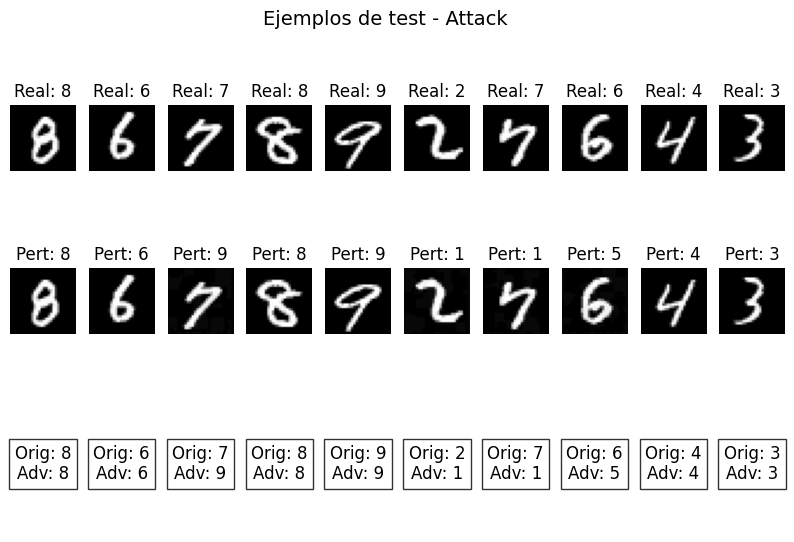

In [63]:
attack = Square(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [64]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 244/250 (97.60%)
Aciertos después del ataque: 172/250 (68.80%)
Cambio de predicción en 72/250 imágenes (28.80%)


(np.float64(0.976), np.float64(0.688), np.float64(0.288))

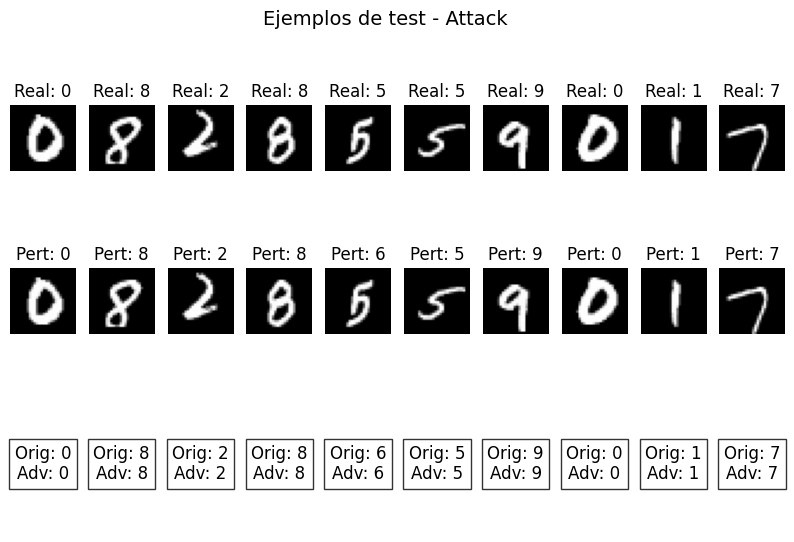

In [67]:
attack = Square(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [68]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 245/250 (98.00%)
Aciertos después del ataque: 242/250 (96.80%)
Cambio de predicción en 3/250 imágenes (1.20%)


(np.float64(0.98), np.float64(0.968), np.float64(0.012))

## 13. DIFGSM

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DIFGSM(Attack):
    r"""
    DI2-FGSM in the paper 'Improving Transferability of Adversarial Examples with Input Diversity'
    [https://arxiv.org/abs/1803.06978]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        decay (float): momentum factor. (Default: 0.0)
        steps (int): number of iterations. (Default: 10)
        resize_rate (float): resize factor used in input diversity. (Default: 0.9)
        diversity_prob (float) : the probability of applying input diversity. (Default: 0.5)
        random_start (bool): using random initialization of delta. (Default: False)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.DIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=0.0, resize_rate=0.9, diversity_prob=0.5, random_start=False)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        eps=8 / 255,
        alpha=2 / 255,
        steps=10,
        decay=0.0,
        resize_rate=0.9,
        diversity_prob=0.5,
        random_start=False,
    ):
        super().__init__("DIFGSM", model)
        self.eps = eps
        self.steps = steps
        self.decay = decay
        self.alpha = alpha
        self.resize_rate = resize_rate
        self.diversity_prob = diversity_prob
        self.random_start = random_start
        self.supported_mode = ["default", "targeted"]

    def input_diversity(self, x):
        img_size = x.shape[-1]
        img_resize = int(img_size * self.resize_rate)

        if self.resize_rate < 1:
            img_size = img_resize
            img_resize = x.shape[-1]

        rnd = torch.randint(low=img_size, high=img_resize, size=(1,), dtype=torch.int32)
        rescaled = F.interpolate(
            x, size=[rnd, rnd], mode="bilinear", align_corners=False
        )
        h_rem = img_resize - rnd
        w_rem = img_resize - rnd
        pad_top = torch.randint(low=0, high=h_rem.item(), size=(1,), dtype=torch.int32)
        pad_bottom = h_rem - pad_top
        pad_left = torch.randint(low=0, high=w_rem.item(), size=(1,), dtype=torch.int32)
        pad_right = w_rem - pad_left

        padded = F.pad(
            rescaled,
            [pad_left.item(), pad_right.item(), pad_top.item(), pad_bottom.item()],
            value=0,
        )

        return padded if torch.rand(1) < self.diversity_prob else x

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()
        momentum = torch.zeros_like(images).detach().to(self.device)

        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(
                -self.eps, self.eps
            )
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(self.input_diversity(adv_images))

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]

            grad = grad / torch.mean(torch.abs(grad), dim=(1, 2, 3), keepdim=True)
            grad = grad + momentum * self.decay
            momentum = grad

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

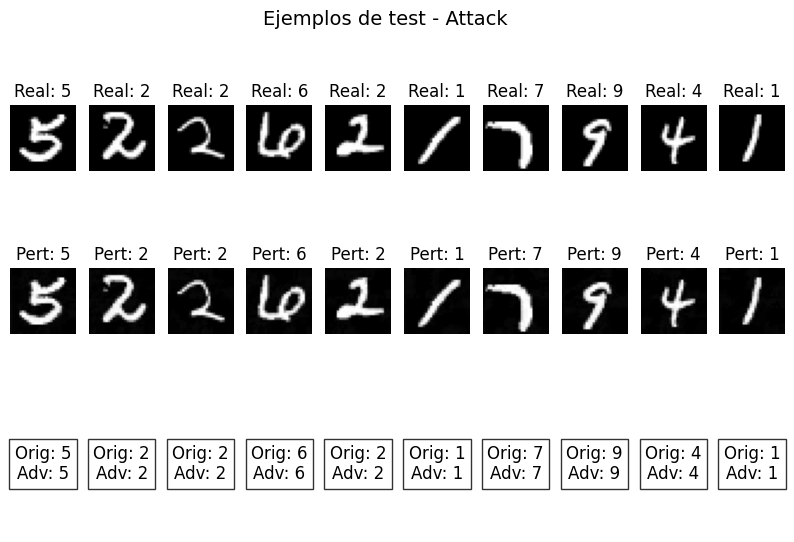

In [103]:
attack = DIFGSM(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [104]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 243/250 (97.20%)
Aciertos después del ataque: 232/250 (92.80%)
Cambio de predicción en 12/250 imágenes (4.80%)


(np.float64(0.972), np.float64(0.928), np.float64(0.048))

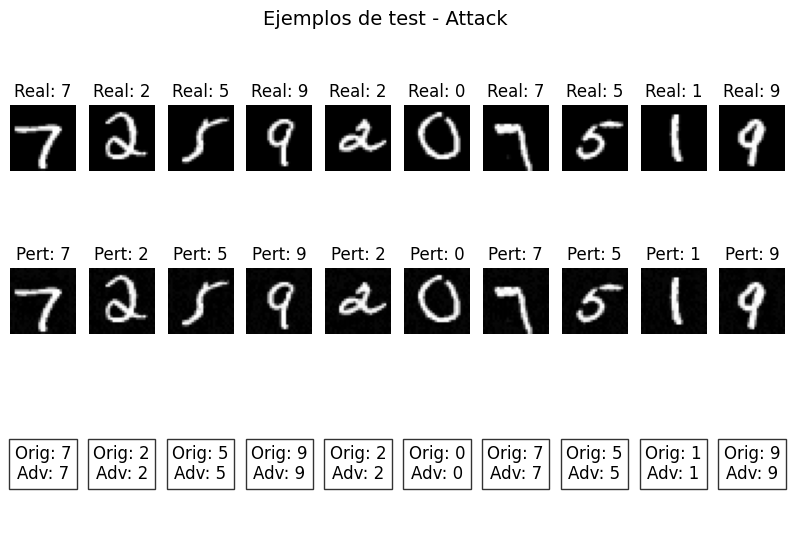

In [105]:
attack = DIFGSM(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [106]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 245/250 (98.00%)
Cambio de predicción en 2/250 imágenes (0.80%)


(np.float64(0.988), np.float64(0.98), np.float64(0.008))

## 14. BIM

In [94]:
import torch
import torch.nn as nn


class BIM(Attack):
    r"""
    BIM or iterative-FGSM in the paper 'Adversarial Examples in the Physical World'
    [https://arxiv.org/abs/1607.02533]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 10)

    .. note:: If steps set to 0, steps will be automatically decided following the paper.

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=10)
        >>> adv_images = attack(images, labels)
    """

    def __init__(self, model, eps=8 / 255, alpha=2 / 255, steps=10):
        super().__init__("BIM", model)
        self.eps = eps
        self.alpha = alpha
        if steps == 0:
            self.steps = int(min(eps * 255 + 4, 1.25 * eps * 255))
        else:
            self.steps = steps
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        ori_images = images.clone().detach()

        for _ in range(self.steps):
            images.requires_grad = True
            outputs = self.get_logits(images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, images, retain_graph=False, create_graph=False
            )[0]

            adv_images = images + self.alpha * grad.sign()
            a = torch.clamp(ori_images - self.eps, min=0)
            b = (adv_images >= a).float() * adv_images + (
                adv_images < a
            ).float() * a  # nopep8
            c = (b > ori_images + self.eps).float() * (ori_images + self.eps) + (
                b <= ori_images + self.eps
            ).float() * b  # nopep8
            images = torch.clamp(c, max=1).detach()

        return images

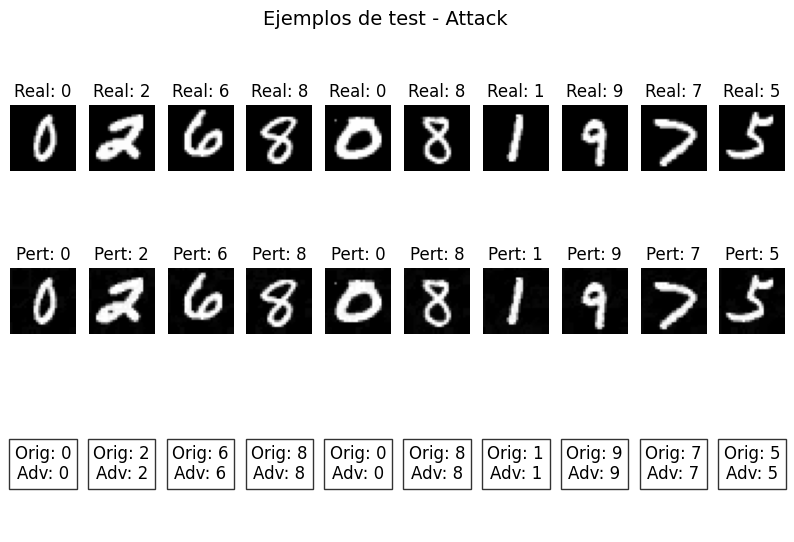

In [95]:
attack = BIM(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [96]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 249/250 (99.60%)
Aciertos después del ataque: 214/250 (85.60%)
Cambio de predicción en 35/250 imágenes (14.00%)


(np.float64(0.996), np.float64(0.856), np.float64(0.14))

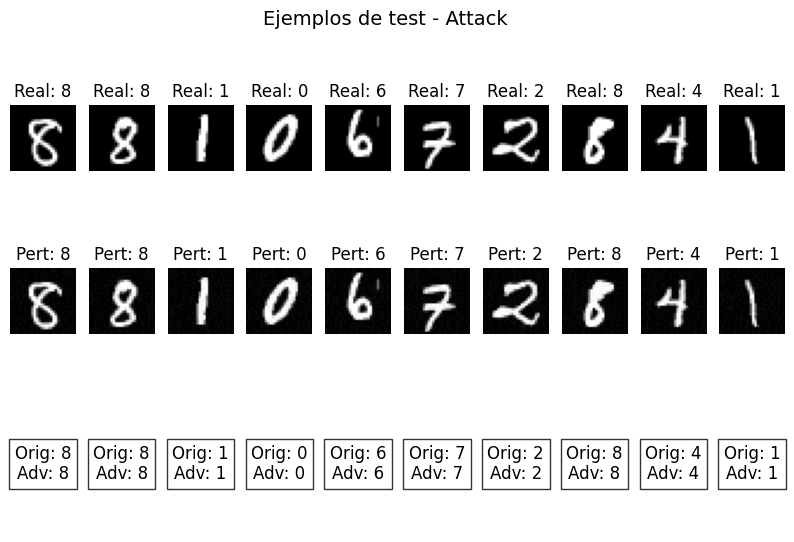

In [98]:
attack = BIM(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [99]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 247/250 (98.80%)
Cambio de predicción en 0/250 imágenes (0.00%)


(np.float64(0.988), np.float64(0.988), np.float64(0.0))

## 15. EADL1

In [107]:
import torch
import torch.nn as nn


class EADL1(Attack):
    r"""
    EAD attack in the paper 'EAD: Elastic-Net Attacks to Deep Neural Networks'
    [https://arxiv.org/abs/1709.04114]

    Distance Measure : L1

    Arguments:
        model (nn.Module): model to attack.
        kappa (float): how strong the adversarial example should be (also written as 'confidence'). (Default: 0)
        lr (float): larger values converge faster to less accurate results. (Default: 0.01)
        binary_search_steps (int): number of times to adjust the constant with binary search. (Default: 9)
        max_iterations (int): number of iterations to perform gradient descent. (Default: 100)
        abort_early (bool): if we stop improving, abort gradient descent early. (Default: True)
        initial_const (float): the initial constant c to pick as a first guess. (Default: 0.001)
        beta (float): hyperparameter trading off L2 minimization for L1 minimization. (Default: 0.001)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.EADL1(model, kappa=0, lr=0.01, max_iterations=100)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        kappa=0,
        lr=0.01,
        binary_search_steps=9,
        max_iterations=100,
        abort_early=True,
        initial_const=0.001,
        beta=0.001,
    ):
        super().__init__("EADL1", model)
        self.kappa = kappa
        self.lr = lr
        self.binary_search_steps = binary_search_steps
        self.max_iterations = max_iterations
        self.abort_early = abort_early
        self.initial_const = initial_const
        self.beta = beta
        # The last iteration (if we run many steps) repeat the search once.
        self.repeat = binary_search_steps >= 10
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            labels = self.get_target_label(images, labels)

        outputs = self.get_logits(images)

        batch_size = images.shape[0]
        lower_bound = torch.zeros(batch_size, device=self.device)
        const = torch.ones(batch_size, device=self.device) * self.initial_const
        upper_bound = torch.ones(batch_size, device=self.device) * 1e10

        final_adv_images = images.clone()
        y_one_hot = torch.eye(outputs.shape[1]).to(self.device)[labels]

        o_bestl1 = [1e10] * batch_size
        o_bestscore = [-1] * batch_size
        o_bestl1 = torch.Tensor(o_bestl1).to(self.device)
        o_bestscore = torch.Tensor(o_bestscore).to(self.device)

        # Initialization: x^{(0)} = y^{(0)} = x_0 in paper Algorithm 1 part
        x_k = images.clone().detach()
        y_k = nn.Parameter(images)

        # Start binary search
        for outer_step in range(self.binary_search_steps):

            self.global_step = 0

            bestl1 = [1e10] * batch_size
            bestscore = [-1] * batch_size

            bestl1 = torch.Tensor(bestl1).to(self.device)
            bestscore = torch.Tensor(bestscore).to(self.device)
            prevloss = 1e6

            if self.repeat and outer_step == (self.binary_search_steps - 1):
                const = upper_bound

            lr = self.lr
            for iteration in range(self.max_iterations):
                # reset gradient
                if y_k.grad is not None:
                    y_k.grad.detach_()
                    y_k.grad.zero_()

                # Loss over images_parameters with only L2 same as CW
                # we don't update L1 loss with SGD because we use ISTA
                output = self.get_logits(y_k)
                L2_loss = self.L2_loss(y_k, images)

                cost = self.EAD_loss(output, y_one_hot, None, L2_loss, const)
                # cost.backward(retain_graph=True)
                cost.backward()

                # Gradient step
                # y_k.data.add_(-lr, y_k.grad.data)
                self.global_step += 1
                with torch.no_grad():
                    y_k -= y_k.grad * lr

                # Ploynomial decay of learning rate
                lr = (
                    self.lr * (1 - self.global_step / self.max_iterations) ** 0.5
                )  # nopep8
                x_k, y_k = self.FISTA(images, x_k, y_k)
                # Loss ElasticNet or L1 over x_k
                with torch.no_grad():
                    output = self.get_logits(x_k)
                    L2_loss = self.L2_loss(x_k, images)
                    L1_loss = self.L1_loss(x_k, images)
                    loss = self.EAD_loss(
                        output, y_one_hot, L1_loss, L2_loss, const
                    )  # nopep8

                    # print('loss: {}, prevloss: {}'.format(loss, prevloss))
                    if (
                        self.abort_early
                        and iteration % (self.max_iterations // 10) == 0
                    ):
                        if loss > prevloss * 0.999999:
                            break
                        prevloss = loss

                    # L1 attack key step!
                    cost = L1_loss
                    self.adjust_best_result(
                        x_k,
                        labels,
                        output,
                        cost,
                        bestl1,
                        bestscore,
                        o_bestl1,
                        o_bestscore,
                        final_adv_images,
                    )

            self.adjust_constant(labels, bestscore, const, upper_bound, lower_bound)

        return final_adv_images

    def L1_loss(self, x1, x2):
        Flatten = nn.Flatten()
        L1_loss = torch.abs(Flatten(x1) - Flatten(x2)).sum(dim=1)
        # L1_loss = L1.sum()
        return L1_loss

    def L2_loss(self, x1, x2):
        MSELoss = nn.MSELoss(reduction="none")
        Flatten = nn.Flatten()
        L2_loss = MSELoss(Flatten(x1), Flatten(x2)).sum(dim=1)
        # L2_loss = L2.sum()
        return L2_loss

    def EAD_loss(self, output, one_hot_labels, L1_loss, L2_loss, const):

        # Not same as CW's f function
        other = torch.max(
            (1 - one_hot_labels) * output - (one_hot_labels * 1e4), dim=1
        )[0]
        real = torch.max(one_hot_labels * output, dim=1)[0]

        if self.targeted:
            F_loss = torch.clamp((other - real), min=-self.kappa)
        else:
            F_loss = torch.clamp((real - other), min=-self.kappa)

        if isinstance(L1_loss, type(None)):
            loss = torch.sum(const * F_loss) + torch.sum(L2_loss)
        else:
            loss = (
                torch.sum(const * F_loss)
                + torch.sum(L2_loss)
                + torch.sum(self.beta * L1_loss)
            )

        return loss

    def FISTA(self, images, x_k, y_k):

        zt = self.global_step / (self.global_step + 3)

        upper = torch.clamp(y_k - self.beta, max=1)
        lower = torch.clamp(y_k + self.beta, min=0)

        diff = y_k - images
        cond1 = (diff > self.beta).float()
        cond2 = (torch.abs(diff) <= self.beta).float()
        cond3 = (diff < -self.beta).float()

        new_x_k = (cond1 * upper) + (cond2 * images) + (cond3 * lower)
        y_k.data = new_x_k + (zt * (new_x_k - x_k))
        return new_x_k, y_k

    def compare(self, output, labels):
        if len(output.shape) >= 2:
            # output is tensor
            output = output.clone().detach()
            if self.targeted:
                output[:, labels] -= self.kappa
            else:
                output[:, labels] += self.kappa
            output = torch.argmax(output, 1)
        else:
            # output is int or float
            pass

        if self.targeted:
            return output == labels
        else:
            return output != labels

    def adjust_best_result(
        self,
        adv_img,
        labels,
        output,
        cost,
        bestl1,
        bestscore,
        o_bestl1,
        o_bestscore,
        final_adv_images,
    ):
        output_label = torch.argmax(output, 1).float()
        mask = (cost < bestl1) & self.compare(output, labels)
        bestl1[mask] = cost[mask]
        bestscore[mask] = output_label[mask]

        mask = (cost < o_bestl1) & self.compare(output, labels)
        o_bestl1[mask] = cost[mask]
        o_bestscore[mask] = output_label[mask]
        final_adv_images[mask] = adv_img[mask]

    def adjust_constant(self, labels, bestscore, const, upper_bound, lower_bound):
        mask = (self.compare(bestscore, labels)) & (bestscore != -1)
        upper_bound[mask] = torch.min(upper_bound[mask], const[mask])
        lower_bound[~mask] = torch.max(lower_bound[~mask], const[~mask])  # nopep8

        mask = upper_bound < 1e9
        const[mask] = (lower_bound[mask] + upper_bound[mask]) / 2
        const[~mask] = const[~mask] * 10

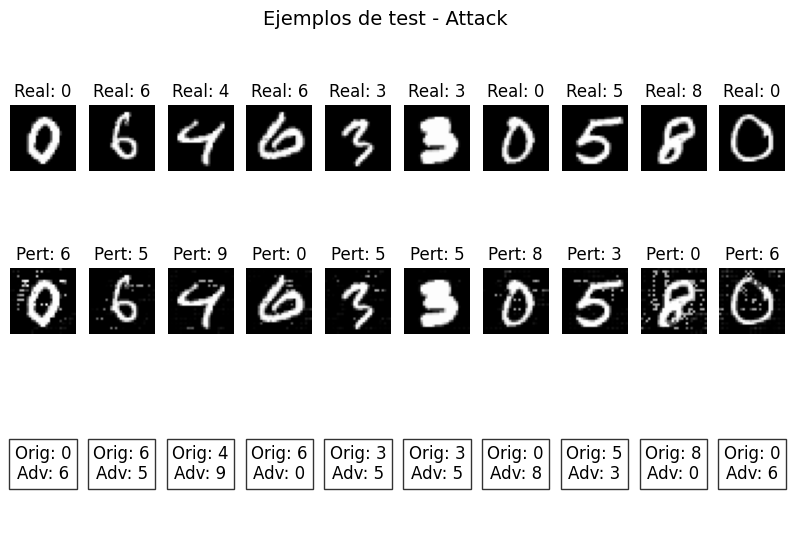

In [108]:
attack = EADL1(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [109]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 246/250 (98.40%)
Aciertos después del ataque: 0/250 (0.00%)
Cambio de predicción en 246/250 imágenes (98.40%)


(np.float64(0.984), np.float64(0.0), np.float64(0.984))

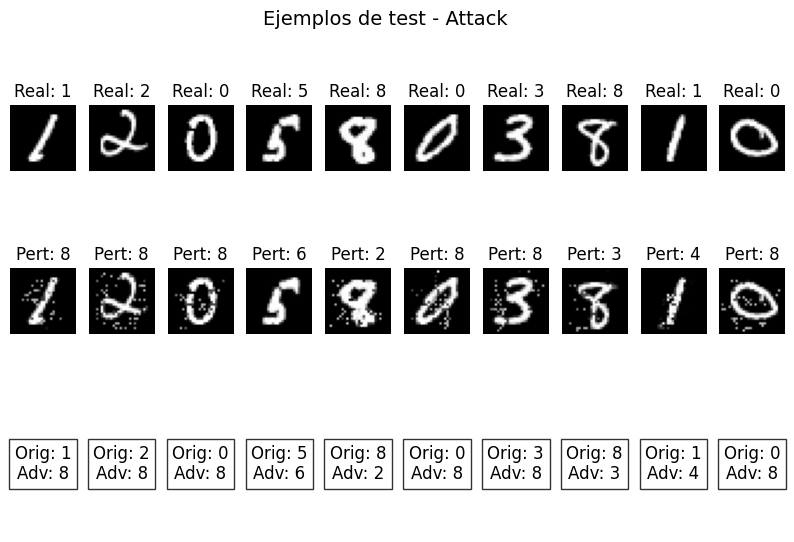

In [110]:
attack = EADL1(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [111]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 244/250 (97.60%)
Aciertos después del ataque: 0/250 (0.00%)
Cambio de predicción en 244/250 imágenes (97.60%)


(np.float64(0.976), np.float64(0.0), np.float64(0.976))

## 16. EOTPGD

In [112]:
import torch
import torch.nn as nn

class EOTPGD(Attack):
    r"""
    Comment on "Adv-BNN: Improved Adversarial Defense through Robust Bayesian Neural Network"
    [https://arxiv.org/abs/1907.00895]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 10)
        eot_iter (int) : number of models to estimate the mean gradient. (Default: 2)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`, `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.EOTPGD(model, eps=8/255, alpha=2/255, steps=10, eot_iter=2)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self, model, eps=8 / 255, alpha=2 / 255, steps=10, eot_iter=2, random_start=True
    ):
        super().__init__("EOTPGD", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.eot_iter = eot_iter
        self.random_start = random_start
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(
                -self.eps, self.eps
            )  # nopep8
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            grad = torch.zeros_like(adv_images)
            adv_images.requires_grad = True

            for j in range(self.eot_iter):
                outputs = self.get_logits(adv_images)

                # Calculate loss
                if self.targeted:
                    cost = -loss(outputs, target_labels)
                else:
                    cost = loss(outputs, labels)

                # Update adversarial images
                grad += torch.autograd.grad(
                    cost, adv_images, retain_graph=False, create_graph=False
                )[0]

            # (grad/self.eot_iter).sign() == grad.sign()
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

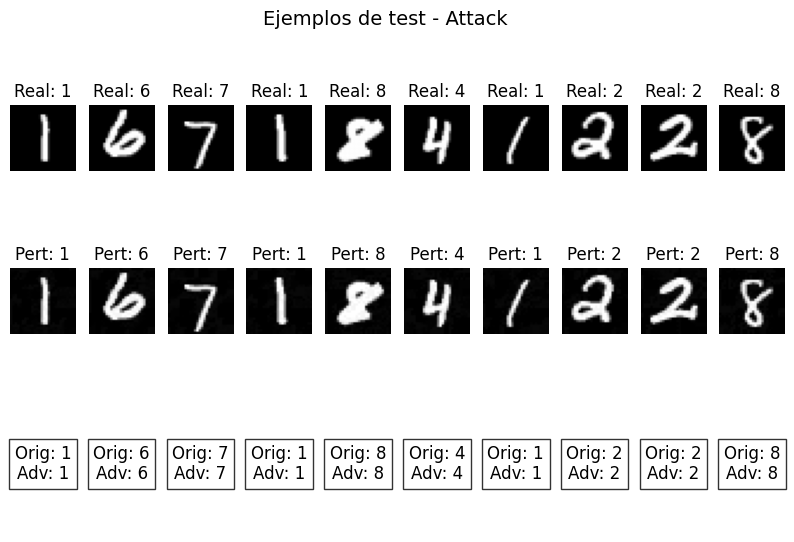

In [113]:
attack = EOTPGD(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [114]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 248/250 (99.20%)
Aciertos después del ataque: 222/250 (88.80%)
Cambio de predicción en 26/250 imágenes (10.40%)


(np.float64(0.992), np.float64(0.888), np.float64(0.104))

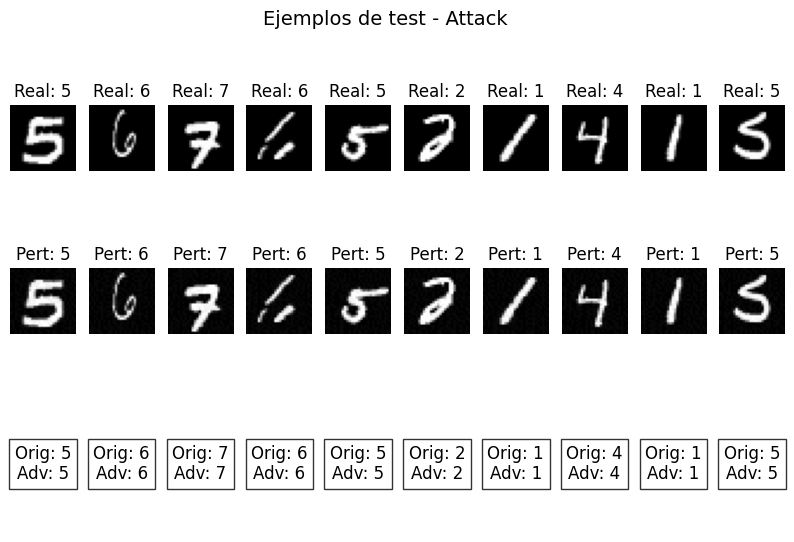

In [115]:
attack = EOTPGD(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [116]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 248/250 (99.20%)
Aciertos después del ataque: 247/250 (98.80%)
Cambio de predicción en 1/250 imágenes (0.40%)


(np.float64(0.992), np.float64(0.988), np.float64(0.004))

## 17. FAB

In [117]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import time
import math

import torch
import torch.nn.functional as F

# zero_gradients deprecated in torch >= 1.9.
# zero_gradients is re-defined in the bottom of the code.
# from torch.autograd.gradcheck import zero_gradients
from collections import abc as container_abcs


class FAB(Attack):
    r"""
    Fast Adaptive Boundary Attack in the paper 'Minimally distorted Adversarial Examples with a Fast Adaptive Boundary Attack'
    [https://arxiv.org/abs/1907.02044]
    [https://github.com/fra31/auto-attack]

    Distance Measure : Linf, L2, L1

    Arguments:
        model (nn.Module): model to attack.
        norm (str) : Lp-norm to minimize. ['Linf', 'L2', 'L1'] (Default: 'Linf')
        eps (float): maximum perturbation. (Default: 8/255)
        steps (int): number of steps. (Default: 10)
        n_restarts (int): number of random restarts. (Default: 1)
        alpha_max (float): alpha_max. (Default: 0.1)
        eta (float): overshooting. (Default: 1.05)
        beta (float): backward step. (Default: 0.9)
        verbose (bool): print progress. (Default: False)
        seed (int): random seed for the starting point. (Default: 0)
        targeted (bool): targeted attack for every wrong classes. (Default: False)
        n_classes (int): number of classes. (Default: 10)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.FAB(model, norm='Linf', steps=10, eps=8/255, n_restarts=1, alpha_max=0.1, eta=1.05, beta=0.9, loss_fn=None, verbose=False, seed=0, targeted=False, n_classes=10)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        norm="Linf",
        eps=8 / 255,
        steps=10,
        n_restarts=1,
        alpha_max=0.1,
        eta=1.05,
        beta=0.9,
        verbose=False,
        seed=0,
        multi_targeted=False,
        n_classes=10,
    ):
        super().__init__("FAB", model)
        self.norm = norm
        self.n_restarts = n_restarts
        Default_EPS_DICT_BY_NORM = {"Linf": 0.3, "L2": 1.0, "L1": 5.0}
        self.eps = eps if eps is not None else Default_EPS_DICT_BY_NORM[norm]
        self.alpha_max = alpha_max
        self.eta = eta
        self.beta = beta
        self.steps = steps
        self.verbose = verbose
        self.seed = seed
        self.target_class = None
        self.multi_targeted = multi_targeted
        self.n_target_classes = n_classes - 1
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        adv_images = self.perturb(images, labels)

        return adv_images

    def _get_predicted_label(self, x):
        with torch.no_grad():
            outputs = self.get_logits(x)
        _, y = torch.max(outputs, dim=1)
        return y

    def check_shape(self, x):
        return x if len(x.shape) > 0 else x.unsqueeze(0)

    def get_diff_logits_grads_batch(self, imgs, la):
        im = imgs.clone().requires_grad_()
        with torch.enable_grad():
            y = self.get_logits(im)

        g2 = torch.zeros([y.shape[-1], *imgs.size()]).to(self.device)
        grad_mask = torch.zeros_like(y)
        for counter in range(y.shape[-1]):
            zero_gradients(im)
            grad_mask[:, counter] = 1.0
            y.backward(grad_mask, retain_graph=True)
            grad_mask[:, counter] = 0.0
            g2[counter] = im.grad.data

        g2 = torch.transpose(g2, 0, 1).detach()
        # y2 = self.get_logits(imgs).detach()
        y2 = y.detach()
        df = y2 - y2[torch.arange(imgs.shape[0]), la].unsqueeze(1)
        dg = g2 - g2[torch.arange(imgs.shape[0]), la].unsqueeze(1)
        df[torch.arange(imgs.shape[0]), la] = 1e10

        return df, dg

    def get_diff_logits_grads_batch_targeted(self, imgs, la, la_target):
        u = torch.arange(imgs.shape[0])
        im = imgs.clone().requires_grad_()
        with torch.enable_grad():
            y = self.get_logits(im)
            diffy = -(y[u, la] - y[u, la_target])
            sumdiffy = diffy.sum()

        zero_gradients(im)
        sumdiffy.backward()
        graddiffy = im.grad.data
        df = diffy.detach().unsqueeze(1)
        dg = graddiffy.unsqueeze(1)

        return df, dg

    def attack_single_run(self, x, y=None, use_rand_start=False):
        """
        :param x:    clean images
        :param y:    clean labels, if None we use the predicted labels
        """

        # self.device = x.device
        self.orig_dim = list(x.shape[1:])
        self.ndims = len(self.orig_dim)

        x = x.detach().clone().float().to(self.device)
        # assert next(self.model.parameters()).device == x.device

        y_pred = self._get_predicted_label(x)
        if y is None:
            y = y_pred.detach().clone().long().to(self.device)
        else:
            y = y.detach().clone().long().to(self.device)
        pred = y_pred == y
        corr_classified = pred.float().sum()
        if self.verbose:
            print("Clean accuracy: {:.2%}".format(pred.float().mean()))
        if pred.sum() == 0:
            return x
        pred = self.check_shape(pred.nonzero().squeeze())

        startt = time.time()
        # runs the attack only on correctly classified points
        im2 = x[pred].detach().clone()
        la2 = y[pred].detach().clone()
        if len(im2.shape) == self.ndims:
            im2 = im2.unsqueeze(0)
        bs = im2.shape[0]
        u1 = torch.arange(bs)
        adv = im2.clone()
        adv_c = x.clone()
        res2 = 1e10 * torch.ones([bs]).to(self.device)
        res_c = torch.zeros([x.shape[0]]).to(self.device)
        x1 = im2.clone()
        x0 = im2.clone().reshape([bs, -1])
        counter_restarts = 0

        while counter_restarts < 1:
            if use_rand_start:
                if self.norm == "Linf":
                    t = 2 * torch.rand(x1.shape).to(self.device) - 1
                    x1 = (
                        im2
                        + (
                            torch.min(
                                res2, self.eps * torch.ones(res2.shape).to(self.device)
                            ).reshape([-1, *[1] * self.ndims])
                        )
                        * t
                        / (
                            t.reshape([t.shape[0], -1])
                            .abs()
                            .max(dim=1, keepdim=True)[0]
                            .reshape([-1, *[1] * self.ndims])
                        )
                        * 0.5
                    )
                elif self.norm == "L2":
                    t = torch.randn(x1.shape).to(self.device)
                    x1 = (
                        im2
                        + (
                            torch.min(
                                res2, self.eps * torch.ones(res2.shape).to(self.device)
                            ).reshape([-1, *[1] * self.ndims])
                        )
                        * t
                        / (
                            (t ** 2)
                            .view(t.shape[0], -1)
                            .sum(dim=-1)
                            .sqrt()
                            .view(t.shape[0], *[1] * self.ndims)
                        )
                        * 0.5
                    )
                elif self.norm == "L1":
                    t = torch.randn(x1.shape).to(self.device)
                    x1 = (
                        im2
                        + (
                            torch.min(
                                res2, self.eps * torch.ones(res2.shape).to(self.device)
                            ).reshape([-1, *[1] * self.ndims])
                        )
                        * t
                        / (
                            t.abs()
                            .view(t.shape[0], -1)
                            .sum(dim=-1)
                            .view(t.shape[0], *[1] * self.ndims)
                        )
                        / 2
                    )

                x1 = x1.clamp(0.0, 1.0)

            counter_iter = 0
            while counter_iter < self.steps:
                with torch.no_grad():
                    df, dg = self.get_diff_logits_grads_batch(x1, la2)
                    if self.norm == "Linf":
                        dist1 = df.abs() / (
                            1e-12
                            + dg.abs().view(dg.shape[0], dg.shape[1], -1).sum(dim=-1)
                        )
                    elif self.norm == "L2":
                        dist1 = df.abs() / (
                            1e-12
                            + (dg ** 2)
                            .view(dg.shape[0], dg.shape[1], -1)
                            .sum(dim=-1)
                            .sqrt()
                        )
                    elif self.norm == "L1":
                        dist1 = df.abs() / (
                            1e-12
                            + dg.abs()
                            .reshape([df.shape[0], df.shape[1], -1])
                            .max(dim=2)[0]
                        )
                    else:
                        raise ValueError("norm not supported")
                    ind = dist1.min(dim=1)[1]
                    dg2 = dg[u1, ind]
                    b = -df[u1, ind] + (dg2 * x1).view(x1.shape[0], -1).sum(dim=-1)
                    w = dg2.reshape([bs, -1])

                    if self.norm == "Linf":
                        d3 = projection_linf(
                            torch.cat((x1.reshape([bs, -1]), x0), 0),
                            torch.cat((w, w), 0),
                            torch.cat((b, b), 0),
                        )
                    elif self.norm == "L2":
                        d3 = projection_l2(
                            torch.cat((x1.reshape([bs, -1]), x0), 0),
                            torch.cat((w, w), 0),
                            torch.cat((b, b), 0),
                        )
                    elif self.norm == "L1":
                        d3 = projection_l1(
                            torch.cat((x1.reshape([bs, -1]), x0), 0),
                            torch.cat((w, w), 0),
                            torch.cat((b, b), 0),
                        )
                    d1 = torch.reshape(d3[:bs], x1.shape)
                    d2 = torch.reshape(d3[-bs:], x1.shape)
                    if self.norm == "Linf":
                        a0 = (
                            d3.abs()
                            .max(dim=1, keepdim=True)[0]
                            .view(-1, *[1] * self.ndims)
                        )
                    elif self.norm == "L2":
                        a0 = (
                            (d3 ** 2)
                            .sum(dim=1, keepdim=True)
                            .sqrt()
                            .view(-1, *[1] * self.ndims)
                        )
                    elif self.norm == "L1":
                        a0 = (
                            d3.abs()
                            .sum(dim=1, keepdim=True)
                            .view(-1, *[1] * self.ndims)
                        )
                    a0 = torch.max(a0, 1e-8 * torch.ones(a0.shape).to(self.device))
                    a1 = a0[:bs]
                    a2 = a0[-bs:]
                    alpha = torch.min(
                        torch.max(
                            a1 / (a1 + a2), torch.zeros(a1.shape).to(self.device)
                        ),
                        self.alpha_max * torch.ones(a1.shape).to(self.device),
                    )
                    x1 = (
                        (x1 + self.eta * d1) * (1 - alpha)
                        + (im2 + d2 * self.eta) * alpha
                    ).clamp(0.0, 1.0)

                    is_adv = self._get_predicted_label(x1) != la2

                    if is_adv.sum() > 0:
                        ind_adv = is_adv.nonzero().squeeze()
                        ind_adv = self.check_shape(ind_adv)
                        if self.norm == "Linf":
                            t = (
                                (x1[ind_adv] - im2[ind_adv])
                                .reshape([ind_adv.shape[0], -1])
                                .abs()
                                .max(dim=1)[0]
                            )
                        elif self.norm == "L2":
                            t = (
                                ((x1[ind_adv] - im2[ind_adv]) ** 2)
                                .view(ind_adv.shape[0], -1)
                                .sum(dim=-1)
                                .sqrt()
                            )
                        elif self.norm == "L1":
                            t = (
                                (x1[ind_adv] - im2[ind_adv])
                                .abs()
                                .view(ind_adv.shape[0], -1)
                                .sum(dim=-1)
                            )
                        adv[ind_adv] = x1[ind_adv] * (
                            t < res2[ind_adv]
                        ).float().reshape([-1, *[1] * self.ndims]) + adv[ind_adv] * (
                            t >= res2[ind_adv]
                        ).float().reshape(
                            [-1, *[1] * self.ndims]
                        )
                        res2[ind_adv] = (
                            t * (t < res2[ind_adv]).float()
                            + res2[ind_adv] * (t >= res2[ind_adv]).float()
                        )
                        x1[ind_adv] = (
                            im2[ind_adv] + (x1[ind_adv] - im2[ind_adv]) * self.beta
                        )

                    counter_iter += 1

            counter_restarts += 1

        ind_succ = res2 < 1e10
        if self.verbose:
            print(
                "success rate: {:.0f}/{:.0f}".format(
                    ind_succ.float().sum(), corr_classified
                )
                + " (on correctly classified points) in {:.1f} s".format(
                    time.time() - startt
                )
            )

        res_c[pred] = res2 * ind_succ.float() + 1e10 * (1 - ind_succ.float())
        ind_succ = self.check_shape(ind_succ.nonzero().squeeze())
        adv_c[pred[ind_succ]] = adv[ind_succ].clone()

        return adv_c

    def attack_single_run_targeted(self, x, y=None, use_rand_start=False):
        """
        :param x:    clean images
        :param y:    clean labels, if None we use the predicted labels
        """

        if self.device is None:
            self.device = x.device
        self.orig_dim = list(x.shape[1:])
        self.ndims = len(self.orig_dim)

        x = x.detach().clone().float().to(self.device)
        # assert next(self.model.parameters()).device == x.device

        y_pred = self._get_predicted_label(x)
        if y is None:
            y = y_pred.detach().clone().long().to(self.device)
        else:
            y = y.detach().clone().long().to(self.device)
        pred = y_pred == y
        corr_classified = pred.float().sum()
        if self.verbose:
            print("Clean accuracy: {:.2%}".format(pred.float().mean()))
        if pred.sum() == 0:
            return x
        pred = self.check_shape(pred.nonzero().squeeze())

        output = self.get_logits(x)
        if self.multi_targeted:
            la_target = output.sort(dim=-1)[1][:, -self.target_class]
        else:
            la_target = self.target_class

        startt = time.time()
        # runs the attack only on correctly classified points
        im2 = x[pred].detach().clone()
        la2 = y[pred].detach().clone()
        la_target2 = la_target[pred].detach().clone()
        if len(im2.shape) == self.ndims:
            im2 = im2.unsqueeze(0)
        bs = im2.shape[0]
        u1 = torch.arange(bs)
        adv = im2.clone()
        adv_c = x.clone()
        res2 = 1e10 * torch.ones([bs]).to(self.device)
        res_c = torch.zeros([x.shape[0]]).to(self.device)
        x1 = im2.clone()
        x0 = im2.clone().reshape([bs, -1])
        counter_restarts = 0

        while counter_restarts < 1:
            if use_rand_start:
                if self.norm == "Linf":
                    t = 2 * torch.rand(x1.shape).to(self.device) - 1
                    x1 = (
                        im2
                        + (
                            torch.min(
                                res2, self.eps * torch.ones(res2.shape).to(self.device)
                            ).reshape([-1, *[1] * self.ndims])
                        )
                        * t
                        / (
                            t.reshape([t.shape[0], -1])
                            .abs()
                            .max(dim=1, keepdim=True)[0]
                            .reshape([-1, *[1] * self.ndims])
                        )
                        * 0.5
                    )
                elif self.norm == "L2":
                    t = torch.randn(x1.shape).to(self.device)
                    x1 = (
                        im2
                        + (
                            torch.min(
                                res2, self.eps * torch.ones(res2.shape).to(self.device)
                            ).reshape([-1, *[1] * self.ndims])
                        )
                        * t
                        / (
                            (t ** 2)
                            .view(t.shape[0], -1)
                            .sum(dim=-1)
                            .sqrt()
                            .view(t.shape[0], *[1] * self.ndims)
                        )
                        * 0.5
                    )
                elif self.norm == "L1":
                    t = torch.randn(x1.shape).to(self.device)
                    x1 = (
                        im2
                        + (
                            torch.min(
                                res2, self.eps * torch.ones(res2.shape).to(self.device)
                            ).reshape([-1, *[1] * self.ndims])
                        )
                        * t
                        / (
                            t.abs()
                            .view(t.shape[0], -1)
                            .sum(dim=-1)
                            .view(t.shape[0], *[1] * self.ndims)
                        )
                        / 2
                    )

                x1 = x1.clamp(0.0, 1.0)

            counter_iter = 0
            while counter_iter < self.steps:
                with torch.no_grad():
                    df, dg = self.get_diff_logits_grads_batch_targeted(
                        x1, la2, la_target2
                    )
                    if self.norm == "Linf":
                        dist1 = df.abs() / (
                            1e-12
                            + dg.abs().view(dg.shape[0], dg.shape[1], -1).sum(dim=-1)
                        )
                    elif self.norm == "L2":
                        dist1 = df.abs() / (
                            1e-12
                            + (dg ** 2)
                            .view(dg.shape[0], dg.shape[1], -1)
                            .sum(dim=-1)
                            .sqrt()
                        )
                    elif self.norm == "L1":
                        dist1 = df.abs() / (
                            1e-12
                            + dg.abs()
                            .reshape([df.shape[0], df.shape[1], -1])
                            .max(dim=2)[0]
                        )
                    else:
                        raise ValueError("norm not supported")
                    ind = dist1.min(dim=1)[1]

                    dg2 = dg[u1, ind]
                    b = -df[u1, ind] + (dg2 * x1).view(x1.shape[0], -1).sum(dim=-1)
                    w = dg2.reshape([bs, -1])

                    if self.norm == "Linf":
                        d3 = projection_linf(
                            torch.cat((x1.reshape([bs, -1]), x0), 0),
                            torch.cat((w, w), 0),
                            torch.cat((b, b), 0),
                        )
                    elif self.norm == "L2":
                        d3 = projection_l2(
                            torch.cat((x1.reshape([bs, -1]), x0), 0),
                            torch.cat((w, w), 0),
                            torch.cat((b, b), 0),
                        )
                    elif self.norm == "L1":
                        d3 = projection_l1(
                            torch.cat((x1.reshape([bs, -1]), x0), 0),
                            torch.cat((w, w), 0),
                            torch.cat((b, b), 0),
                        )
                    d1 = torch.reshape(d3[:bs], x1.shape)
                    d2 = torch.reshape(d3[-bs:], x1.shape)
                    if self.norm == "Linf":
                        a0 = (
                            d3.abs()
                            .max(dim=1, keepdim=True)[0]
                            .view(-1, *[1] * self.ndims)
                        )
                    elif self.norm == "L2":
                        a0 = (
                            (d3 ** 2)
                            .sum(dim=1, keepdim=True)
                            .sqrt()
                            .view(-1, *[1] * self.ndims)
                        )
                    elif self.norm == "L1":
                        a0 = (
                            d3.abs()
                            .sum(dim=1, keepdim=True)
                            .view(-1, *[1] * self.ndims)
                        )
                    a0 = torch.max(a0, 1e-8 * torch.ones(a0.shape).to(self.device))
                    a1 = a0[:bs]
                    a2 = a0[-bs:]
                    alpha = torch.min(
                        torch.max(
                            a1 / (a1 + a2), torch.zeros(a1.shape).to(self.device)
                        ),
                        self.alpha_max * torch.ones(a1.shape).to(self.device),
                    )
                    x1 = (
                        (x1 + self.eta * d1) * (1 - alpha)
                        + (im2 + d2 * self.eta) * alpha
                    ).clamp(0.0, 1.0)

                    is_adv = self._get_predicted_label(x1) != la2

                    if is_adv.sum() > 0:
                        ind_adv = is_adv.nonzero().squeeze()
                        ind_adv = self.check_shape(ind_adv)
                        if self.norm == "Linf":
                            t = (
                                (x1[ind_adv] - im2[ind_adv])
                                .reshape([ind_adv.shape[0], -1])
                                .abs()
                                .max(dim=1)[0]
                            )
                        elif self.norm == "L2":
                            t = (
                                ((x1[ind_adv] - im2[ind_adv]) ** 2)
                                .view(ind_adv.shape[0], -1)
                                .sum(dim=-1)
                                .sqrt()
                            )
                        elif self.norm == "L1":
                            t = (
                                (x1[ind_adv] - im2[ind_adv])
                                .abs()
                                .view(ind_adv.shape[0], -1)
                                .sum(dim=-1)
                            )
                        adv[ind_adv] = x1[ind_adv] * (
                            t < res2[ind_adv]
                        ).float().reshape([-1, *[1] * self.ndims]) + adv[ind_adv] * (
                            t >= res2[ind_adv]
                        ).float().reshape(
                            [-1, *[1] * self.ndims]
                        )
                        res2[ind_adv] = (
                            t * (t < res2[ind_adv]).float()
                            + res2[ind_adv] * (t >= res2[ind_adv]).float()
                        )
                        x1[ind_adv] = (
                            im2[ind_adv] + (x1[ind_adv] - im2[ind_adv]) * self.beta
                        )

                    counter_iter += 1

            counter_restarts += 1

        ind_succ = res2 < 1e10
        if self.verbose:
            print(
                "success rate: {:.0f}/{:.0f}".format(
                    ind_succ.float().sum(), corr_classified
                )
                + " (on correctly classified points) in {:.1f} s".format(
                    time.time() - startt
                )
            )

        res_c[pred] = res2 * ind_succ.float() + 1e10 * (1 - ind_succ.float())
        ind_succ = self.check_shape(ind_succ.nonzero().squeeze())
        adv_c[pred[ind_succ]] = adv[ind_succ].clone()

        return adv_c

    def perturb(self, x, y):
        adv = x.clone()
        with torch.no_grad():
            acc = self.get_logits(x).max(1)[1] == y

            startt = time.time()

            torch.random.manual_seed(self.seed)
            torch.cuda.random.manual_seed(self.seed)

            def inner_perturb(targeted):
                for counter in range(self.n_restarts):
                    ind_to_fool = acc.nonzero().squeeze()
                    if len(ind_to_fool.shape) == 0:
                        ind_to_fool = ind_to_fool.unsqueeze(0)
                    if ind_to_fool.numel() != 0:
                        x_to_fool, y_to_fool = (
                            x[ind_to_fool].clone(),
                            y[ind_to_fool].clone(),
                        )  # nopep8

                        if targeted:
                            adv_curr = self.attack_single_run_targeted(
                                x_to_fool, y_to_fool, use_rand_start=(counter > 0)
                            )
                        else:
                            adv_curr = self.attack_single_run(
                                x_to_fool, y_to_fool, use_rand_start=(counter > 0)
                            )

                        acc_curr = self.get_logits(adv_curr).max(1)[1] == y_to_fool
                        if self.norm == "Linf":
                            res = (
                                (x_to_fool - adv_curr)
                                .abs()
                                .view(x_to_fool.shape[0], -1)
                                .max(1)[0]
                            )  # nopep8
                        elif self.norm == "L2":
                            res = (
                                ((x_to_fool - adv_curr) ** 2)
                                .view(x_to_fool.shape[0], -1)
                                .sum(dim=-1)
                                .sqrt()
                            )  # nopep8
                        acc_curr = torch.max(acc_curr, res > self.eps)

                        ind_curr = (acc_curr == 0).nonzero().squeeze()
                        acc[ind_to_fool[ind_curr]] = 0
                        adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()

                        if self.verbose:
                            if targeted:
                                print(
                                    "restart {} - target_class {} - robust accuracy: {:.2%} at eps = {:.5f} - cum. time: {:.1f} s".format(
                                        counter,
                                        self.target_class,
                                        acc.float().mean(),
                                        self.eps,
                                        time.time() - startt,
                                    )
                                )
                            else:
                                print(
                                    "restart {} - robust accuracy: {:.2%} at eps = {:.5f} - cum. time: {:.1f} s".format(
                                        counter,
                                        acc.float().mean(),
                                        self.eps,
                                        time.time() - startt,
                                    )
                                )

            if self.multi_targeted:
                for target_class in range(2, self.n_target_classes + 2):
                    self.target_class = target_class
                    inner_perturb(targeted=True)
            elif self.targeted:
                self.target_class = self.get_target_label(x, y)
                inner_perturb(targeted=True)
            else:
                inner_perturb(targeted=False)
        return adv


def projection_linf(points_to_project, w_hyperplane, b_hyperplane):
    device = points_to_project.device
    t, w, b = points_to_project, w_hyperplane.clone(), b_hyperplane.clone()

    sign = 2 * ((w * t).sum(1) - b >= 0) - 1
    w.mul_(sign.unsqueeze(1))
    b.mul_(sign)

    a = (w < 0).float()
    d = (a - t) * (w != 0).float()

    p = a - t * (2 * a - 1)
    indp = torch.argsort(p, dim=1)

    b = b - (w * t).sum(1)
    b0 = (w * d).sum(1)

    indp2 = indp.flip((1,))
    ws = w.gather(1, indp2)
    bs2 = -ws * d.gather(1, indp2)

    s = torch.cumsum(ws.abs(), dim=1)
    sb = torch.cumsum(bs2, dim=1) + b0.unsqueeze(1)

    b2 = sb[:, -1] - s[:, -1] * p.gather(1, indp[:, 0:1]).squeeze(1)
    c_l = b - b2 > 0
    c2 = (b - b0 > 0) & (~c_l)
    lb = torch.zeros(c2.sum(), device=device)
    ub = torch.full_like(lb, w.shape[1] - 1)
    nitermax = math.ceil(math.log2(w.shape[1]))

    indp_, sb_, s_, p_, b_ = indp[c2], sb[c2], s[c2], p[c2], b[c2]
    for counter in range(nitermax):
        counter4 = torch.floor((lb + ub) / 2)

        counter2 = counter4.long().unsqueeze(1)
        indcurr = indp_.gather(1, indp_.size(1) - 1 - counter2)
        b2 = (
            sb_.gather(1, counter2) - s_.gather(1, counter2) * p_.gather(1, indcurr)
        ).squeeze(
            1
        )  # nopep8
        c = b_ - b2 > 0

        lb = torch.where(c, counter4, lb)
        ub = torch.where(c, ub, counter4)

    lb = lb.long()

    if c_l.any():
        lmbd_opt = torch.clamp_min(
            (b[c_l] - sb[c_l, -1]) / (-s[c_l, -1]), min=0
        ).unsqueeze(-1)
        d[c_l] = (2 * a[c_l] - 1) * lmbd_opt

    lmbd_opt = torch.clamp_min((b[c2] - sb[c2, lb]) / (-s[c2, lb]), min=0).unsqueeze(-1)
    d[c2] = torch.min(lmbd_opt, d[c2]) * a[c2] + torch.max(-lmbd_opt, d[c2]) * (
        1 - a[c2]
    )

    return d * (w != 0).float()


def projection_l2(points_to_project, w_hyperplane, b_hyperplane):
    device = points_to_project.device
    t, w, b = points_to_project, w_hyperplane.clone(), b_hyperplane

    c = (w * t).sum(1) - b
    ind2 = 2 * (c >= 0) - 1
    w.mul_(ind2.unsqueeze(1))
    c.mul_(ind2)

    r = torch.max(t / w, (t - 1) / w).clamp(min=-1e12, max=1e12)
    r.masked_fill_(w.abs() < 1e-8, 1e12)
    r[r == -1e12] *= -1
    rs, indr = torch.sort(r, dim=1)
    rs2 = F.pad(rs[:, 1:], (0, 1))
    rs.masked_fill_(rs == 1e12, 0)
    rs2.masked_fill_(rs2 == 1e12, 0)

    w3s = (w ** 2).gather(1, indr)
    w5 = w3s.sum(dim=1, keepdim=True)
    ws = w5 - torch.cumsum(w3s, dim=1)
    d = -(r * w)
    d.mul_((w.abs() > 1e-8).float())
    s = torch.cat(
        (-w5 * rs[:, 0:1], torch.cumsum((-rs2 + rs) * ws, dim=1) - w5 * rs[:, 0:1]), 1
    )

    c4 = s[:, 0] + c < 0
    c3 = (d * w).sum(dim=1) + c > 0
    c2 = ~(c4 | c3)

    lb = torch.zeros(c2.sum(), device=device)
    ub = torch.full_like(lb, w.shape[1] - 1)
    nitermax = math.ceil(math.log2(w.shape[1]))

    s_, c_ = s[c2], c[c2]
    for counter in range(nitermax):
        counter4 = torch.floor((lb + ub) / 2)
        counter2 = counter4.long().unsqueeze(1)
        c3 = s_.gather(1, counter2).squeeze(1) + c_ > 0
        lb = torch.where(c3, counter4, lb)
        ub = torch.where(c3, ub, counter4)

    lb = lb.long()

    if c4.any():
        alpha = c[c4] / w5[c4].squeeze(-1)
        d[c4] = -alpha.unsqueeze(-1) * w[c4]

    if c2.any():
        alpha = (s[c2, lb] + c[c2]) / ws[c2, lb] + rs[c2, lb]
        alpha[ws[c2, lb] == 0] = 0
        c5 = (alpha.unsqueeze(-1) > r[c2]).float()
        d[c2] = d[c2] * c5 - alpha.unsqueeze(-1) * w[c2] * (1 - c5)

    return d * (w.abs() > 1e-8).float()


def projection_l1(points_to_project, w_hyperplane, b_hyperplane):
    device = points_to_project.device
    t, w, b = points_to_project, w_hyperplane.clone(), b_hyperplane

    c = (w * t).sum(1) - b
    ind2 = 2 * (c >= 0) - 1
    w.mul_(ind2.unsqueeze(1))
    c.mul_(ind2)

    r = (1 / w).abs().clamp_max(1e12)
    indr = torch.argsort(r, dim=1)
    indr_rev = torch.argsort(indr)

    c6 = (w < 0).float()
    d = (-t + c6) * (w != 0).float()
    ds = torch.min(-w * t, w * (1 - t)).gather(1, indr)
    ds2 = torch.cat((c.unsqueeze(-1), ds), 1)
    s = torch.cumsum(ds2, dim=1)

    c2 = s[:, -1] < 0

    lb = torch.zeros(c2.sum(), device=device)
    ub = torch.full_like(lb, s.shape[1])
    nitermax = math.ceil(math.log2(w.shape[1]))

    s_ = s[c2]
    for counter in range(nitermax):
        counter4 = torch.floor((lb + ub) / 2)
        counter2 = counter4.long().unsqueeze(1)
        c3 = s_.gather(1, counter2).squeeze(1) > 0
        lb = torch.where(c3, counter4, lb)
        ub = torch.where(c3, ub, counter4)

    lb2 = lb.long()

    if c2.any():
        indr = indr[c2].gather(1, lb2.unsqueeze(1)).squeeze(1)
        u = torch.arange(0, w.shape[0], device=device).unsqueeze(1)
        u2 = torch.arange(0, w.shape[1], device=device, dtype=torch.float).unsqueeze(0)
        alpha = -s[c2, lb2] / w[c2, indr]
        c5 = u2 < lb.unsqueeze(-1)
        u3 = c5[u[: c5.shape[0]], indr_rev[c2]]
        d[c2] = d[c2] * u3.float()
        d[c2, indr] = alpha

    return d * (w.abs() > 1e-8).float()


def zero_gradients(x):
    if isinstance(x, torch.Tensor):
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()
    elif isinstance(x, container_abcs.Iterable):
        for elem in x:
            zero_gradients(elem)

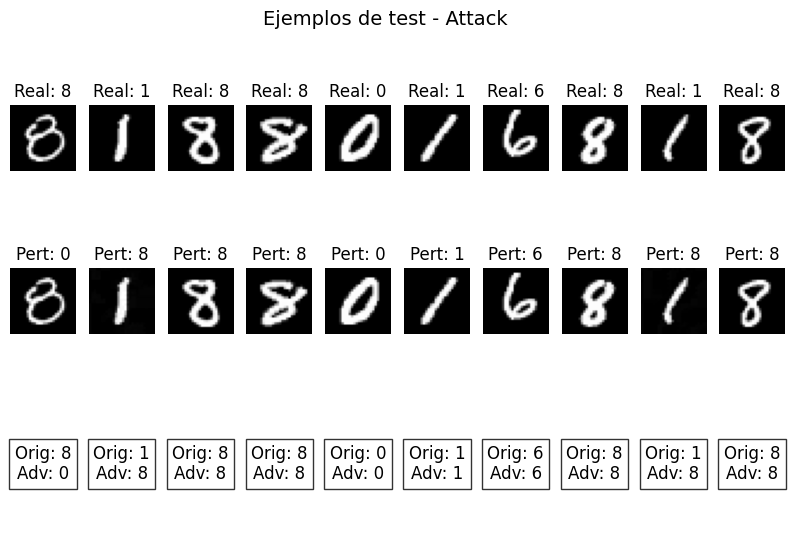

In [118]:
attack = FAB(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [119]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 246/250 (98.40%)
Aciertos después del ataque: 210/250 (84.00%)
Cambio de predicción en 36/250 imágenes (14.40%)


(np.float64(0.984), np.float64(0.84), np.float64(0.144))

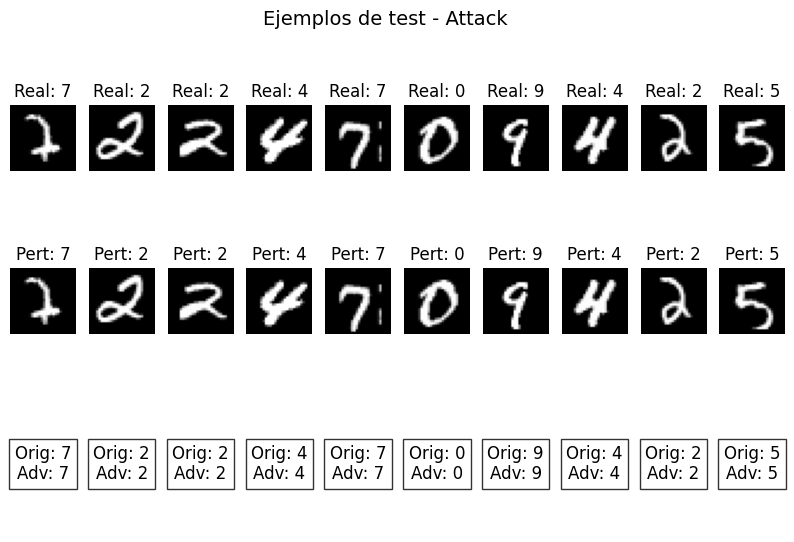

In [120]:
attack = FAB(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [121]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 246/250 (98.40%)
Cambio de predicción en 1/250 imágenes (0.40%)


(np.float64(0.988), np.float64(0.984), np.float64(0.004))

## 18. FFGSM

In [122]:
import torch
import torch.nn as nn


class FFGSM(Attack):
    r"""
    New FGSM proposed in 'Fast is better than free: Revisiting adversarial training'
    [https://arxiv.org/abs/2001.03994]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 10/255)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.FFGSM(model, eps=8/255, alpha=10/255)
        >>> adv_images = attack(images, labels)
    """

    def __init__(self, model, eps=8 / 255, alpha=10 / 255):
        super().__init__("FFGSM", model)
        self.eps = eps
        self.alpha = alpha
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        adv_images = images + torch.randn_like(images).uniform_(
            -self.eps, self.eps
        )  # nopep8
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()
        adv_images.requires_grad = True

        outputs = self.get_logits(adv_images)

        # Calculate loss
        if self.targeted:
            cost = -loss(outputs, target_labels)
        else:
            cost = loss(outputs, labels)

        # Update adversarial images
        grad = torch.autograd.grad(
            cost, adv_images, retain_graph=False, create_graph=False
        )[0]

        adv_images = adv_images + self.alpha * grad.sign()
        delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

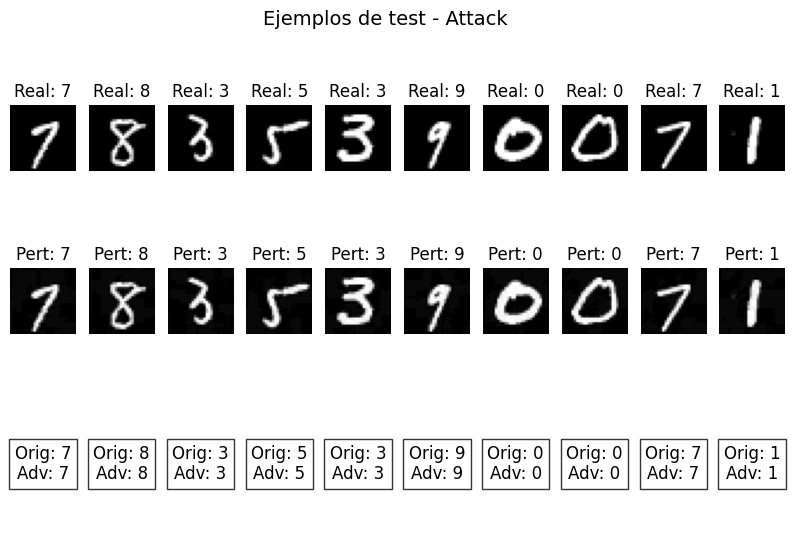

In [124]:
attack = FFGSM(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [125]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 241/250 (96.40%)
Cambio de predicción en 7/250 imágenes (2.80%)


(np.float64(0.988), np.float64(0.964), np.float64(0.028))

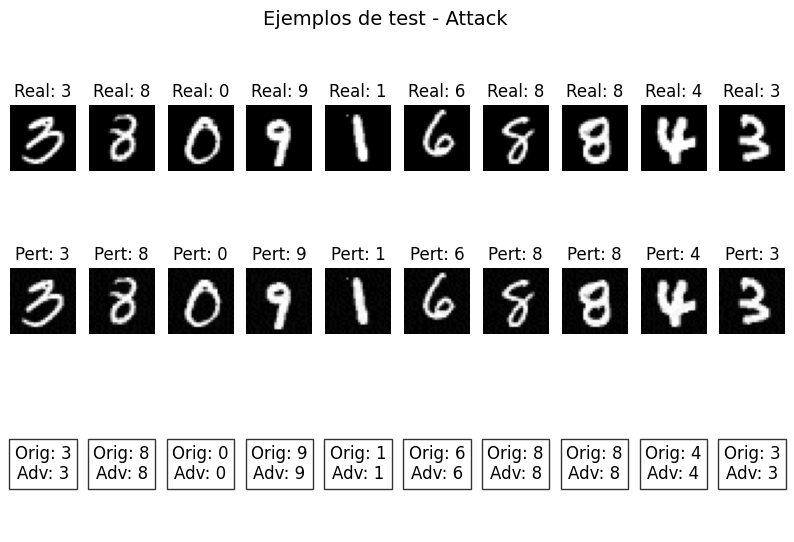

In [126]:
attack = FFGSM(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [127]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 245/250 (98.00%)
Aciertos después del ataque: 244/250 (97.60%)
Cambio de predicción en 1/250 imágenes (0.40%)


(np.float64(0.98), np.float64(0.976), np.float64(0.004))

## 19. GN

In [128]:
import torch


class GN(Attack):
    r"""
    Add Gaussian Noise.

    Arguments:
        model (nn.Module): model to attack.
        std (nn.Module): standard deviation (Default: 0.1).

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.GN(model)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, std=0.1):
        super().__init__("GN", model)
        self.std = std
        self.supported_mode = ["default"]

    def forward(self, images, labels=None):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        adv_images = images + self.std * torch.randn_like(images)
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images

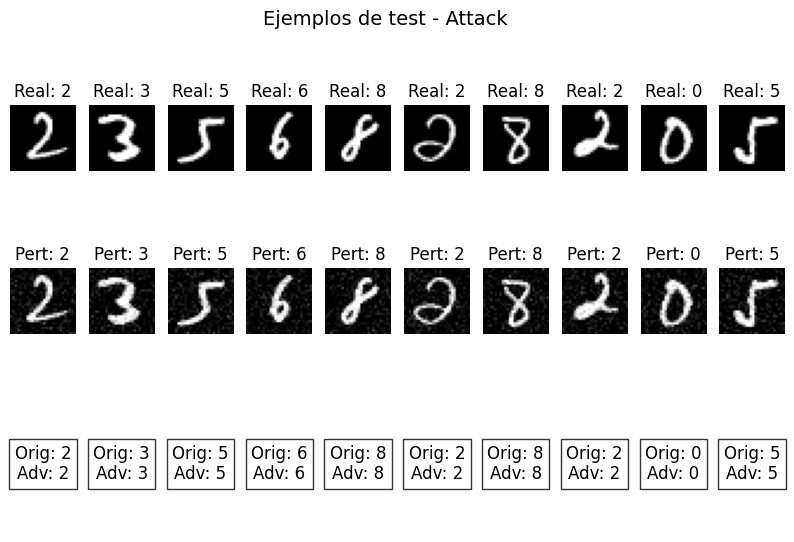

In [129]:
attack = GN(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [130]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 249/250 (99.60%)
Aciertos después del ataque: 247/250 (98.80%)
Cambio de predicción en 2/250 imágenes (0.80%)


(np.float64(0.996), np.float64(0.988), np.float64(0.008))

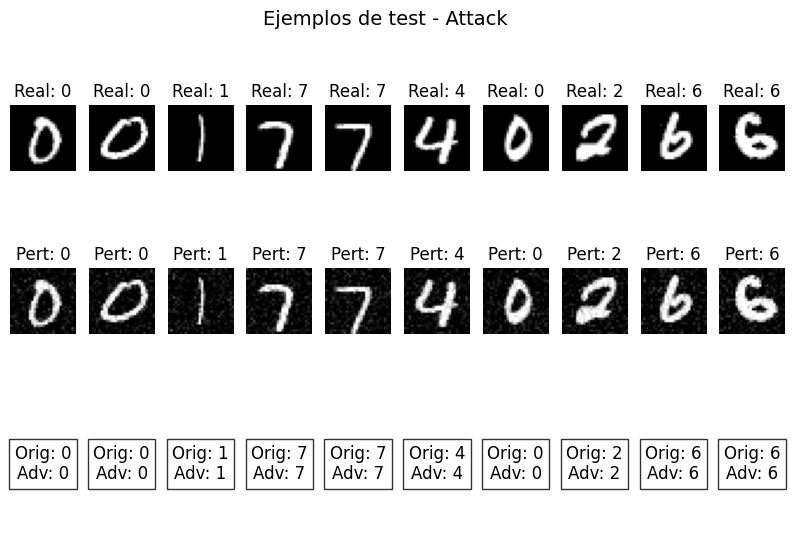

In [131]:
attack = GN(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [132]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 245/250 (98.00%)
Cambio de predicción en 2/250 imágenes (0.80%)


(np.float64(0.988), np.float64(0.98), np.float64(0.008))

## 20. Jitter

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Jitter(Attack):
    r"""
    Jitter in the paper 'Exploring Misclassifications of Robust Neural Networks to Enhance Adversarial Attacks'
    [https://arxiv.org/abs/2105.10304]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 10)
        random_start (bool): using random initialization of delta. (Default: True)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.Jitter(model, eps=8/255, alpha=2/255, steps=10,
                 scale=10, std=0.1, random_start=True)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        eps=8 / 255,
        alpha=2 / 255,
        steps=10,
        scale=10,
        std=0.1,
        random_start=True,
    ):
        super().__init__("Jitter", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.scale = scale
        self.std = std
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.MSELoss(reduction="none")

        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(
                -self.eps, self.eps
            )
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            logits = self.get_logits(adv_images)

            _, pre = torch.max(logits, dim=1)
            wrong = pre != labels

            norm_z = torch.norm(logits, p=float("inf"), dim=1, keepdim=True)
            hat_z = nn.Softmax(dim=1)(self.scale * logits / norm_z)

            if self.std != 0:
                hat_z = hat_z + self.std * torch.randn_like(hat_z)

            # Calculate loss
            if self.targeted:
                target_Y = F.one_hot(
                    target_labels, num_classes=logits.shape[-1]
                ).float()
                cost = -loss(hat_z, target_Y).mean(dim=1)
            else:
                Y = F.one_hot(labels, num_classes=logits.shape[-1]).float()
                cost = loss(hat_z, Y).mean(dim=1)

            norm_r = torch.norm(
                (adv_images - images), p=float("inf"), dim=[1, 2, 3]
            )  # nopep8
            nonzero_r = norm_r != 0
            cost[wrong * nonzero_r] /= norm_r[wrong * nonzero_r]

            cost = cost.mean()

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(
                adv_images - images, min=-self.eps, max=self.eps
            )  # nopep8
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

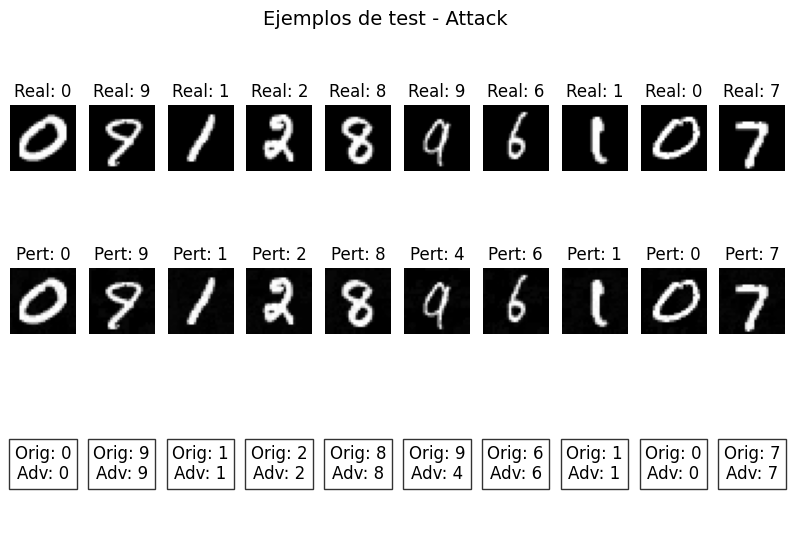

In [137]:
attack = Jitter(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [138]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 229/250 (91.60%)
Cambio de predicción en 19/250 imágenes (7.60%)


(np.float64(0.988), np.float64(0.916), np.float64(0.076))

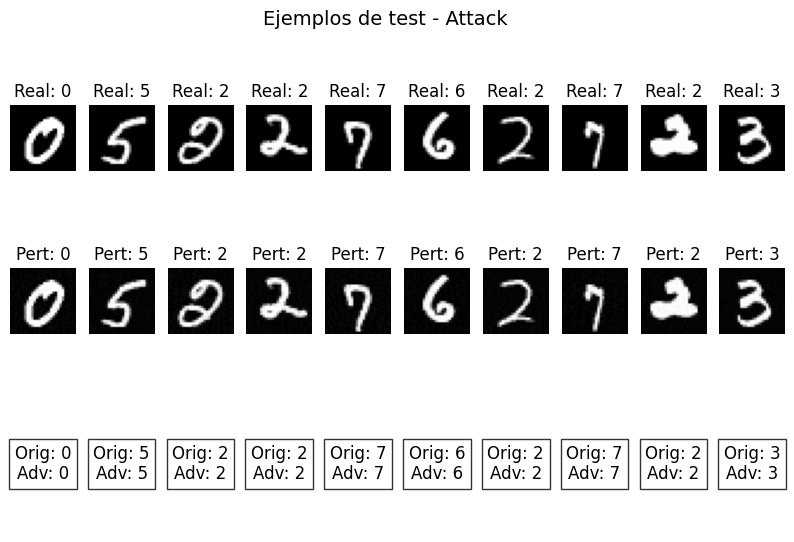

In [139]:
attack = Jitter(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [140]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 249/250 (99.60%)
Aciertos después del ataque: 248/250 (99.20%)
Cambio de predicción en 1/250 imágenes (0.40%)


(np.float64(0.996), np.float64(0.992), np.float64(0.004))

## 21. JSMA

In [141]:
import torch
import numpy as np

class JSMA(Attack):
    r"""
    Jacobian Saliency Map Attack in the paper 'The Limitations of Deep Learning in Adversarial Settings'
    [https://arxiv.org/abs/1511.07528v1]

    Distance Measure : L0

    Arguments:
        model (nn.Module): model to attack.
        theta (float): perturb length, range is either [theta, 0], [0, theta]. (Default: 1.0)
        gamma (float): highest percentage of pixels can be modified. (Default: 0.1)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.JSMA(model, theta=1.0, gamma=0.1)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, theta=1.0, gamma=0.1):
        super().__init__("JSMA", model)
        self.theta = theta
        self.gamma = gamma
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)
        else:
            # Because the JSMA algorithm does not use any loss function,
            # it cannot perform untargeted attacks indeed
            # (we have no control over the convergence of the attack to a data point that is NOT equal to the original class),
            # so we make the default setting of the target label is right circular shift
            # to make attack work if user didn't set target label.
            target_labels = (labels + 1) % 10

        adv_images = None
        for im, tl in zip(images, target_labels):
            # Since the attack uses the Jacobian-matrix,
            # if we input a large number of images directly into it,
            # the processing will be very complicated,
            # here, in order to simplify the processing,
            # we only process one image at a time.
            # Shape of MNIST is [-1, 1, 28, 28],
            # and shape of CIFAR10 is [-1, 3, 32, 32].
            pert_image = self.perturbation_single(
                torch.unsqueeze(im, 0), torch.unsqueeze(tl, 0)
            )
            try:
                adv_images = torch.cat((adv_images, pert_image), 0)
            except Exception:
                adv_images = pert_image

        adv_images = torch.clamp(adv_images, min=0, max=1)
        return adv_images

    def compute_jacobian(self, image):
        var_image = image.clone().detach()
        var_image.requires_grad = True
        output = self.get_logits(var_image)

        num_features = int(np.prod(var_image.shape[1:]))
        jacobian = torch.zeros([output.shape[1], num_features])
        for i in range(output.shape[1]):
            if var_image.grad is not None:
                var_image.grad.zero_()
            output[0][i].backward(retain_graph=True)
            # Copy the derivative to the target place
            jacobian[i] = (
                var_image.grad.squeeze().view(-1, num_features).clone()
            )  # nopep8

        return jacobian.to(self.device)

    @torch.no_grad()
    def saliency_map(
        self, jacobian, target_label, increasing, search_space, nb_features
    ):
        # The search domain
        domain = torch.eq(search_space, 1).float()
        # The sum of all features' derivative with respect to each class
        all_sum = torch.sum(jacobian, dim=0, keepdim=True)
        # The forward derivative of the target class
        target_grad = jacobian[target_label]
        # The sum of forward derivative of other classes
        others_grad = all_sum - target_grad

        # This list blanks out those that are not in the search domain
        if increasing:
            increase_coef = 2 * (torch.eq(domain, 0)).float().to(self.device)
        else:
            increase_coef = -1 * 2 * (torch.eq(domain, 0)).float().to(self.device)
        increase_coef = increase_coef.view(-1, nb_features)

        # Calculate sum of target forward derivative of any 2 features.
        target_tmp = target_grad.clone()
        target_tmp -= increase_coef * torch.max(torch.abs(target_grad))
        # PyTorch will automatically extend the dimensions
        alpha = target_tmp.view(-1, 1, nb_features) + target_tmp.view(
            -1, nb_features, 1
        )
        # Calculate sum of other forward derivative of any 2 features.
        others_tmp = others_grad.clone()
        others_tmp += increase_coef * torch.max(torch.abs(others_grad))
        beta = others_tmp.view(-1, 1, nb_features) + others_tmp.view(-1, nb_features, 1)

        # Zero out the situation where a feature sums with itself
        tmp = np.ones((nb_features, nb_features), int)
        np.fill_diagonal(tmp, 0)
        zero_diagonal = torch.from_numpy(tmp).byte().to(self.device)

        # According to the definition of saliency map in the paper (formulas 8 and 9),
        # those elements in the saliency map that doesn't satisfy the requirement will be blanked out.
        if increasing:
            mask1 = torch.gt(alpha, 0.0)
            mask2 = torch.lt(beta, 0.0)
        else:
            mask1 = torch.lt(alpha, 0.0)
            mask2 = torch.gt(beta, 0.0)

        # Apply the mask to the saliency map
        mask = torch.mul(torch.mul(mask1, mask2), zero_diagonal.view_as(mask1))
        # Do the multiplication according to formula 10 in the paper
        saliency_map = torch.mul(torch.mul(alpha, torch.abs(beta)), mask.float())
        # Get the most significant two pixels
        max_idx = torch.argmax(saliency_map.view(-1, nb_features * nb_features), dim=1)
        # p = max_idx // nb_features
        p = torch.div(max_idx, nb_features, rounding_mode="floor")
        # q = max_idx % nb_features
        q = max_idx - p * nb_features
        return p, q

    def perturbation_single(self, image, target_label):
        """
        image: only one element
        label: only one element
        """
        var_image = image
        var_label = target_label
        var_image = var_image.to(self.device)
        var_label = var_label.to(self.device)

        if self.theta > 0:
            increasing = True
        else:
            increasing = False

        num_features = int(np.prod(var_image.shape[1:]))
        shape = var_image.shape

        # Perturb two pixels in one iteration, thus max_iters is divided by 2
        max_iters = int(np.ceil(num_features * self.gamma / 2.0))

        # Masked search domain, if the pixel has already reached the top or bottom, we don't bother to modify it
        if increasing:
            search_domain = torch.lt(var_image, 0.99)
        else:
            search_domain = torch.gt(var_image, 0.01)

        search_domain = search_domain.view(num_features)
        output = self.get_logits(var_image)
        current_pred = torch.argmax(output.data, 1)

        iter = 0
        while (
            (iter < max_iters)
            and (current_pred != target_label)
            and (search_domain.sum() != 0)
        ):
            # Calculate Jacobian matrix of forward derivative
            jacobian = self.compute_jacobian(var_image)
            # Get the saliency map and calculate the two pixels that have the greatest influence
            p1, p2 = self.saliency_map(
                jacobian, var_label, increasing, search_domain, num_features
            )
            # Apply modifications
            # var_sample_flatten = var_image.view(-1, num_features).clone().detach_()
            var_sample_flatten = var_image.view(-1, num_features)
            var_sample_flatten[0, p1] += self.theta
            var_sample_flatten[0, p2] += self.theta

            new_image = torch.clamp(var_sample_flatten, min=0.0, max=1.0)
            new_image = new_image.view(shape)
            search_domain[p1] = 0
            search_domain[p2] = 0
            # var_image = new_image.clone().detach().to(self.device)
            var_image = new_image.to(self.device)

            output = self.get_logits(var_image)
            current_pred = torch.argmax(output.data, 1)
            iter += 1

        adv_image = var_image
        return adv_image

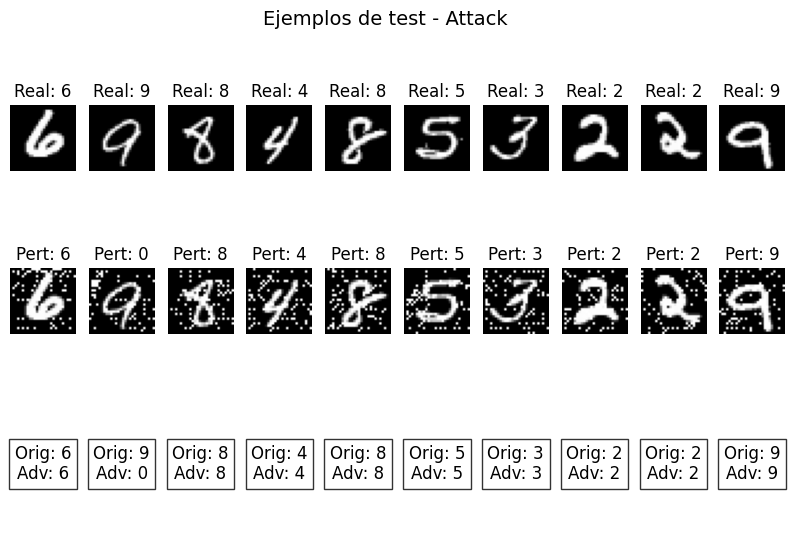

In [150]:
attack = JSMA(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [151]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 249/250 (99.60%)
Aciertos después del ataque: 182/250 (72.80%)
Cambio de predicción en 69/250 imágenes (27.60%)


(np.float64(0.996), np.float64(0.728), np.float64(0.276))

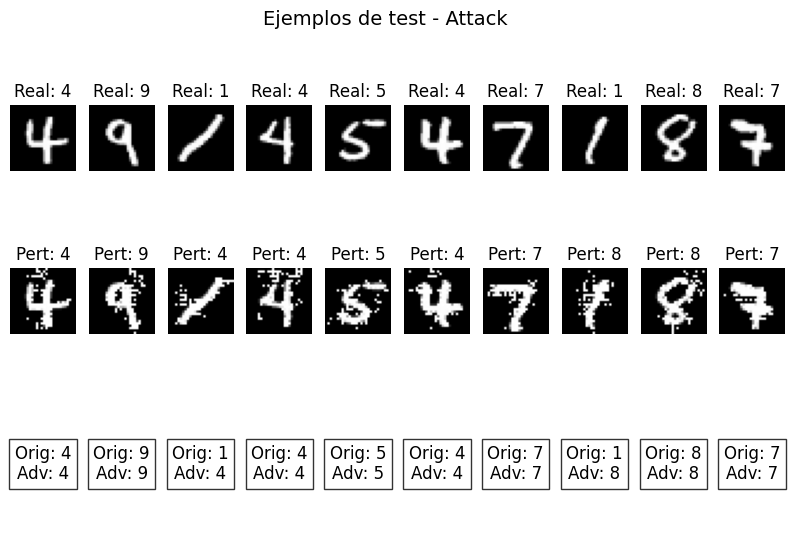

In [152]:
attack = JSMA(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [153]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 248/250 (99.20%)
Aciertos después del ataque: 167/250 (66.80%)
Cambio de predicción en 83/250 imágenes (33.20%)


(np.float64(0.992), np.float64(0.668), np.float64(0.332))

## 22. MIFGSM

In [145]:
import torch
import torch.nn as nn


class MIFGSM(Attack):
    r"""
    MI-FGSM in the paper 'Boosting Adversarial Attacks with Momentum'
    [https://arxiv.org/abs/1710.06081]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        decay (float): momentum factor. (Default: 1.0)
        steps (int): number of iterations. (Default: 10)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.MIFGSM(model, eps=8/255, steps=10, decay=1.0)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, eps=8 / 255, alpha=2 / 255, steps=10, decay=1.0):
        super().__init__("MIFGSM", model)
        self.eps = eps
        self.steps = steps
        self.decay = decay
        self.alpha = alpha
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        momentum = torch.zeros_like(images).detach().to(self.device)

        loss = nn.CrossEntropyLoss()

        adv_images = images.clone().detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]

            grad = grad / torch.mean(torch.abs(grad), dim=(1, 2, 3), keepdim=True)
            grad = grad + momentum * self.decay
            momentum = grad

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

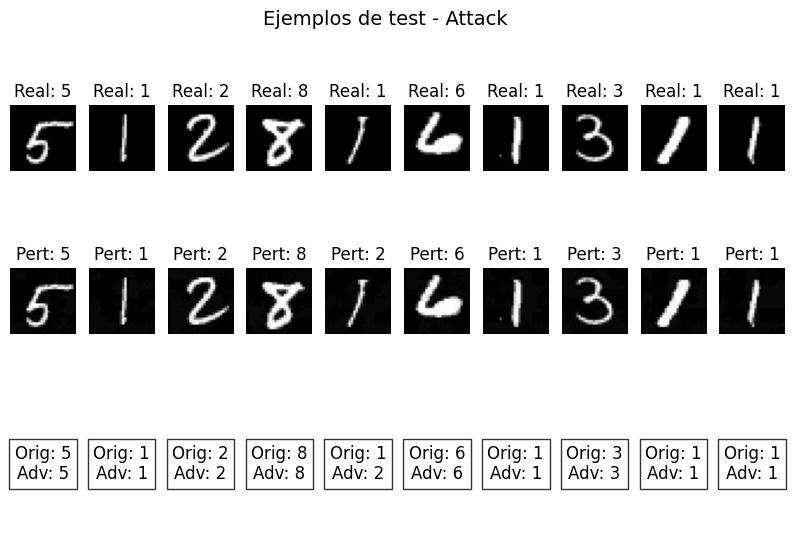

In [146]:
attack = MIFGSM(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [147]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 245/250 (98.00%)
Aciertos después del ataque: 203/250 (81.20%)
Cambio de predicción en 42/250 imágenes (16.80%)


(np.float64(0.98), np.float64(0.812), np.float64(0.168))

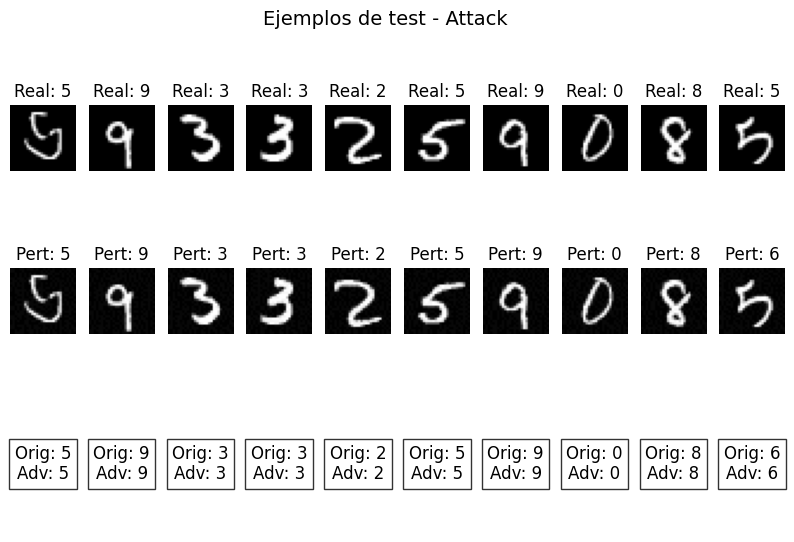

In [148]:
attack = MIFGSM(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [149]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 245/250 (98.00%)
Aciertos después del ataque: 243/250 (97.20%)
Cambio de predicción en 3/250 imágenes (1.20%)


(np.float64(0.98), np.float64(0.972), np.float64(0.012))

## 23. NIFGSM

In [154]:
import torch
import torch.nn as nn


class NIFGSM(Attack):
    r"""
    NI-FGSM in the paper 'NESTEROV ACCELERATED GRADIENT AND SCALEINVARIANCE FOR ADVERSARIAL ATTACKS'
    [https://arxiv.org/abs/1908.06281], Published as a conference paper at ICLR 2020

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        decay (float): momentum factor. (Default: 1.0)
        steps (int): number of iterations. (Default: 10)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.NIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=1.0)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, eps=8 / 255, alpha=2 / 255, steps=10, decay=1.0):
        super().__init__("NIFGSM", model)
        self.eps = eps
        self.steps = steps
        self.decay = decay
        self.alpha = alpha
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        momentum = torch.zeros_like(images).detach().to(self.device)

        loss = nn.CrossEntropyLoss()

        adv_images = images.clone().detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            nes_images = adv_images + self.decay * self.alpha * momentum
            outputs = self.get_logits(nes_images)
            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]
            grad = self.decay * momentum + grad / torch.mean(
                torch.abs(grad), dim=(1, 2, 3), keepdim=True
            )
            momentum = grad
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

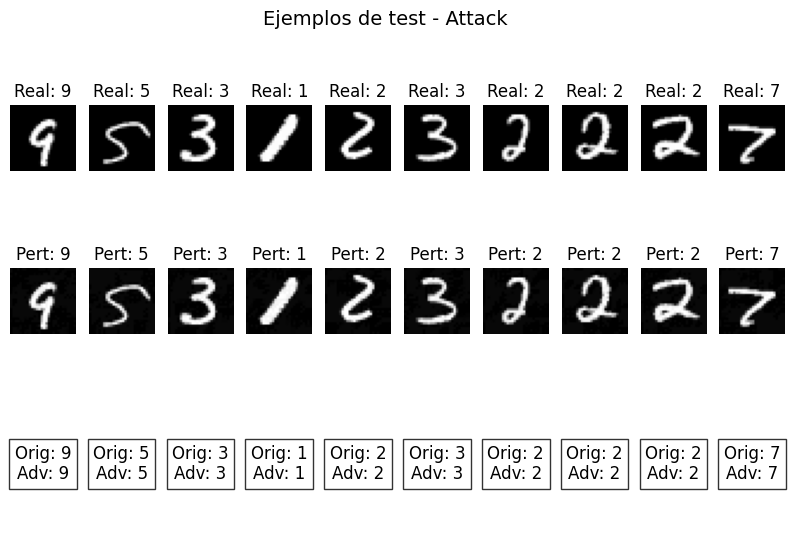

In [155]:
attack = NIFGSM(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [156]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 241/250 (96.40%)
Aciertos después del ataque: 237/250 (94.80%)
Cambio de predicción en 6/250 imágenes (2.40%)


(np.float64(0.964), np.float64(0.948), np.float64(0.024))

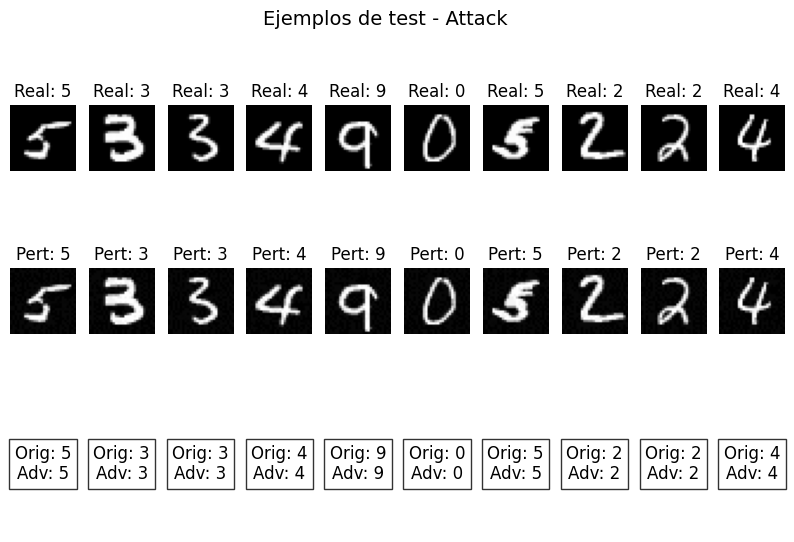

In [157]:
attack = NIFGSM(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [158]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 249/250 (99.60%)
Aciertos después del ataque: 248/250 (99.20%)
Cambio de predicción en 1/250 imágenes (0.40%)


(np.float64(0.996), np.float64(0.992), np.float64(0.004))

## 24. OnePixel

In [159]:
"""
Copied from "https://github.com/DebangLi/one-pixel-attack-pytorch/"

A slight modification to Scipy's implementation of differential evolution. To speed up predictions, the entire parameters array is passed to `self.func`, where a neural network model can batch its computations.
Taken from
https://github.com/scipy/scipy/blob/70e61dee181de23fdd8d893eaa9491100e2218d7/scipy/optimize/_differentialevolution.py
----------
differential_evolution: The differential evolution global optimization algorithm
Added by Andrew Nelson 2014
"""
from __future__ import division, print_function, absolute_import
import numpy as np
from scipy.optimize import OptimizeResult, minimize

# from scipy.optimize.optimize import _status_message % for version < 1.8
# from scipy.optimize.optimize_ import _status_message % for version >= 1.8
from scipy._lib._util import check_random_state


__all__ = ["differential_evolution"]
_status_message = {
    "success": "Optimization terminated successfully.",
    "maxfev": "Maximum number of function evaluations has " "been exceeded.",
    "maxiter": "Maximum number of iterations has been " "exceeded.",
    "pr_loss": "Desired error not necessarily achieved due " "to precision loss.",
    "nan": "NaN result encountered.",
    "out_of_bounds": "The result is outside of the provided " "bounds.",
}

_MACHEPS = np.finfo(np.float64).eps


def differential_evolution(
    func,
    bounds,
    args=(),
    strategy="best1bin",
    maxiter=1000,
    popsize=15,
    tol=0.01,
    mutation=(0.5, 1),
    recombination=0.7,
    seed=None,
    callback=None,
    disp=False,
    polish=True,
    init="latinhypercube",
    atol=0,
):
    """Finds the global minimum of a multivariate function.
    Differential Evolution is stochastic in nature (does not use gradient
    methods) to find the minimium, and can search large areas of candidate
    space, but often requires larger numbers of function evaluations than
    conventional gradient based techniques.
    The algorithm is due to Storn and Price [1]_.
    Parameters
    ----------
    func : callable
        The objective function to be minimized.  Must be in the form
        ``f(x, *args)``, where ``x`` is the argument in the form of a 1-D array
        and ``args`` is a  tuple of any additional fixed parameters needed to
        completely specify the function.
    bounds : sequence
        Bounds for variables.  ``(min, max)`` pairs for each element in ``x``,
        defining the lower and upper bounds for the optimizing argument of
        `func`. It is required to have ``len(bounds) == len(x)``.
        ``len(bounds)`` is used to determine the number of parameters in ``x``.
    args : tuple, optional
        Any additional fixed parameters needed to
        completely specify the objective function.
    strategy : str, optional
        The differential evolution strategy to use. Should be one of:
            - 'best1bin'
            - 'best1exp'
            - 'rand1exp'
            - 'randtobest1exp'
            - 'currenttobest1exp'
            - 'best2exp'
            - 'rand2exp'
            - 'randtobest1bin'
            - 'currenttobest1bin'
            - 'best2bin'
            - 'rand2bin'
            - 'rand1bin'
        The default is 'best1bin'.
    maxiter : int, optional
        The maximum number of generations over which the entire population is
        evolved. The maximum number of function evaluations (with no polishing)
        is: ``(maxiter + 1) * popsize * len(x)``
    popsize : int, optional
        A multiplier for setting the total population size.  The population has
        ``popsize * len(x)`` individuals (unless the initial population is
        supplied via the `init` keyword).
    tol : float, optional
        Relative tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    mutation : float or tuple(float, float), optional
        The mutation constant. In the literature this is also known as
        differential weight, being denoted by F.
        If specified as a float it should be in the range [0, 2].
        If specified as a tuple ``(min, max)`` dithering is employed. Dithering
        randomly changes the mutation constant on a generation by generation
        basis. The mutation constant for that generation is taken from
        ``U[min, max)``. Dithering can help speed convergence significantly.
        Increasing the mutation constant increases the search radius, but will
        slow down convergence.
    recombination : float, optional
        The recombination constant, should be in the range [0, 1]. In the
        literature this is also known as the crossover probability, being
        denoted by CR. Increasing this value allows a larger number of mutants
        to progress into the next generation, but at the risk of population
        stability.
    seed : int or `np.random.RandomState`, optional
        If `seed` is not specified the `np.RandomState` singleton is used.
        If `seed` is an int, a new `np.random.RandomState` instance is used,
        seeded with seed.
        If `seed` is already a `np.random.RandomState instance`, then that
        `np.random.RandomState` instance is used.
        Specify `seed` for repeatable minimizations.
    disp : bool, optional
        Display status messages
    callback : callable, `callback(xk, convergence=val)`, optional
        A function to follow the progress of the minimization. ``xk`` is
        the current value of ``x0``. ``val`` represents the fractional
        value of the population convergence.  When ``val`` is greater than one
        the function halts. If callback returns `True`, then the minimization
        is halted (any polishing is still carried out).
    polish : bool, optional
        If True (default), then `scipy.optimize.minimize` with the `L-BFGS-B`
        method is used to polish the best population member at the end, which
        can improve the minimization slightly.
    init : str or array-like, optional
        Specify which type of population initialization is performed. Should be
        one of:
            - 'latinhypercube'
            - 'random'
            - array specifying the initial population. The array should have
              shape ``(M, len(x))``, where len(x) is the number of parameters.
              `init` is clipped to `bounds` before use.
        The default is 'latinhypercube'. Latin Hypercube sampling tries to
        maximize coverage of the available parameter space. 'random'
        initializes the population randomly - this has the drawback that
        clustering can occur, preventing the whole of parameter space being
        covered. Use of an array to specify a population subset could be used,
        for example, to create a tight bunch of initial guesses in an location
        where the solution is known to exist, thereby reducing time for
        convergence.
    atol : float, optional
        Absolute tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a `OptimizeResult` object.
        Important attributes are: ``x`` the solution array, ``success`` a
        Boolean flag indicating if the optimizer exited successfully and
        ``message`` which describes the cause of the termination. See
        `OptimizeResult` for a description of other attributes.  If `polish`
        was employed, and a lower minimum was obtained by the polishing, then
        OptimizeResult also contains the ``jac`` attribute.
    Notes
    -----
    Differential evolution is a stochastic population based method that is
    useful for global optimization problems. At each pass through the population
    the algorithm mutates each candidate solution by mixing with other candidate
    solutions to create a trial candidate. There are several strategies [2]_ for
    creating trial candidates, which suit some problems more than others. The
    'best1bin' strategy is a good starting point for many systems. In this
    strategy two members of the population are randomly chosen. Their difference
    is used to mutate the best member (the `best` in `best1bin`), :math:`b_0`,
    so far:
    .. math::
        b' = b_0 + mutation * (population[rand0] - population[rand1])
    A trial vector is then constructed. Starting with a randomly chosen 'i'th
    parameter the trial is sequentially filled (in modulo) with parameters from
    `b'` or the original candidate. The choice of whether to use `b'` or the
    original candidate is made with a binomial distribution (the 'bin' in
    'best1bin') - a random number in [0, 1) is generated.  If this number is
    less than the `recombination` constant then the parameter is loaded from
    `b'`, otherwise it is loaded from the original candidate.  The final
    parameter is always loaded from `b'`.  Once the trial candidate is built
    its fitness is assessed. If the trial is better than the original candidate
    then it takes its place. If it is also better than the best overall
    candidate it also replaces that.
    To improve your chances of finding a global minimum use higher `popsize`
    values, with higher `mutation` and (dithering), but lower `recombination`
    values. This has the effect of widening the search radius, but slowing
    convergence.
    .. versionadded:: 0.15.0
    Examples
    --------
    Let us consider the problem of minimizing the Rosenbrock function. This
    function is implemented in `rosen` in `scipy.optimize`.
    >>> from scipy.optimize import rosen, differential_evolution
    >>> bounds = [(0,2), (0, 2), (0, 2), (0, 2), (0, 2)]
    >>> result = differential_evolution(rosen, bounds)
    >>> result.x, result.fun
    (array([1., 1., 1., 1., 1.]), 1.9216496320061384e-19)
    Next find the minimum of the Ackley function
    (http://en.wikipedia.org/wiki/Test_functions_for_optimization).
    >>> from scipy.optimize import differential_evolution
    >>> import numpy as np
    >>> def ackley(x):
    ...     arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    ...     arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
    ...     return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e
    >>> bounds = [(-5, 5), (-5, 5)]
    >>> result = differential_evolution(ackley, bounds)
    >>> result.x, result.fun
    (array([ 0.,  0.]), 4.4408920985006262e-16)
    References
    ----------
    .. [1] Storn, R and Price, K, Differential Evolution - a Simple and
           Efficient Heuristic for Global Optimization over Continuous Spaces,
           Journal of Global Optimization, 1997, 11, 341 - 359.
    .. [2] http://www1.icsi.berkeley.edu/~storn/code.html
    .. [3] http://en.wikipedia.org/wiki/Differential_evolution
    """

    solver = DifferentialEvolutionSolver(
        func,
        bounds,
        args=args,
        strategy=strategy,
        maxiter=maxiter,
        popsize=popsize,
        tol=tol,
        mutation=mutation,
        recombination=recombination,
        seed=seed,
        polish=polish,
        callback=callback,
        disp=disp,
        init=init,
        atol=atol,
    )
    return solver.solve()


class DifferentialEvolutionSolver(object):

    """This class implements the differential evolution solver
    Parameters
    ----------
    func : callable
        The objective function to be minimized.  Must be in the form
        ``f(x, *args)``, where ``x`` is the argument in the form of a 1-D array
        and ``args`` is a  tuple of any additional fixed parameters needed to
        completely specify the function.
    bounds : sequence
        Bounds for variables.  ``(min, max)`` pairs for each element in ``x``,
        defining the lower and upper bounds for the optimizing argument of
        `func`. It is required to have ``len(bounds) == len(x)``.
        ``len(bounds)`` is used to determine the number of parameters in ``x``.
    args : tuple, optional
        Any additional fixed parameters needed to
        completely specify the objective function.
    strategy : str, optional
        The differential evolution strategy to use. Should be one of:
            - 'best1bin'
            - 'best1exp'
            - 'rand1exp'
            - 'randtobest1exp'
            - 'currenttobest1exp'
            - 'best2exp'
            - 'rand2exp'
            - 'randtobest1bin'
            - 'currenttobest1bin'
            - 'best2bin'
            - 'rand2bin'
            - 'rand1bin'
        The default is 'best1bin'
    maxiter : int, optional
        The maximum number of generations over which the entire population is
        evolved. The maximum number of function evaluations (with no polishing)
        is: ``(maxiter + 1) * popsize * len(x)``
    popsize : int, optional
        A multiplier for setting the total population size.  The population has
        ``popsize * len(x)`` individuals (unless the initial population is
        supplied via the `init` keyword).
    tol : float, optional
        Relative tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    mutation : float or tuple(float, float), optional
        The mutation constant. In the literature this is also known as
        differential weight, being denoted by F.
        If specified as a float it should be in the range [0, 2].
        If specified as a tuple ``(min, max)`` dithering is employed. Dithering
        randomly changes the mutation constant on a generation by generation
        basis. The mutation constant for that generation is taken from
        U[min, max). Dithering can help speed convergence significantly.
        Increasing the mutation constant increases the search radius, but will
        slow down convergence.
    recombination : float, optional
        The recombination constant, should be in the range [0, 1]. In the
        literature this is also known as the crossover probability, being
        denoted by CR. Increasing this value allows a larger number of mutants
        to progress into the next generation, but at the risk of population
        stability.
    seed : int or `np.random.RandomState`, optional
        If `seed` is not specified the `np.random.RandomState` singleton is
        used.
        If `seed` is an int, a new `np.random.RandomState` instance is used,
        seeded with `seed`.
        If `seed` is already a `np.random.RandomState` instance, then that
        `np.random.RandomState` instance is used.
        Specify `seed` for repeatable minimizations.
    disp : bool, optional
        Display status messages
    callback : callable, `callback(xk, convergence=val)`, optional
        A function to follow the progress of the minimization. ``xk`` is
        the current value of ``x0``. ``val`` represents the fractional
        value of the population convergence.  When ``val`` is greater than one
        the function halts. If callback returns `True`, then the minimization
        is halted (any polishing is still carried out).
    polish : bool, optional
        If True, then `scipy.optimize.minimize` with the `L-BFGS-B` method
        is used to polish the best population member at the end. This requires
        a few more function evaluations.
    maxfun : int, optional
        Set the maximum number of function evaluations. However, it probably
        makes more sense to set `maxiter` instead.
    init : str or array-like, optional
        Specify which type of population initialization is performed. Should be
        one of:
            - 'latinhypercube'
            - 'random'
            - array specifying the initial population. The array should have
              shape ``(M, len(x))``, where len(x) is the number of parameters.
              `init` is clipped to `bounds` before use.
        The default is 'latinhypercube'. Latin Hypercube sampling tries to
        maximize coverage of the available parameter space. 'random'
        initializes the population randomly - this has the drawback that
        clustering can occur, preventing the whole of parameter space being
        covered. Use of an array to specify a population could be used, for
        example, to create a tight bunch of initial guesses in an location
        where the solution is known to exist, thereby reducing time for
        convergence.
    atol : float, optional
        Absolute tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    """

    # Dispatch of mutation strategy method (binomial or exponential).
    _binomial = {
        "best1bin": "_best1",
        "randtobest1bin": "_randtobest1",
        "currenttobest1bin": "_currenttobest1",
        "best2bin": "_best2",
        "rand2bin": "_rand2",
        "rand1bin": "_rand1",
    }
    _exponential = {
        "best1exp": "_best1",
        "rand1exp": "_rand1",
        "randtobest1exp": "_randtobest1",
        "currenttobest1exp": "_currenttobest1",
        "best2exp": "_best2",
        "rand2exp": "_rand2",
    }

    __init_error_msg = (
        "The population initialization method must be one of "
        "'latinhypercube' or 'random', or an array of shape "
        "(M, N) where N is the number of parameters and M>5"
    )

    def __init__(
        self,
        func,
        bounds,
        args=(),
        strategy="best1bin",
        maxiter=1000,
        popsize=15,
        tol=0.01,
        mutation=(0.5, 1),
        recombination=0.7,
        seed=None,
        maxfun=np.inf,
        callback=None,
        disp=False,
        polish=True,
        init="latinhypercube",
        atol=0,
    ):

        if strategy in self._binomial:
            self.mutation_func = getattr(self, self._binomial[strategy])
        elif strategy in self._exponential:
            self.mutation_func = getattr(self, self._exponential[strategy])
        else:
            raise ValueError("Please select a valid mutation strategy")
        self.strategy = strategy

        self.callback = callback
        self.polish = polish

        # relative and absolute tolerances for convergence
        self.tol, self.atol = tol, atol

        # Mutation constant should be in [0, 2). If specified as a sequence
        # then dithering is performed.
        self.scale = mutation
        if (
            not np.all(np.isfinite(mutation))
            or np.any(np.array(mutation) >= 2)
            or np.any(np.array(mutation) < 0)
        ):
            raise ValueError(
                "The mutation constant must be a float in "
                "U[0, 2), or specified as a tuple(min, max)"
                " where min < max and min, max are in U[0, 2)."
            )

        self.dither = None
        if hasattr(mutation, "__iter__") and len(mutation) > 1:
            self.dither = [mutation[0], mutation[1]]
            self.dither.sort()

        self.cross_over_probability = recombination

        self.func = func
        self.args = args

        # convert tuple of lower and upper bounds to limits
        # [(low_0, high_0), ..., (low_n, high_n]
        #     -> [[low_0, ..., low_n], [high_0, ..., high_n]]
        self.limits = np.array(bounds, dtype="float").T
        if np.size(self.limits, 0) != 2 or not np.all(np.isfinite(self.limits)):
            raise ValueError(
                "bounds should be a sequence containing "
                "real valued (min, max) pairs for each value"
                " in x"
            )

        if maxiter is None:  # the default used to be None
            maxiter = 1000
        self.maxiter = maxiter
        if maxfun is None:  # the default used to be None
            maxfun = np.inf
        self.maxfun = maxfun

        # population is scaled to between [0, 1].
        # We have to scale between parameter <-> population
        # save these arguments for _scale_parameter and
        # _unscale_parameter. This is an optimization
        self.__scale_arg1 = 0.5 * (self.limits[0] + self.limits[1])
        self.__scale_arg2 = np.fabs(self.limits[0] - self.limits[1])

        self.parameter_count = np.size(self.limits, 1)

        self.random_number_generator = check_random_state(seed)

        # default population initialization is a latin hypercube design, but
        # there are other population initializations possible.
        # the minimum is 5 because 'best2bin' requires a population that's at
        # least 5 long
        self.num_population_members = max(5, popsize * self.parameter_count)

        self.population_shape = (self.num_population_members, self.parameter_count)

        self._nfev = 0
        if isinstance(init, str):
            if init == "latinhypercube":
                self.init_population_lhs()
            elif init == "random":
                self.init_population_random()
            else:
                raise ValueError(self.__init_error_msg)
        else:
            self.init_population_array(init)

        self.disp = disp

    def init_population_lhs(self):
        """
        Initializes the population with Latin Hypercube Sampling.
        Latin Hypercube Sampling ensures that each parameter is uniformly
        sampled over its range.
        """
        rng = self.random_number_generator

        # Each parameter range needs to be sampled uniformly. The scaled
        # parameter range ([0, 1)) needs to be split into
        # `self.num_population_members` segments, each of which has the following
        # size:
        segsize = 1.0 / self.num_population_members

        # Within each segment we sample from a uniform random distribution.
        # We need to do this sampling for each parameter.
        samples = (
            segsize * rng.random_sample(self.population_shape)
            # Offset each segment to cover the entire parameter range [0, 1)
            + np.linspace(0.0, 1.0, self.num_population_members, endpoint=False)[
                :, np.newaxis
            ]
        )

        # Create an array for population of candidate solutions.
        self.population = np.zeros_like(samples)

        # Initialize population of candidate solutions by permutation of the
        # random samples.
        for j in range(self.parameter_count):
            order = rng.permutation(range(self.num_population_members))
            self.population[:, j] = samples[order, j]

        # reset population energies
        self.population_energies = np.ones(self.num_population_members) * np.inf

        # reset number of function evaluations counter
        self._nfev = 0

    def init_population_random(self):
        """
        Initialises the population at random.  This type of initialization
        can possess clustering, Latin Hypercube sampling is generally better.
        """
        rng = self.random_number_generator
        self.population = rng.random_sample(self.population_shape)

        # reset population energies
        self.population_energies = np.ones(self.num_population_members) * np.inf

        # reset number of function evaluations counter
        self._nfev = 0

    def init_population_array(self, init):
        """
        Initialises the population with a user specified population.
        Parameters
        ----------
        init : np.ndarray
            Array specifying subset of the initial population. The array should
            have shape (M, len(x)), where len(x) is the number of parameters.
            The population is clipped to the lower and upper `bounds`.
        """
        # make sure you're using a float array
        popn = np.asfarray(init)

        if (
            np.size(popn, 0) < 5
            or popn.shape[1] != self.parameter_count
            or len(popn.shape) != 2
        ):
            raise ValueError(
                "The population supplied needs to have shape"
                " (M, len(x)), where M > 4."
            )

        # scale values and clip to bounds, assigning to population
        self.population = np.clip(self._unscale_parameters(popn), 0, 1)

        self.num_population_members = np.size(self.population, 0)

        self.population_shape = (self.num_population_members, self.parameter_count)

        # reset population energies
        self.population_energies = np.ones(self.num_population_members) * np.inf

        # reset number of function evaluations counter
        self._nfev = 0

    @property
    def x(self):
        """
        The best solution from the solver
        Returns
        -------
        x : ndarray
            The best solution from the solver.
        """
        return self._scale_parameters(self.population[0])

    @property
    def convergence(self):
        """
        The standard deviation of the population energies divided by their
        mean.
        """
        return np.std(self.population_energies) / np.abs(
            np.mean(self.population_energies) + _MACHEPS
        )

    def solve(self):
        """
        Runs the DifferentialEvolutionSolver.
        Returns
        -------
        res : OptimizeResult
            The optimization result represented as a ``OptimizeResult`` object.
            Important attributes are: ``x`` the solution array, ``success`` a
            Boolean flag indicating if the optimizer exited successfully and
            ``message`` which describes the cause of the termination. See
            `OptimizeResult` for a description of other attributes.  If `polish`
            was employed, and a lower minimum was obtained by the polishing,
            then OptimizeResult also contains the ``jac`` attribute.
        """
        nit, warning_flag = 0, False
        status_message = _status_message["success"]

        # The population may have just been initialized (all entries are
        # np.inf). If it has you have to calculate the initial energies.
        # Although this is also done in the evolve generator it's possible
        # that someone can set maxiter=0, at which point we still want the
        # initial energies to be calculated (the following loop isn't run).
        if np.all(np.isinf(self.population_energies)):
            self._calculate_population_energies()

        # do the optimisation.
        for nit in range(1, self.maxiter + 1):
            # evolve the population by a generation
            try:
                next(self)
            except StopIteration:
                warning_flag = True
                status_message = _status_message["maxfev"]
                break

            if self.disp:
                print(
                    "differential_evolution step %d: f(x)= %g"
                    % (nit, self.population_energies[0])
                )

            # should the solver terminate?
            convergence = self.convergence
            if convergence != 0:
                conv = self.tol / convergence
            else:
                if np.sign(self.tol) > 0:
                    conv = float("inf")
                elif np.sign(self.tol) == 0:
                    conv = 1  # 0/0 = 1
                else:
                    conv = float("-inf")

            if (
                self.callback
                and self.callback(
                    self._scale_parameters(self.population[0]), convergence=conv
                )
                is True
            ):

                warning_flag = True
                status_message = (
                    "callback function requested stop early " "by returning True"
                )
                break

            intol = np.std(self.population_energies) <= self.atol + self.tol * np.abs(
                np.mean(self.population_energies)
            )
            if warning_flag or intol:
                break

        else:
            status_message = _status_message["maxiter"]
            warning_flag = True

        DE_result = OptimizeResult(
            x=self.x,
            fun=self.population_energies[0],
            nfev=self._nfev,
            nit=nit,
            message=status_message,
            success=(warning_flag is not True),
        )

        if self.polish:
            result = minimize(
                self.func,
                np.copy(DE_result.x),
                method="L-BFGS-B",
                bounds=self.limits.T,
                args=self.args,
            )

            self._nfev += result.nfev
            DE_result.nfev = self._nfev

            if result.fun < DE_result.fun:
                DE_result.fun = result.fun
                DE_result.x = result.x
                DE_result.jac = result.jac
                # to keep internal state consistent
                self.population_energies[0] = result.fun
                self.population[0] = self._unscale_parameters(result.x)

        return DE_result

    def _calculate_population_energies(self):
        """
        Calculate the energies of all the population members at the same time.
        Puts the best member in first place. Useful if the population has just
        been initialised.
        """

        ##############
        # CHANGES: self.func operates on the entire parameters array
        ##############
        itersize = max(0, min(len(self.population), self.maxfun - self._nfev + 1))
        candidates = self.population[:itersize]
        parameters = np.array(
            [self._scale_parameters(c) for c in candidates]
        )  # TODO: vectorize
        energies = self.func(parameters, *self.args)
        self.population_energies = energies
        self._nfev += itersize

        # for index, candidate in enumerate(self.population):
        #     if self._nfev > self.maxfun:
        #         break

        #     parameters = self._scale_parameters(candidate)
        #     self.population_energies[index] = self.func(parameters,
        #                                                 *self.args)
        #     self._nfev += 1

        ##############
        ##############

        minval = np.argmin(self.population_energies)

        # put the lowest energy into the best solution position.
        lowest_energy = self.population_energies[minval]
        self.population_energies[minval] = self.population_energies[0]
        self.population_energies[0] = lowest_energy

        self.population[[0, minval], :] = self.population[[minval, 0], :]

    def __iter__(self):
        return self

    def __next__(self):
        """
        Evolve the population by a single generation
        Returns
        -------
        x : ndarray
            The best solution from the solver.
        fun : float
            Value of objective function obtained from the best solution.
        """
        # the population may have just been initialized (all entries are
        # np.inf). If it has you have to calculate the initial energies
        if np.all(np.isinf(self.population_energies)):
            self._calculate_population_energies()

        if self.dither is not None:
            self.scale = (
                self.random_number_generator.rand() * (self.dither[1] - self.dither[0])
                + self.dither[0]
            )

        ##############
        # CHANGES: self.func operates on the entire parameters array
        ##############

        itersize = max(
            0, min(self.num_population_members, self.maxfun - self._nfev + 1)
        )
        trials = np.array([self._mutate(c) for c in range(itersize)])  # TODO: vectorize
        for trial in trials:
            self._ensure_constraint(trial)
        parameters = np.array([self._scale_parameters(trial) for trial in trials])
        energies = self.func(parameters, *self.args)
        self._nfev += itersize

        for candidate, (energy, trial) in enumerate(zip(energies, trials)):
            # if the energy of the trial candidate is lower than the
            # original population member then replace it
            if energy < self.population_energies[candidate]:
                self.population[candidate] = trial
                self.population_energies[candidate] = energy

                # if the trial candidate also has a lower energy than the
                # best solution then replace that as well
                if energy < self.population_energies[0]:
                    self.population_energies[0] = energy
                    self.population[0] = trial

        # for candidate in range(self.num_population_members):
        #     if self._nfev > self.maxfun:
        #         raise StopIteration

        #     # create a trial solution
        #     trial = self._mutate(candidate)

        #     # ensuring that it's in the range [0, 1)
        #     self._ensure_constraint(trial)

        #     # scale from [0, 1) to the actual parameter value
        #     parameters = self._scale_parameters(trial)

        #     # determine the energy of the objective function
        #     energy = self.func(parameters, *self.args)
        #     self._nfev += 1

        #     # if the energy of the trial candidate is lower than the
        #     # original population member then replace it
        #     if energy < self.population_energies[candidate]:
        #         self.population[candidate] = trial
        #         self.population_energies[candidate] = energy

        #         # if the trial candidate also has a lower energy than the
        #         # best solution then replace that as well
        #         if energy < self.population_energies[0]:
        #             self.population_energies[0] = energy
        #             self.population[0] = trial

        ##############
        ##############

        return self.x, self.population_energies[0]

    def next(self):
        """
        Evolve the population by a single generation
        Returns
        -------
        x : ndarray
            The best solution from the solver.
        fun : float
            Value of objective function obtained from the best solution.
        """
        # next() is required for compatibility with Python2.7.
        return self.__next__()

    def _scale_parameters(self, trial):
        """
        scale from a number between 0 and 1 to parameters.
        """
        return self.__scale_arg1 + (trial - 0.5) * self.__scale_arg2

    def _unscale_parameters(self, parameters):
        """
        scale from parameters to a number between 0 and 1.
        """
        return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5

    def _ensure_constraint(self, trial):
        """
        make sure the parameters lie between the limits
        """
        for index in np.where((trial < 0) | (trial > 1))[0]:
            trial[index] = self.random_number_generator.rand()

    def _mutate(self, candidate):
        """
        create a trial vector based on a mutation strategy
        """
        trial = np.copy(self.population[candidate])

        rng = self.random_number_generator

        fill_point = rng.randint(0, self.parameter_count)

        if self.strategy in ["currenttobest1exp", "currenttobest1bin"]:
            bprime = self.mutation_func(candidate, self._select_samples(candidate, 5))
        else:
            bprime = self.mutation_func(self._select_samples(candidate, 5))

        if self.strategy in self._binomial:
            crossovers = rng.rand(self.parameter_count)
            crossovers = crossovers < self.cross_over_probability
            # the last one is always from the bprime vector for binomial
            # If you fill in modulo with a loop you have to set the last one to
            # true. If you don't use a loop then you can have any random entry
            # be True.
            crossovers[fill_point] = True
            trial = np.where(crossovers, bprime, trial)
            return trial

        elif self.strategy in self._exponential:
            i = 0
            while i < self.parameter_count and rng.rand() < self.cross_over_probability:

                trial[fill_point] = bprime[fill_point]
                fill_point = (fill_point + 1) % self.parameter_count
                i += 1

            return trial

    def _best1(self, samples):
        """
        best1bin, best1exp
        """
        r0, r1 = samples[:2]
        return self.population[0] + self.scale * (
            self.population[r0] - self.population[r1]
        )

    def _rand1(self, samples):
        """
        rand1bin, rand1exp
        """
        r0, r1, r2 = samples[:3]
        return self.population[r0] + self.scale * (
            self.population[r1] - self.population[r2]
        )

    def _randtobest1(self, samples):
        """
        randtobest1bin, randtobest1exp
        """
        r0, r1, r2 = samples[:3]
        bprime = np.copy(self.population[r0])
        bprime += self.scale * (self.population[0] - bprime)
        bprime += self.scale * (self.population[r1] - self.population[r2])
        return bprime

    def _currenttobest1(self, candidate, samples):
        """
        currenttobest1bin, currenttobest1exp
        """
        r0, r1 = samples[:2]
        bprime = self.population[candidate] + self.scale * (
            self.population[0]
            - self.population[candidate]
            + self.population[r0]
            - self.population[r1]
        )
        return bprime

    def _best2(self, samples):
        """
        best2bin, best2exp
        """
        r0, r1, r2, r3 = samples[:4]
        bprime = self.population[0] + self.scale * (
            self.population[r0]
            + self.population[r1]
            - self.population[r2]
            - self.population[r3]
        )

        return bprime

    def _rand2(self, samples):
        """
        rand2bin, rand2exp
        """
        r0, r1, r2, r3, r4 = samples
        bprime = self.population[r0] + self.scale * (
            self.population[r1]
            + self.population[r2]
            - self.population[r3]
            - self.population[r4]
        )

        return bprime

    def _select_samples(self, candidate, number_samples):
        """
        obtain random integers from range(self.num_population_members),
        without replacement.  You can't have the original candidate either.
        """
        idxs = list(range(self.num_population_members))
        idxs.remove(candidate)
        self.random_number_generator.shuffle(idxs)
        idxs = idxs[:number_samples]
        return idxs

In [160]:
import numpy as np

import torch
import torch.nn.functional as F


class OnePixel(Attack):
    r"""
    Attack in the paper 'One pixel attack for fooling deep neural networks'
    [https://arxiv.org/abs/1710.08864]

    Modified from "https://github.com/DebangLi/one-pixel-attack-pytorch/" and 
    "https://github.com/sarathknv/adversarial-examples-pytorch/blob/master/one_pixel_attack/"

    Distance Measure : L0

    Arguments:
        model (nn.Module): model to attack.
        pixels (int): number of pixels to change (Default: 1)
        steps (int): number of steps. (Default: 10)
        popsize (int): population size, i.e. the number of candidate agents or "parents" in differential evolution (Default: 10)
        inf_batch (int): maximum batch size during inference (Default: 128)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.OnePixel(model, pixels=1, steps=10, popsize=10, inf_batch=128)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, pixels=1, steps=10, popsize=10, inf_batch=128):
        super().__init__("OnePixel", model)
        self.pixels = pixels
        self.steps = steps
        self.popsize = popsize
        self.inf_batch = inf_batch
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        batch_size, channel, height, width = images.shape

        bounds = [(0, height), (0, width)] + [(0, 1)] * channel
        bounds = bounds * self.pixels

        popmul = max(1, int(self.popsize / len(bounds)))

        adv_images = []
        for idx in range(batch_size):
            image, label = images[idx : idx + 1], labels[idx : idx + 1]

            if self.targeted:
                target_label = target_labels[idx : idx + 1]

                def func(delta):
                    return self._loss(image, target_label, delta)

                def callback(delta, convergence):
                    return self._attack_success(image, target_label, delta)

            else:

                def func(delta):
                    return self._loss(image, label, delta)

                def callback(delta, convergence):
                    return self._attack_success(image, label, delta)

            delta = differential_evolution(
                func=func,
                bounds=bounds,
                callback=callback,
                maxiter=self.steps,
                popsize=popmul,
                init="random",
                recombination=1,
                atol=-1,
                polish=False,
            ).x
            delta = np.split(delta, len(delta) / len(bounds))
            adv_image = self._perturb(image, delta)
            adv_images.append(adv_image)

        adv_images = torch.cat(adv_images)
        return adv_images

    def _loss(self, image, label, delta):
        adv_images = self._perturb(image, delta)  # Mutiple delta
        prob = self._get_prob(adv_images)[:, label]
        if self.targeted:
            return 1 - prob  # If targeted, increase prob
        else:
            return prob  # If non-targeted, decrease prob

    def _attack_success(self, image, label, delta):
        adv_image = self._perturb(image, delta)  # Single delta
        prob = self._get_prob(adv_image)
        pre = np.argmax(prob)
        if self.targeted and (pre == label):
            return True
        elif (not self.targeted) and (pre != label):
            return True
        return False

    def _get_prob(self, images):
        with torch.no_grad():
            batches = torch.split(images, self.inf_batch)
            outs = []
            for batch in batches:
                out = self.get_logits(batch)
                outs.append(out)
        outs = torch.cat(outs)
        prob = F.softmax(outs, dim=1)
        return prob.detach().cpu().numpy()

    def _perturb(self, image, delta):
        delta = np.array(delta)
        if len(delta.shape) < 2:
            delta = np.array([delta])
        num_delta = len(delta)
        adv_image = image.clone().detach().to(self.device)
        adv_images = torch.cat([adv_image] * num_delta, dim=0)
        for idx in range(num_delta):
            pixel_info = delta[idx].reshape(self.pixels, -1)
            for pixel in pixel_info:
                pos_x, pos_y = pixel[:2]
                channel_v = pixel[2:]
                for channel, v in enumerate(channel_v):
                    adv_images[idx, channel, int(pos_x), int(pos_y)] = v
        return adv_images

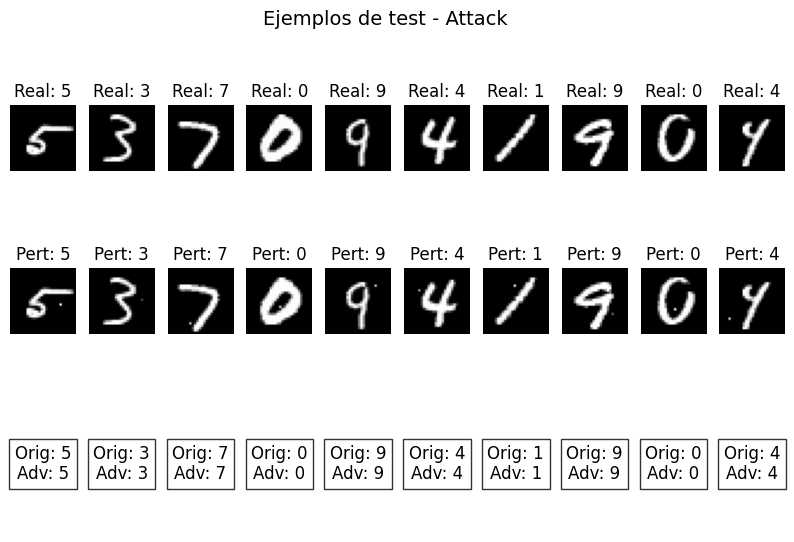

In [161]:
attack = OnePixel(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [162]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 248/250 (99.20%)
Aciertos después del ataque: 240/250 (96.00%)
Cambio de predicción en 8/250 imágenes (3.20%)


(np.float64(0.992), np.float64(0.96), np.float64(0.032))

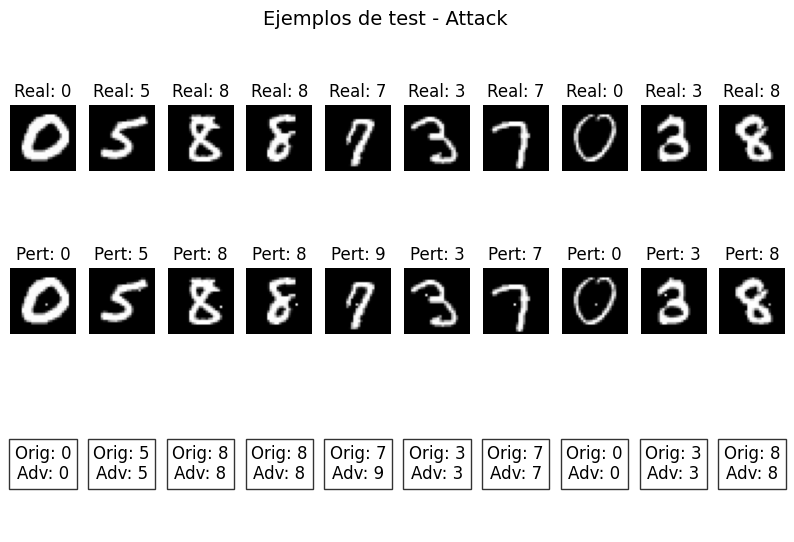

In [163]:
attack = OnePixel(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [164]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 248/250 (99.20%)
Aciertos después del ataque: 243/250 (97.20%)
Cambio de predicción en 5/250 imágenes (2.00%)


(np.float64(0.992), np.float64(0.972), np.float64(0.02))

## 25. SINIFGSM

In [178]:
import torch
import torch.nn as nn


class SINIFGSM(Attack):
    r"""
    SI-NI-FGSM in the paper 'NESTEROV ACCELERATED GRADIENT AND SCALEINVARIANCE FOR ADVERSARIAL ATTACKS'
    [https://arxiv.org/abs/1908.06281], Published as a conference paper at ICLR 2020
    Modified from "https://githuba.com/JHL-HUST/SI-NI-FGSM"

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of iterations. (Default: 10)
        decay (float): momentum factor. (Default: 1.0)
        m (int): number of scale copies. (Default: 5)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.SINIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=1.0, m=5)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, eps=8 / 255, alpha=2 / 255, steps=10, decay=1.0, m=5):
        super().__init__("SINIFGSM", model)
        self.eps = eps
        self.steps = steps
        self.decay = decay
        self.alpha = alpha
        self.m = m
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        momentum = torch.zeros_like(images).detach().to(self.device)

        loss = nn.CrossEntropyLoss()

        adv_images = images.clone().detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            nes_image = adv_images + self.decay * self.alpha * momentum
            # Calculate sum the gradients over the scale copies of the input image
            adv_grad = torch.zeros_like(images).detach().to(self.device)
            for i in torch.arange(self.m):
                nes_images = nes_image / torch.pow(2, i)
                outputs = self.get_logits(nes_images)
                # Calculate loss
                if self.targeted:
                    cost = -loss(outputs, target_labels)
                else:
                    cost = loss(outputs, labels)
                adv_grad += torch.autograd.grad(
                    cost, adv_images, retain_graph=False, create_graph=False
                )[0]
            adv_grad = adv_grad / self.m

            # Update adversarial images
            grad = self.decay * momentum + adv_grad / torch.mean(
                torch.abs(adv_grad), dim=(1, 2, 3), keepdim=True
            )
            momentum = grad
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

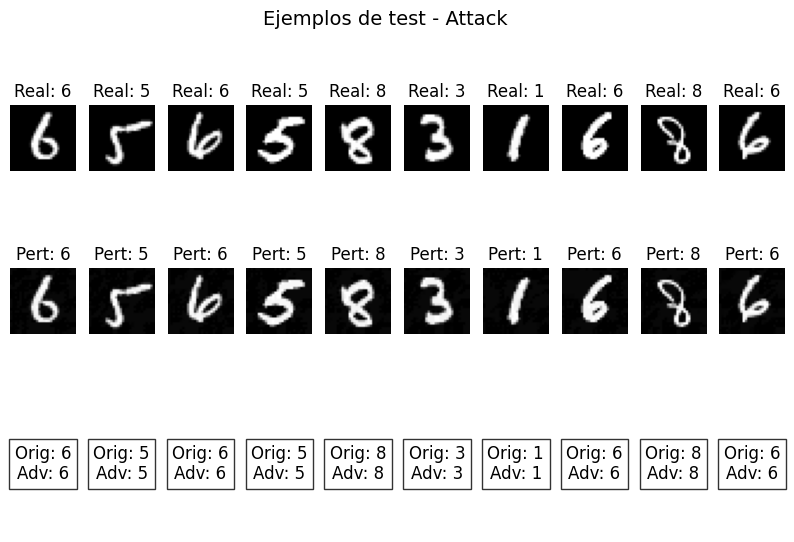

In [179]:
attack = SINIFGSM(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [180]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 245/250 (98.00%)
Aciertos después del ataque: 238/250 (95.20%)
Cambio de predicción en 9/250 imágenes (3.60%)


(np.float64(0.98), np.float64(0.952), np.float64(0.036))

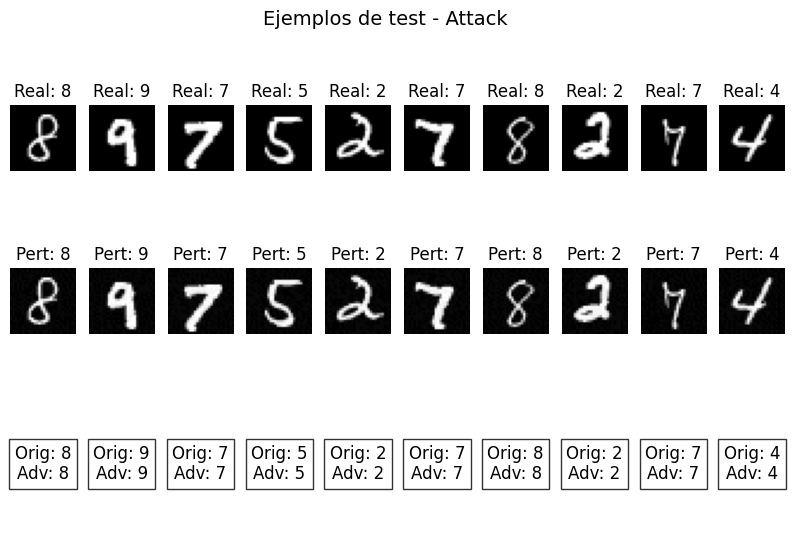

In [181]:
attack = SINIFGSM(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [182]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 250/250 (100.00%)
Aciertos después del ataque: 249/250 (99.60%)
Cambio de predicción en 1/250 imágenes (0.40%)


(np.float64(1.0), np.float64(0.996), np.float64(0.004))

## 26. PGDRS

In [170]:
import torch
import torch.nn.functional as F
import copy



class Noise:
    def __init__(self, noise_type, noise_sd):
        self.noise_type = noise_type
        self.noise_sd = noise_sd

    def __call__(self, img):
        if self.noise_type == "guassian":
            noise = torch.randn_like(img.float()) * self.noise_sd
        elif self.noise_type == "uniform":
            noise = (torch.rand_like(img.float()) - 0.5) * 2 * self.noise_sd
        return noise


class PGDRS(Attack):
    r"""
    PGD for randmized smoothing in the paper 'Provably Robust Deep Learning via Adversarially Trained Smoothed Classifiers'
    [https://arxiv.org/abs/1906.04584]
    Modification of the code from https://github.com/Hadisalman/smoothing-adversarial/blob/master/code/attacks.py

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 40)
        noise_type (str): guassian or uniform. (Default: guassian)
        noise_sd (float): standard deviation for normal distributio, or range for . (Default: 0.5)
        noise_batch_size (int): guassian or uniform. (Default: 5)
        batch_max (int): split data into small chunk if the total number of augmented data points, len(inputs)*noise_batch_size, are larger than batch_max, in case GPU memory is insufficient. (Default: 2048)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.PGDRS(model, eps=8/255, alpha=2/255, steps=10, noise_type="guassian", noise_sd=0.5, noise_batch_size=5, batch_max=2048)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        eps=8 / 255,
        alpha=2 / 255,
        steps=10,
        noise_type="guassian",
        noise_sd=0.5,
        noise_batch_size=5,
        batch_max=2048,
    ):
        super().__init__("PGDRS", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.noise_func = Noise(noise_type, noise_sd)
        self.noise_batch_size = noise_batch_size
        self.supported_mode = ["default", "targeted"]
        self.batch_max = batch_max

    def forward(self, inputs: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        if inputs.shape[0] * self.noise_batch_size > self.batch_max:
            split_num = int(self.batch_max / self.noise_batch_size)
            inputs_split = torch.split(inputs, split_size_or_sections=split_num)
            labels_split = torch.split(labels, split_size_or_sections=split_num)
            img_list = []
            for img_sub, lab_sub in zip(inputs_split, labels_split):
                img_adv = self._forward(img_sub, lab_sub)
                img_list.append(img_adv)
            return torch.vstack(img_list)
        else:
            return self._forward(inputs, labels)

    def _forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        # expend the inputs over noise_batch_size
        shape = (
            torch.Size([images.shape[0], self.noise_batch_size]) + images.shape[1:]
        )  # nopep8
        inputs_exp = images.unsqueeze(1).expand(shape)
        inputs_exp = inputs_exp.reshape(
            torch.Size([-1]) + inputs_exp.shape[2:]
        )  # nopep8

        delta = torch.zeros(
            (len(labels), *inputs_exp.shape[1:]), requires_grad=True, device=self.device
        )
        delta_last = torch.zeros(
            (len(labels), *inputs_exp.shape[1:]),
            requires_grad=False,
            device=self.device,
        )

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        for _ in range(self.steps):
            delta.requires_grad = True
            # img_adv is the perturbed data for randmized smoothing
            # delta.repeat(1,self.noise_batch_size,1,1).view_as(inputs_exp)
            img_adv = inputs_exp + delta.unsqueeze(1).repeat(
                (1, self.noise_batch_size, 1, 1, 1)
            ).view_as(
                inputs_exp
            )  # nopep8
            img_adv = torch.clamp(img_adv, min=0, max=1)

            noise_added = self.noise_func(img_adv.view(len(img_adv), -1))
            noise_added = noise_added.view(img_adv.shape)

            adv_noise = img_adv + noise_added
            logits = self.get_logits(adv_noise)

            softmax = F.softmax(logits, dim=1)
            # average the probabilities across noise
            average_softmax = (
                softmax.reshape(-1, self.noise_batch_size, logits.shape[-1])
                .mean(1, keepdim=True)
                .squeeze(1)
            )
            logsoftmax = torch.log(average_softmax.clamp(min=1e-20))
            ce_loss = (
                F.nll_loss(logsoftmax, labels)
                if not self.targeted
                else -F.nll_loss(logsoftmax, target_labels)
            )

            grad = torch.autograd.grad(
                ce_loss, delta, retain_graph=False, create_graph=False
            )[0]
            delta = delta_last + self.alpha * torch.sign(grad)
            delta = torch.clamp(delta, min=-self.eps, max=self.eps)
            delta_last.data = copy.deepcopy(delta.data)

        adv_images = torch.clamp(images + delta, min=0, max=1).detach()
        return adv_images

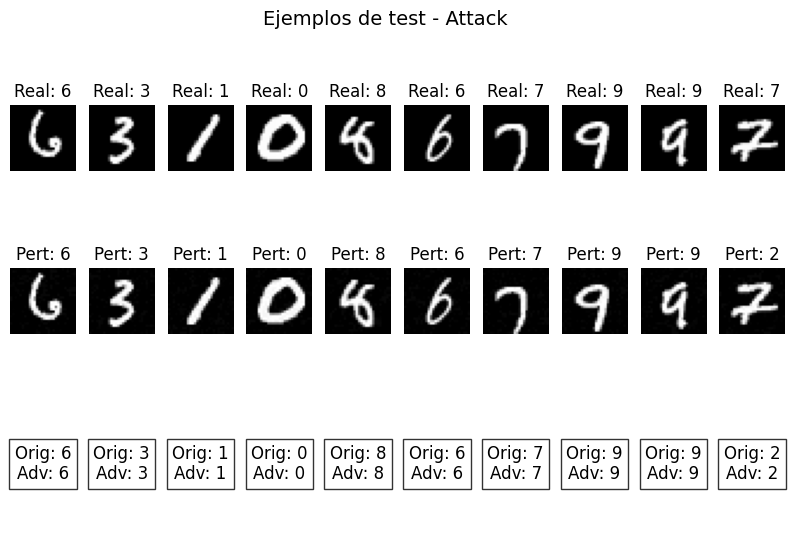

In [171]:
attack = PGDRS(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [172]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 249/250 (99.60%)
Aciertos después del ataque: 249/250 (99.60%)
Cambio de predicción en 0/250 imágenes (0.00%)


(np.float64(0.996), np.float64(0.996), np.float64(0.0))

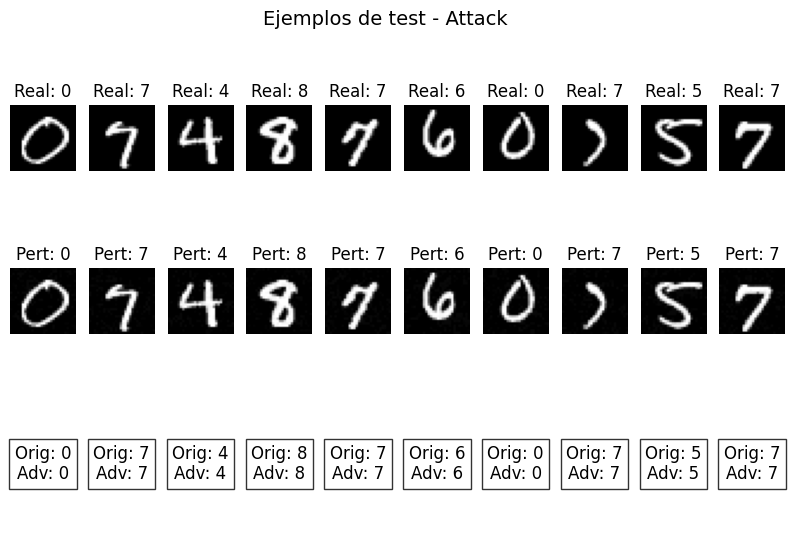

In [173]:
attack = PGDRS(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [174]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 250/250 (100.00%)
Aciertos después del ataque: 250/250 (100.00%)
Cambio de predicción en 0/250 imágenes (0.00%)


(np.float64(1.0), np.float64(1.0), np.float64(0.0))

## 27. PGDRSL2

In [165]:
import torch
import torch.nn.functional as F

import copy


class Noise:
    def __init__(self, noise_type, noise_sd):
        self.noise_type = noise_type
        self.noise_sd = noise_sd

    def __call__(self, img):
        if self.noise_type == "guassian":
            noise = torch.randn_like(img.float()) * self.noise_sd
        elif self.noise_type == "uniform":
            noise = (torch.rand_like(img.float()) - 0.5) * 2 * self.noise_sd
        return noise


class PGDRSL2(Attack):
    r"""
    PGD for randmized smoothing in the paper 'Provably Robust Deep Learning via Adversarially Trained Smoothed Classifiers'
    [https://arxiv.org/abs/1906.04584]
    Modification of the code from https://github.com/Hadisalman/smoothing-adversarial/blob/master/code/attacks.py

    Distance Measure : L2

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 1.0)
        alpha (float): step size. (Default: 0.2)
        steps (int): number of steps. (Default: 10)
        noise_type (str): guassian or uniform. (Default: guassian)
        noise_sd (float): standard deviation for normal distributio, or range for . (Default: 0.5)
        noise_batch_size (int): guassian or uniform. (Default: 5)
        batch_max (int): split data into small chunk if the total number of augmented data points, len(inputs)*noise_batch_size, are larger than batch_max, in case GPU memory is insufficient. (Default: 2048)
        random_start (bool): using random initialization of delta. (Default: True)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.PGDRSL2(model, eps=1.0, alpha=0.2, steps=10, noise_type="guassian", noise_sd=0.5, noise_batch_size=5, batch_max=2048)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        eps=1.0,
        alpha=0.2,
        steps=10,
        noise_type="guassian",
        noise_sd=0.5,
        noise_batch_size=5,
        batch_max=2048,
        eps_for_division=1e-10,
    ):
        super().__init__("PGDRSL2", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.noise_func = Noise(noise_type, noise_sd)
        self.noise_batch_size = noise_batch_size
        self.eps_for_division = eps_for_division
        self.supported_mode = ["default", "targeted"]
        self.batch_max = batch_max

    def forward(self, inputs: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        if inputs.shape[0] * self.noise_batch_size > self.batch_max:
            img_list = []
            split_num = int(self.batch_max / self.noise_batch_size)
            inputs_split = torch.split(inputs, split_size_or_sections=split_num)
            labels_split = torch.split(labels, split_size_or_sections=split_num)
            for img_sub, lab_sub in zip(inputs_split, labels_split):
                img_adv = self._forward(img_sub, lab_sub)
                img_list.append(img_adv)
            return torch.vstack(img_list)
        else:
            return self._forward(inputs, labels)

    def _forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        # expend the inputs over noise_batch_size
        shape = (
            torch.Size([images.shape[0], self.noise_batch_size]) + images.shape[1:]
        )  # nopep8
        inputs_exp = images.unsqueeze(1).expand(shape)
        inputs_exp = inputs_exp.reshape(
            torch.Size([-1]) + inputs_exp.shape[2:]
        )  # nopep8

        data_batch_size = labels.shape[0]
        delta = torch.zeros(
            (len(labels), *inputs_exp.shape[1:]), requires_grad=True, device=self.device
        )
        delta_last = torch.zeros(
            (len(labels), *inputs_exp.shape[1:]),
            requires_grad=False,
            device=self.device,
        )

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        for _ in range(self.steps):
            delta.requires_grad = True
            # img_adv is the perturbed data for randmized smoothing
            # delta.repeat(1,self.noise_batch_size,1,1)
            img_adv = inputs_exp + delta.unsqueeze(1).repeat(
                (1, self.noise_batch_size, 1, 1, 1)
            ).view_as(
                inputs_exp
            )  # nopep8
            img_adv = torch.clamp(img_adv, min=0, max=1)

            noise_added = self.noise_func(img_adv.view(len(img_adv), -1))
            noise_added = noise_added.view(img_adv.shape)

            adv_noise = img_adv + noise_added
            logits = self.get_logits(adv_noise)

            softmax = F.softmax(logits, dim=1)
            # average the probabilities across noise
            average_softmax = (
                softmax.reshape(-1, self.noise_batch_size, logits.shape[-1])
                .mean(1, keepdim=True)
                .squeeze(1)
            )
            logsoftmax = torch.log(average_softmax.clamp(min=1e-20))
            ce_loss = (
                F.nll_loss(logsoftmax, labels)
                if not self.targeted
                else -F.nll_loss(logsoftmax, target_labels)
            )

            grad = torch.autograd.grad(
                ce_loss, delta, retain_graph=False, create_graph=False
            )[0]
            grad_norms = (
                torch.norm(grad.view(data_batch_size, -1), p=2, dim=1)
                + self.eps_for_division
            )
            grad = grad / grad_norms.view(data_batch_size, 1, 1, 1)

            delta = delta_last + self.alpha * grad
            delta_norms = torch.norm(delta.view(data_batch_size, -1), p=2, dim=1)
            factor = self.eps / delta_norms
            factor = torch.min(factor, torch.ones_like(delta_norms))
            delta = delta * factor.view(-1, 1, 1, 1)
            delta_last.data = copy.deepcopy(delta.data)

        adv_images = torch.clamp(images + delta, min=0, max=1).detach()
        return adv_images

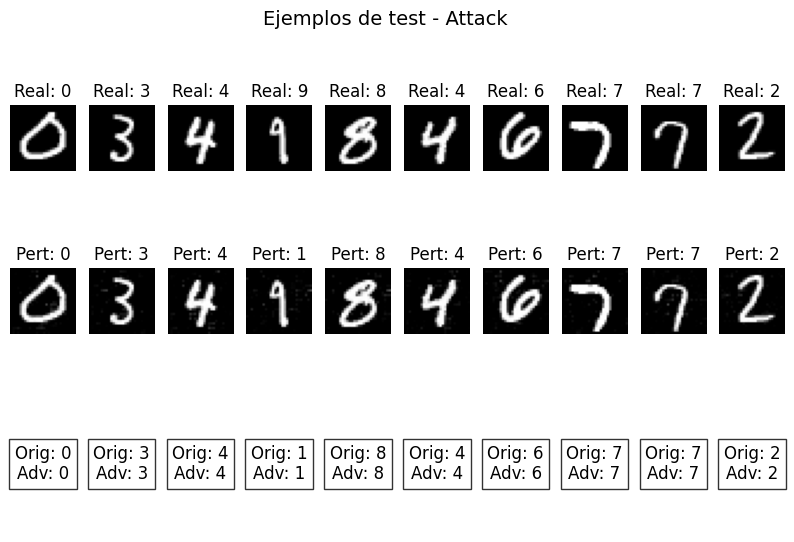

In [166]:
attack = PGDRSL2(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [167]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 242/250 (96.80%)
Aciertos después del ataque: 242/250 (96.80%)
Cambio de predicción en 3/250 imágenes (1.20%)


(np.float64(0.968), np.float64(0.968), np.float64(0.012))

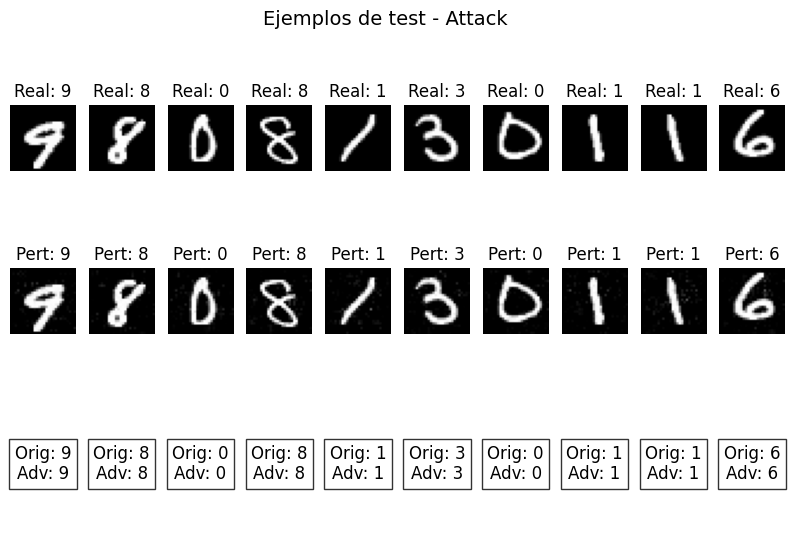

In [168]:
attack = PGDRSL2(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [169]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 248/250 (99.20%)
Aciertos después del ataque: 248/250 (99.20%)
Cambio de predicción en 0/250 imágenes (0.00%)


(np.float64(0.992), np.float64(0.992), np.float64(0.0))

## 28. PIFGSM **

In [175]:
import torch
import torch.nn.functional as F
import numpy as np


class PIFGSM(Attack):
    r"""
    PIFGSM in the paper 'Patch-wise Attack for Fooling Deep Neural Network'
    [https://arxiv.org/abs/2007.06765]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        max_epsilon (float): maximum size of adversarial perturbation. (Default: 16/255)
        num_iter_set (float): number of iterations. (Default: 10)
        momentum (float): momentum. (Default: 1.0)
        amplification (float): to amplifythe step size. (Default: 10.0)
        prob (float): probability of using diverse inputs. (Default: 0.7)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.PIFGSM(model, eps=16/255, num_iter_set=10)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        max_epsilon=16 / 255,
        num_iter_set=10,
        momentum=1.0,
        amplification=10.0,
        prob=0.7,
    ):
        super().__init__("PIFGSM", model)
        self.max_epsilon = max_epsilon
        self.num_iter_set = num_iter_set
        self.momentum = momentum
        self.amplification = amplification
        self.prob = prob
        self.supported_mode = ["default"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        images_min = self.clip_by_tensor(images - self.max_epsilon, t_min=0, t_max=1)
        images_max = self.clip_by_tensor(images + self.max_epsilon, t_min=0, t_max=1)
        adv_images = self.graph(images, labels, images_min, images_max)

        return adv_images

    def clip_by_tensor(self, t, t_min, t_max):
        result = (t >= t_min).float() * t + (t < t_min).float() * t_min
        result = (result <= t_max).float() * result + (result > t_max).float() * t_max
        return result

    def project_noise(self, images, P_kern, padding_size):
        images = F.conv2d(
            images, P_kern, padding=(padding_size, padding_size), groups=3
        )
        return images

    def project_kern(self, kern_size):
        kern = np.ones((kern_size, kern_size), dtype=np.float32) / (kern_size ** 2 - 1)
        kern[kern_size // 2, kern_size // 2] = 0.0
        kern = kern.astype(np.float32)
        stack_kern = np.stack([kern, kern, kern])
        stack_kern = np.expand_dims(stack_kern, 1)
        stack_kern = torch.tensor(stack_kern).to(self.device)
        return stack_kern, kern_size // 2

    def graph(self, images, labels, images_min, images_max):
        eps = self.max_epsilon
        num_iter = self.num_iter_set
        alpha = eps / num_iter
        alpha_beta = alpha * self.amplification
        gamma = alpha_beta
        P_kern, padding_size = self.project_kern(3)

        images.requires_grad = True
        amplification = 0.0
        for _ in range(num_iter):
            # zero_gradients(images)
            if images.grad is not None:
                images.grad.detach_()
                images.grad.zero_()

            output_v3 = self.get_logits(images)
            loss = F.cross_entropy(output_v3, labels)
            loss.backward()
            noise = images.grad.data

            amplification += alpha_beta * torch.sign(noise)
            cut_noise = torch.clamp(abs(amplification) - eps, 0, 10000.0) * torch.sign(
                amplification
            )
            projection = gamma * torch.sign(
                self.project_noise(cut_noise, P_kern, padding_size)
            )
            amplification += projection

            images = images + alpha_beta * torch.sign(noise) + projection
            images = self.clip_by_tensor(images, images_min, images_max)
            images = images.detach().requires_grad_(True)

        return images.detach()

In [177]:
attack = PIFGSM(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

RuntimeError: Given groups=3, weight of size [3, 1, 3, 3], expected input[250, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [ ]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

In [ ]:
attack = PIFGSM(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [ ]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

## 29. SparseFool (compile DeepFool first)

In [184]:
import numpy as np

import torch



class SparseFool(Attack):
    r"""
    Attack in the paper 'SparseFool: a few pixels make a big difference'
    [https://arxiv.org/abs/1811.02248]

    Modified from "https://github.com/LTS4/SparseFool/"

    Distance Measure : L0

    Arguments:
        model (nn.Module): model to attack.
        steps (int): number of steps. (Default: 10)
        lam (float): parameter for scaling DeepFool noise. (Default: 3)
        overshoot (float): parameter for enhancing the noise. (Default: 0.02)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.SparseFool(model, steps=10, lam=3, overshoot=0.02)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, steps=10, lam=3, overshoot=0.02):
        super().__init__("SparseFool", model)
        self.steps = steps
        self.lam = lam
        self.overshoot = overshoot
        self.deepfool = DeepFool(model)
        self.supported_mode = ["default"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        batch_size = len(images)
        correct = torch.tensor([True] * batch_size)
        curr_steps = 0

        adv_images = []
        for idx in range(batch_size):
            image = images[idx : idx + 1].clone().detach()
            adv_images.append(image)

        while (True in correct) and (curr_steps < self.steps):
            for idx in range(batch_size):
                image = images[idx : idx + 1]
                label = labels[idx : idx + 1]
                adv_image = adv_images[idx]

                fs = self.get_logits(adv_image)[0]
                _, pre = torch.max(fs, dim=0)
                if pre != label:
                    correct[idx] = False
                    continue

                adv_image, target_label = self.deepfool.forward_return_target_labels(
                    adv_image, label
                )
                adv_image = image + self.lam * (adv_image - image)

                adv_image.requires_grad = True
                fs = self.get_logits(adv_image)[0]
                _, pre = torch.max(fs, dim=0)

                if pre == label:
                    pre = target_label

                cost = fs[pre] - fs[label]
                grad = torch.autograd.grad(
                    cost, adv_image, retain_graph=False, create_graph=False
                )[0]
                grad = grad / grad.norm()

                adv_image = self._linear_solver(image, grad, adv_image)
                adv_image = image + (1 + self.overshoot) * (adv_image - image)
                adv_images[idx] = torch.clamp(adv_image, min=0, max=1).detach()

            curr_steps += 1

        adv_images = torch.cat(adv_images).detach()

        return adv_images

    def _linear_solver(self, x_0, coord_vec, boundary_point):
        input_shape = x_0.size()

        plane_normal = coord_vec.clone().detach().view(-1)
        plane_point = boundary_point.clone().detach().view(-1)

        x_i = x_0.clone().detach()

        f_k = torch.dot(plane_normal, x_0.view(-1) - plane_point)
        sign_true = f_k.sign().item()

        beta = 0.001 * sign_true
        current_sign = sign_true

        while current_sign == sign_true and coord_vec.nonzero().size()[0] > 0:

            f_k = torch.dot(plane_normal, x_i.view(-1) - plane_point) + beta

            pert = f_k.abs() / coord_vec.abs().max()

            mask = torch.zeros_like(coord_vec)
            mask[
                np.unravel_index(torch.argmax(coord_vec.abs()).cpu(), input_shape)
            ] = 1.0  # nopep8

            r_i = torch.clamp(pert, min=1e-4) * mask * coord_vec.sign()

            x_i = x_i + r_i
            x_i = torch.clamp(x_i, min=0, max=1)

            f_k = torch.dot(plane_normal, x_i.view(-1) - plane_point)
            current_sign = f_k.sign().item()

            coord_vec[r_i != 0] = 0

        return x_i

/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_905/1009563204.py:120: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.unravel_index(torch.argmax(coord_vec.abs()).cpu(), input_shape)


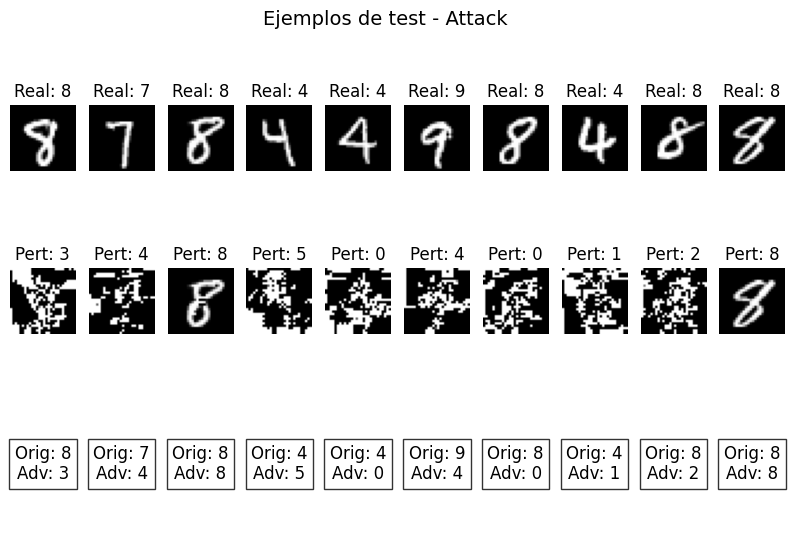

In [185]:
attack = SparseFool(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [186]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 249/250 (99.60%)
Aciertos después del ataque: 32/250 (12.80%)
Cambio de predicción en 217/250 imágenes (86.80%)


(np.float64(0.996), np.float64(0.128), np.float64(0.868))

/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_905/1009563204.py:120: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.unravel_index(torch.argmax(coord_vec.abs()).cpu(), input_shape)


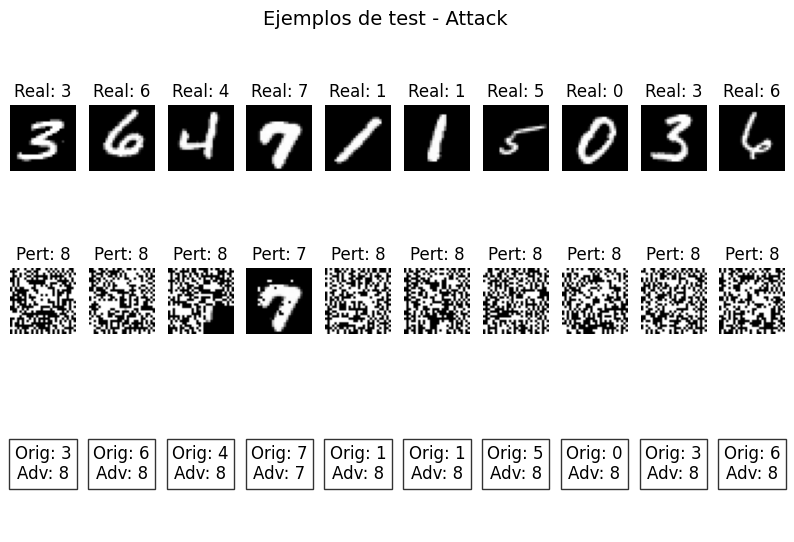

In [187]:
attack = SparseFool(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [188]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 249/250 (99.60%)
Aciertos después del ataque: 43/250 (17.20%)
Cambio de predicción en 206/250 imágenes (82.40%)


(np.float64(0.996), np.float64(0.172), np.float64(0.824))

## 30. TIFGSM **

In [189]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from scipy import stats as st


class TIFGSM(Attack):
    r"""
    TIFGSM in the paper 'Evading Defenses to Transferable Adversarial Examples by Translation-Invariant Attacks'
    [https://arxiv.org/abs/1904.02884]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of iterations. (Default: 10)
        decay (float): momentum factor. (Default: 0.0)
        kernel_name (str): kernel name. (Default: gaussian)
        len_kernel (int): kernel length.  (Default: 15, which is the best according to the paper)
        nsig (int): radius of gaussian kernel. (Default: 3; see Section 3.2.2 in the paper for explanation)
        resize_rate (float): resize factor used in input diversity. (Default: 0.9)
        diversity_prob (float) : the probability of applying input diversity. (Default: 0.5)
        random_start (bool): using random initialization of delta. (Default: False)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`, `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.TIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=1.0, resize_rate=0.9, diversity_prob=0.7, random_start=False)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        eps=8 / 255,
        alpha=2 / 255,
        steps=10,
        decay=0.0,
        kernel_name="gaussian",
        len_kernel=15,
        nsig=3,
        resize_rate=0.9,
        diversity_prob=0.5,
        random_start=False,
    ):
        super().__init__("TIFGSM", model)
        self.eps = eps
        self.steps = steps
        self.decay = decay
        self.alpha = alpha
        self.resize_rate = resize_rate
        self.diversity_prob = diversity_prob
        self.random_start = random_start
        self.kernel_name = kernel_name
        self.len_kernel = len_kernel
        self.nsig = nsig
        self.stacked_kernel = torch.from_numpy(self.kernel_generation())
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()
        momentum = torch.zeros_like(images).detach().to(self.device)
        stacked_kernel = self.stacked_kernel.to(self.device)

        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(
                -self.eps, self.eps
            )
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(self.input_diversity(adv_images))

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]
            # depth wise conv2d
            grad = F.conv2d(grad, stacked_kernel, stride=1, padding="same", groups=3)
            grad = grad / torch.mean(torch.abs(grad), dim=(1, 2, 3), keepdim=True)
            grad = grad + momentum * self.decay
            momentum = grad

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

    def kernel_generation(self):
        if self.kernel_name == "gaussian":
            kernel = self.gkern(self.len_kernel, self.nsig).astype(np.float32)
        elif self.kernel_name == "linear":
            kernel = self.lkern(self.len_kernel).astype(np.float32)
        elif self.kernel_name == "uniform":
            kernel = self.ukern(self.len_kernel).astype(np.float32)
        else:
            raise NotImplementedError

        stack_kernel = np.stack([kernel, kernel, kernel])
        stack_kernel = np.expand_dims(stack_kernel, 1)
        return stack_kernel

    def gkern(self, kernlen=15, nsig=3):
        """Returns a 2D Gaussian kernel array."""
        x = np.linspace(-nsig, nsig, kernlen)
        kern1d = st.norm.pdf(x)
        kernel_raw = np.outer(kern1d, kern1d)
        kernel = kernel_raw / kernel_raw.sum()
        return kernel

    def ukern(self, kernlen=15):
        kernel = np.ones((kernlen, kernlen)) * 1.0 / (kernlen * kernlen)
        return kernel

    def lkern(self, kernlen=15):
        kern1d = 1 - np.abs(
            np.linspace((-kernlen + 1) / 2, (kernlen - 1) / 2, kernlen)
            / (kernlen + 1)
            * 2
        )
        kernel_raw = np.outer(kern1d, kern1d)
        kernel = kernel_raw / kernel_raw.sum()
        return kernel

    def input_diversity(self, x):
        img_size = x.shape[-1]
        img_resize = int(img_size * self.resize_rate)

        if self.resize_rate < 1:
            img_size = img_resize
            img_resize = x.shape[-1]

        rnd = torch.randint(low=img_size, high=img_resize, size=(1,), dtype=torch.int32)
        rescaled = F.interpolate(
            x, size=[rnd, rnd], mode="bilinear", align_corners=False
        )
        h_rem = img_resize - rnd
        w_rem = img_resize - rnd
        pad_top = torch.randint(low=0, high=h_rem.item(), size=(1,), dtype=torch.int32)
        pad_bottom = h_rem - pad_top
        pad_left = torch.randint(low=0, high=w_rem.item(), size=(1,), dtype=torch.int32)
        pad_right = w_rem - pad_left

        padded = F.pad(
            rescaled,
            [pad_left.item(), pad_right.item(), pad_top.item(), pad_bottom.item()],
            value=0,
        )

        return padded if torch.rand(1) < self.diversity_prob else x

In [190]:
attack = TIFGSM(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

RuntimeError: Given groups=3, weight of size [3, 1, 15, 15], expected input[250, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [ ]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

In [ ]:
attack = TIFGSM(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [ ]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

## 31. TPGD

In [191]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TPGD(Attack):
    r"""
    PGD based on KL-Divergence loss in the paper 'Theoretically Principled Trade-off between Robustness and Accuracy'
    [https://arxiv.org/abs/1901.08573]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): strength of the attack or maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 10)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.TPGD(model, eps=8/255, alpha=2/255, steps=10)
        >>> adv_images = attack(images)

    """

    def __init__(self, model, eps=8 / 255, alpha=2 / 255, steps=10):
        super().__init__("TPGD", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.supported_mode = ["default"]

    def forward(self, images, labels=None):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        logit_ori = self.get_logits(images).detach()

        adv_images = images + 0.001 * torch.randn_like(images)
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        loss = nn.KLDivLoss(reduction="sum")

        for _ in range(self.steps):
            adv_images.requires_grad = True
            logit_adv = self.get_logits(adv_images)

            # Calculate loss
            cost = loss(F.log_softmax(logit_adv, dim=1), F.softmax(logit_ori, dim=1))

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

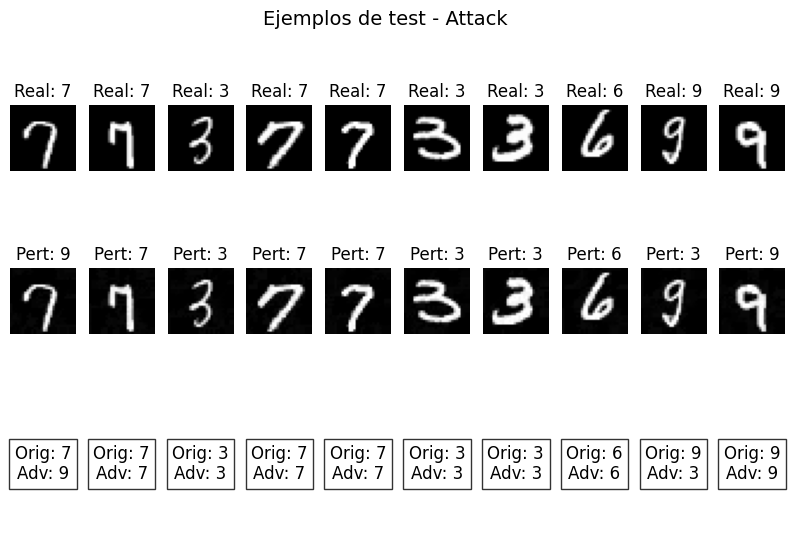

In [192]:
attack = TPGD(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [193]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 246/250 (98.40%)
Aciertos después del ataque: 221/250 (88.40%)
Cambio de predicción en 25/250 imágenes (10.00%)


(np.float64(0.984), np.float64(0.884), np.float64(0.1))

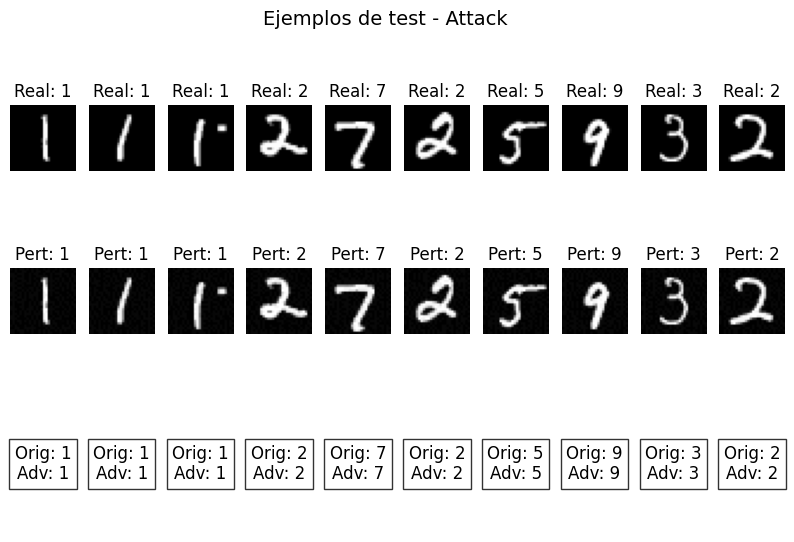

In [194]:
attack = TPGD(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [195]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 249/250 (99.60%)
Aciertos después del ataque: 248/250 (99.20%)
Cambio de predicción en 1/250 imágenes (0.40%)


(np.float64(0.996), np.float64(0.992), np.float64(0.004))

## 32. VMIFGSM

In [196]:
import torch
import torch.nn as nn

class VMIFGSM(Attack):
    r"""
    VMI-FGSM in the paper 'Enhancing the Transferability of Adversarial Attacks through Variance Tuning
    [https://arxiv.org/abs/2103.15571], Published as a conference paper at CVPR 2021
    Modified from "https://github.com/JHL-HUST/VT"

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        steps (int): number of iterations. (Default: 10)
        alpha (float): step size. (Default: 2/255)
        decay (float): momentum factor. (Default: 1.0)
        N (int): the number of sampled examples in the neighborhood. (Default: 5)
        beta (float): the upper bound of neighborhood. (Default: 3/2)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.VMIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=1.0, N=5, beta=3/2)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self, model, eps=8 / 255, alpha=2 / 255, steps=10, decay=1.0, N=5, beta=3 / 2
    ):
        super().__init__("VMIFGSM", model)
        self.eps = eps
        self.steps = steps
        self.decay = decay
        self.alpha = alpha
        self.N = N
        self.beta = beta
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        momentum = torch.zeros_like(images).detach().to(self.device)
        v = torch.zeros_like(images).detach().to(self.device)
        loss = nn.CrossEntropyLoss()
        adv_images = images.clone().detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            adv_grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]

            grad = (adv_grad + v) / torch.mean(
                torch.abs(adv_grad + v), dim=(1, 2, 3), keepdim=True
            )
            grad = grad + momentum * self.decay
            momentum = grad

            # Calculate Gradient Variance
            GV_grad = torch.zeros_like(images).detach().to(self.device)
            for _ in range(self.N):
                neighbor_images = adv_images.detach() + torch.randn_like(
                    images
                ).uniform_(-self.eps * self.beta, self.eps * self.beta)
                neighbor_images.requires_grad = True
                outputs = self.get_logits(neighbor_images)

                # Calculate loss
                if self.targeted:
                    cost = -loss(outputs, target_labels)
                else:
                    cost = loss(outputs, labels)
                GV_grad += torch.autograd.grad(
                    cost, neighbor_images, retain_graph=False, create_graph=False
                )[0]
            # obtaining the gradient variance
            v = GV_grad / self.N - adv_grad

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

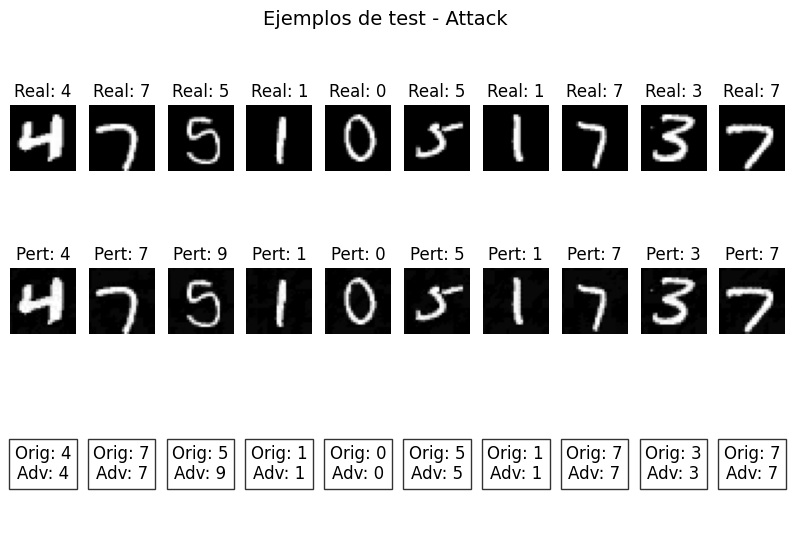

In [197]:
attack = VMIFGSM(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [198]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 246/250 (98.40%)
Aciertos después del ataque: 200/250 (80.00%)
Cambio de predicción en 46/250 imágenes (18.40%)


(np.float64(0.984), np.float64(0.8), np.float64(0.184))

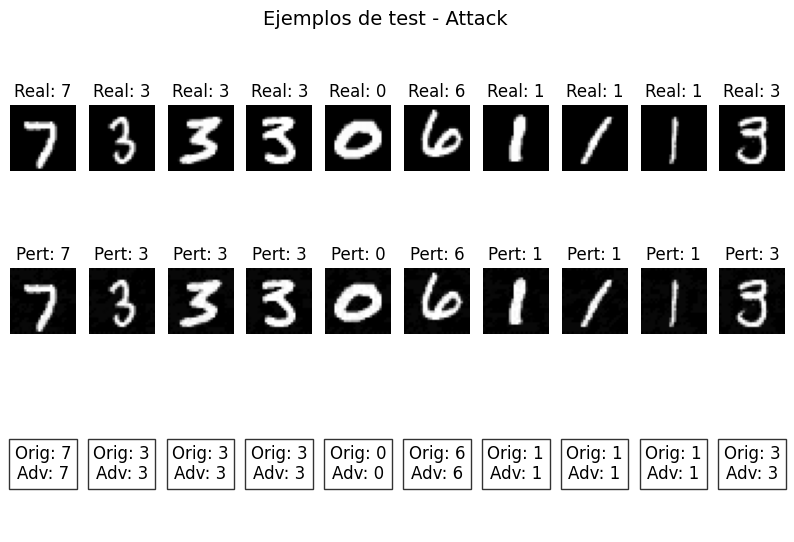

In [199]:
attack = VMIFGSM(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [200]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 245/250 (98.00%)
Aciertos después del ataque: 245/250 (98.00%)
Cambio de predicción en 0/250 imágenes (0.00%)


(np.float64(0.98), np.float64(0.98), np.float64(0.0))

## 33. VNIFGSM

In [202]:
import torch
import torch.nn as nn


class VNIFGSM(Attack):
    r"""
    VNI-FGSM in the paper 'Enhancing the Transferability of Adversarial Attacks through Variance Tuning
    [https://arxiv.org/abs/2103.15571], Published as a conference paper at CVPR 2021
    Modified from "https://github.com/JHL-HUST/VT"

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of iterations. (Default: 10)
        decay (float): momentum factor. (Default: 1.0)
        N (int): the number of sampled examples in the neighborhood. (Default: 5)
        beta (float): the upper bound of neighborhood. (Default: 3/2)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.VNIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=1.0, N=5, beta=3/2)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self, model, eps=8 / 255, alpha=2 / 255, steps=10, decay=1.0, N=5, beta=3 / 2
    ):
        super().__init__("VNIFGSM", model)
        self.eps = eps
        self.steps = steps
        self.decay = decay
        self.alpha = alpha
        self.N = N
        self.beta = beta
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        momentum = torch.zeros_like(images).detach().to(self.device)
        v = torch.zeros_like(images).detach().to(self.device)
        loss = nn.CrossEntropyLoss()
        adv_images = images.clone().detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            nes_images = adv_images + self.decay * self.alpha * momentum
            outputs = self.get_logits(nes_images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            adv_grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]

            grad = (adv_grad + v) / torch.mean(
                torch.abs(adv_grad + v), dim=(1, 2, 3), keepdim=True
            )
            grad = grad + momentum * self.decay
            momentum = grad

            # Calculate Gradient Variance
            GV_grad = torch.zeros_like(images).detach().to(self.device)
            for _ in range(self.N):
                neighbor_images = adv_images.detach() + torch.randn_like(
                    images
                ).uniform_(-self.eps * self.beta, self.eps * self.beta)
                neighbor_images.requires_grad = True
                outputs = self.get_logits(neighbor_images)

                # Calculate loss
                if self.targeted:
                    cost = -loss(outputs, target_labels)
                else:
                    cost = loss(outputs, labels)
                GV_grad += torch.autograd.grad(
                    cost, neighbor_images, retain_graph=False, create_graph=False
                )[0]
            # obtaining the gradient variance
            v = GV_grad / self.N - adv_grad

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

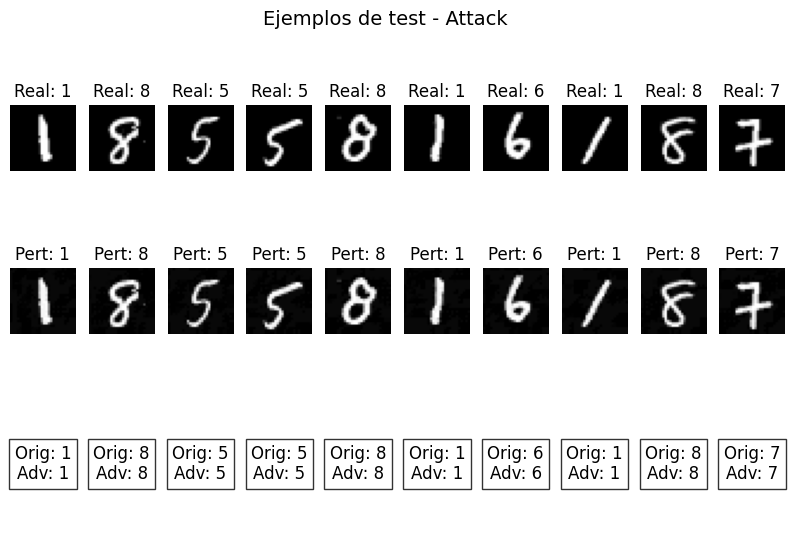

In [203]:
attack = VNIFGSM(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [204]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 248/250 (99.20%)
Aciertos después del ataque: 232/250 (92.80%)
Cambio de predicción en 17/250 imágenes (6.80%)


(np.float64(0.992), np.float64(0.928), np.float64(0.068))

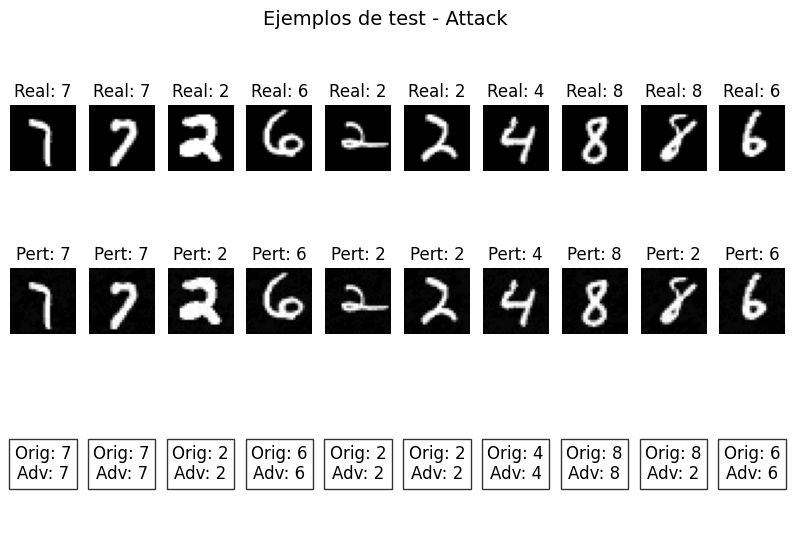

In [205]:
attack = VNIFGSM(FTBx5)
adv_images, batch_x, batch_y = Imagenes_attack(attack, FTBx5)

In [206]:
probabilities_attack2(adv_images, FTBx5, batch_x, batch_y)

Probabilidades originales:


Probabilidades con ataque:



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 244/250 (97.60%)
Cambio de predicción en 3/250 imágenes (1.20%)


(np.float64(0.988), np.float64(0.976), np.float64(0.012))